In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
#from PIL import Image
# Root directory for dataset
dataroot = "./"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [4]:
dataroot

'./'

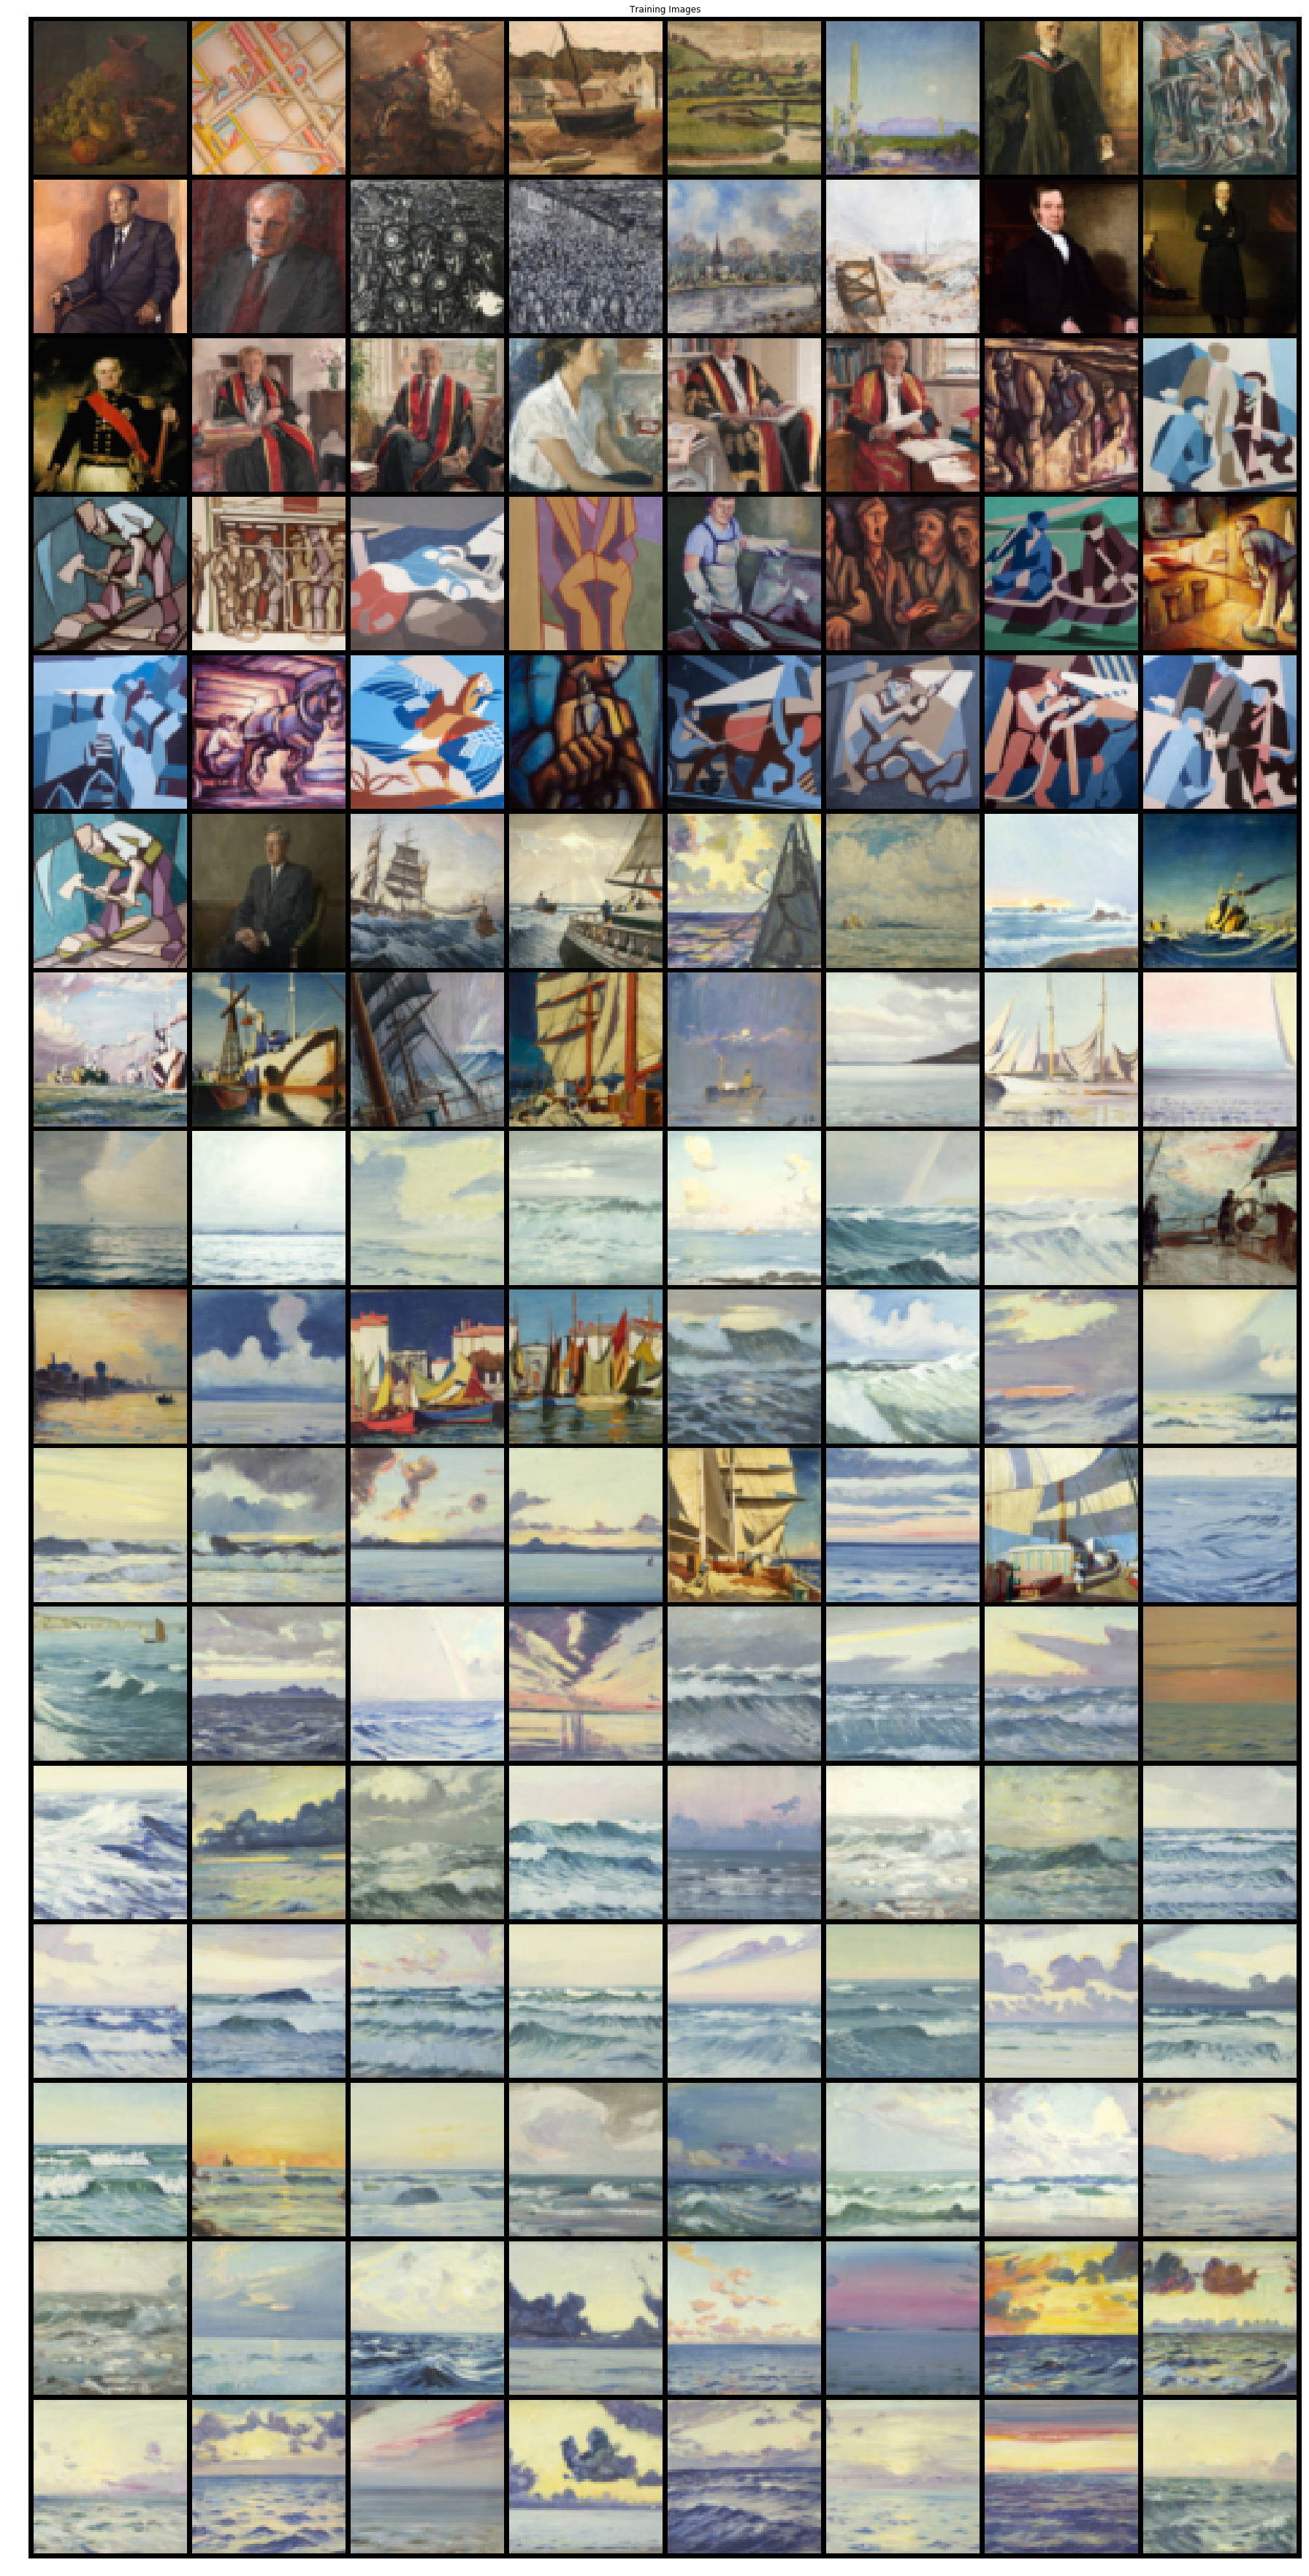

In [5]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(64,64))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:128], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [11]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [12]:
# Lists to keep track of progress
# Training Loop
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/100][0/646]	Loss_D: 1.9679	Loss_G: 4.5807	D(x): 0.4559	D(G(z)): 0.5771 / 0.0160
[0/100][50/646]	Loss_D: 0.1782	Loss_G: 19.4716	D(x): 0.8627	D(G(z)): 0.0000 / 0.0000
[0/100][100/646]	Loss_D: 0.6998	Loss_G: 5.8808	D(x): 0.9196	D(G(z)): 0.4094 / 0.0042
[0/100][150/646]	Loss_D: 0.3985	Loss_G: 4.6917	D(x): 0.8319	D(G(z)): 0.1614 / 0.0120
[0/100][200/646]	Loss_D: 0.3603	Loss_G: 5.5649	D(x): 0.9423	D(G(z)): 0.2394 / 0.0060
[0/100][250/646]	Loss_D: 0.6911	Loss_G: 6.5065	D(x): 0.9834	D(G(z)): 0.4499 / 0.0035
[0/100][300/646]	Loss_D: 1.0064	Loss_G: 3.0762	D(x): 0.5313	D(G(z)): 0.1405 / 0.0629
[0/100][350/646]	Loss_D: 0.4511	Loss_G: 4.6164	D(x): 0.9714	D(G(z)): 0.3113 / 0.0155
[0/100][400/646]	Loss_D: 0.8806	Loss_G: 2.8757	D(x): 0.5698	D(G(z)): 0.1094 / 0.0854


/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[0/100][450/646]	Loss_D: 0.3626	Loss_G: 3.7374	D(x): 0.7520	D(G(z)): 0.0320 / 0.0312
[0/100][500/646]	Loss_D: 0.5515	Loss_G: 1.5781	D(x): 0.7752	D(G(z)): 0.2023 / 0.2758
[0/100][550/646]	Loss_D: 0.1481	Loss_G: 4.4124	D(x): 0.9776	D(G(z)): 0.1137 / 0.0152
[0/100][600/646]	Loss_D: 1.3463	Loss_G: 7.0674	D(x): 0.9365	D(G(z)): 0.5469 / 0.0019
[1/100][0/646]	Loss_D: 1.2319	Loss_G: 2.6728	D(x): 0.3962	D(G(z)): 0.0666 / 0.1111
[1/100][50/646]	Loss_D: 0.6314	Loss_G: 1.6007	D(x): 0.6375	D(G(z)): 0.0361 / 0.2342
[1/100][100/646]	Loss_D: 0.3080	Loss_G: 4.0308	D(x): 0.8366	D(G(z)): 0.0859 / 0.0260
[1/100][150/646]	Loss_D: 0.3146	Loss_G: 5.9653	D(x): 0.9145	D(G(z)): 0.1729 / 0.0061
[1/100][200/646]	Loss_D: 0.5037	Loss_G: 4.2978	D(x): 0.8559	D(G(z)): 0.2488 / 0.0205
[1/100][250/646]	Loss_D: 0.3893	Loss_G: 5.3701	D(x): 0.9424	D(G(z)): 0.2618 / 0.0063
[1/100][300/646]	Loss_D: 1.3076	Loss_G: 1.8677	D(x): 0.4487	D(G(z)): 0.1724 / 0.2285
[1/100][350/646]	Loss_D: 0.5312	Loss_G: 3.1589	D(x): 0.8066	D(G(z)):

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[1/100][450/646]	Loss_D: 0.8113	Loss_G: 2.5312	D(x): 0.5702	D(G(z)): 0.1215 / 0.1187
[1/100][500/646]	Loss_D: 0.4702	Loss_G: 4.9878	D(x): 0.9221	D(G(z)): 0.2766 / 0.0110
[1/100][550/646]	Loss_D: 0.2733	Loss_G: 4.7604	D(x): 0.8995	D(G(z)): 0.1411 / 0.0124
[1/100][600/646]	Loss_D: 3.6087	Loss_G: 4.2831	D(x): 0.9869	D(G(z)): 0.8863 / 0.0408
[2/100][0/646]	Loss_D: 1.2866	Loss_G: 3.1861	D(x): 0.6443	D(G(z)): 0.4901 / 0.0651
[2/100][50/646]	Loss_D: 0.1526	Loss_G: 4.4171	D(x): 0.8866	D(G(z)): 0.0131 / 0.0278
[2/100][100/646]	Loss_D: 0.9272	Loss_G: 4.3235	D(x): 0.8276	D(G(z)): 0.4595 / 0.0275
[2/100][150/646]	Loss_D: 0.9024	Loss_G: 0.9355	D(x): 0.4745	D(G(z)): 0.0138 / 0.4657
[2/100][200/646]	Loss_D: 0.6559	Loss_G: 3.2633	D(x): 0.7574	D(G(z)): 0.2537 / 0.0518
[2/100][250/646]	Loss_D: 0.3885	Loss_G: 3.9749	D(x): 0.8988	D(G(z)): 0.2074 / 0.0304
[2/100][300/646]	Loss_D: 2.5947	Loss_G: 0.9133	D(x): 0.2132	D(G(z)): 0.2853 / 0.4783
[2/100][350/646]	Loss_D: 0.5526	Loss_G: 2.6028	D(x): 0.6989	D(G(z)):

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[2/100][450/646]	Loss_D: 0.8502	Loss_G: 3.8298	D(x): 0.7591	D(G(z)): 0.3759 / 0.0321
[2/100][500/646]	Loss_D: 0.7394	Loss_G: 3.3883	D(x): 0.7604	D(G(z)): 0.3131 / 0.0466
[2/100][550/646]	Loss_D: 0.3154	Loss_G: 3.1662	D(x): 0.9854	D(G(z)): 0.2260 / 0.0669
[2/100][600/646]	Loss_D: 1.5465	Loss_G: 5.1723	D(x): 0.9977	D(G(z)): 0.7325 / 0.0113
[3/100][0/646]	Loss_D: 1.4684	Loss_G: 3.0322	D(x): 0.5071	D(G(z)): 0.4276 / 0.0859
[3/100][50/646]	Loss_D: 0.1453	Loss_G: 4.0613	D(x): 0.9193	D(G(z)): 0.0478 / 0.0257
[3/100][100/646]	Loss_D: 0.5761	Loss_G: 3.2861	D(x): 0.8754	D(G(z)): 0.3172 / 0.0511
[3/100][150/646]	Loss_D: 0.3602	Loss_G: 2.6913	D(x): 0.7811	D(G(z)): 0.0813 / 0.0908
[3/100][200/646]	Loss_D: 0.9817	Loss_G: 3.9256	D(x): 0.7473	D(G(z)): 0.4332 / 0.0311
[3/100][250/646]	Loss_D: 0.3327	Loss_G: 3.6222	D(x): 0.8389	D(G(z)): 0.1268 / 0.0391
[3/100][300/646]	Loss_D: 1.1515	Loss_G: 0.5369	D(x): 0.4929	D(G(z)): 0.2052 / 0.6403
[3/100][350/646]	Loss_D: 0.4150	Loss_G: 3.8794	D(x): 0.8219	D(G(z)):

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[3/100][450/646]	Loss_D: 0.8643	Loss_G: 5.9713	D(x): 0.9603	D(G(z)): 0.5005 / 0.0057
[3/100][500/646]	Loss_D: 0.6615	Loss_G: 5.9773	D(x): 0.9633	D(G(z)): 0.4219 / 0.0053
[3/100][550/646]	Loss_D: 0.0245	Loss_G: 5.9172	D(x): 0.9961	D(G(z)): 0.0197 / 0.0060
[3/100][600/646]	Loss_D: 0.4362	Loss_G: 3.5517	D(x): 0.9930	D(G(z)): 0.2754 / 0.0757
[4/100][0/646]	Loss_D: 0.2644	Loss_G: 3.8126	D(x): 0.8691	D(G(z)): 0.1050 / 0.0319
[4/100][50/646]	Loss_D: 0.8113	Loss_G: 4.0036	D(x): 0.9171	D(G(z)): 0.4415 / 0.0314
[4/100][100/646]	Loss_D: 0.5563	Loss_G: 2.6007	D(x): 0.7929	D(G(z)): 0.2297 / 0.1121
[4/100][150/646]	Loss_D: 0.6820	Loss_G: 4.9734	D(x): 0.9645	D(G(z)): 0.4099 / 0.0121
[4/100][200/646]	Loss_D: 1.1902	Loss_G: 4.8231	D(x): 0.9181	D(G(z)): 0.5684 / 0.0147
[4/100][250/646]	Loss_D: 0.3375	Loss_G: 3.1787	D(x): 0.8416	D(G(z)): 0.1325 / 0.0608
[4/100][300/646]	Loss_D: 4.9643	Loss_G: 0.0747	D(x): 0.0317	D(G(z)): 0.0617 / 0.9312
[4/100][350/646]	Loss_D: 0.7764	Loss_G: 4.0736	D(x): 0.8158	D(G(z)):

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[4/100][450/646]	Loss_D: 2.4439	Loss_G: 2.8448	D(x): 0.3806	D(G(z)): 0.6300 / 0.1037
[4/100][500/646]	Loss_D: 1.0929	Loss_G: 5.5124	D(x): 0.9765	D(G(z)): 0.6024 / 0.0059
[4/100][550/646]	Loss_D: 0.2671	Loss_G: 4.7450	D(x): 0.9930	D(G(z)): 0.2078 / 0.0134
[4/100][600/646]	Loss_D: 4.5227	Loss_G: 8.1329	D(x): 0.9997	D(G(z)): 0.9768 / 0.0008
[5/100][0/646]	Loss_D: 0.6490	Loss_G: 3.6936	D(x): 0.5937	D(G(z)): 0.0212 / 0.0411
[5/100][50/646]	Loss_D: 0.3876	Loss_G: 3.4004	D(x): 0.9229	D(G(z)): 0.2421 / 0.0454
[5/100][100/646]	Loss_D: 0.6186	Loss_G: 1.3464	D(x): 0.6258	D(G(z)): 0.0455 / 0.3353
[5/100][150/646]	Loss_D: 0.8783	Loss_G: 0.5307	D(x): 0.5326	D(G(z)): 0.1241 / 0.6431
[5/100][200/646]	Loss_D: 0.7675	Loss_G: 4.5721	D(x): 0.9040	D(G(z)): 0.4286 / 0.0163
[5/100][250/646]	Loss_D: 0.3483	Loss_G: 3.4332	D(x): 0.9129	D(G(z)): 0.2085 / 0.0436
[5/100][300/646]	Loss_D: 1.7713	Loss_G: 0.8569	D(x): 0.3243	D(G(z)): 0.2145 / 0.4954
[5/100][350/646]	Loss_D: 0.5763	Loss_G: 2.4237	D(x): 0.7423	D(G(z)):

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[5/100][450/646]	Loss_D: 1.2005	Loss_G: 2.7720	D(x): 0.6784	D(G(z)): 0.4454 / 0.1257
[5/100][500/646]	Loss_D: 1.1885	Loss_G: 5.1852	D(x): 0.9877	D(G(z)): 0.6254 / 0.0088
[5/100][550/646]	Loss_D: 0.1272	Loss_G: 4.5826	D(x): 0.9964	D(G(z)): 0.1036 / 0.0235
[5/100][600/646]	Loss_D: 0.5721	Loss_G: 5.7787	D(x): 0.9856	D(G(z)): 0.3935 / 0.0043
[6/100][0/646]	Loss_D: 1.0228	Loss_G: 4.0857	D(x): 0.8205	D(G(z)): 0.4927 / 0.0317
[6/100][50/646]	Loss_D: 0.2109	Loss_G: 1.8954	D(x): 0.9194	D(G(z)): 0.1053 / 0.2205
[6/100][100/646]	Loss_D: 0.7277	Loss_G: 3.0957	D(x): 0.7165	D(G(z)): 0.2780 / 0.0613
[6/100][150/646]	Loss_D: 1.5540	Loss_G: 0.1053	D(x): 0.2722	D(G(z)): 0.0144 / 0.9039
[6/100][200/646]	Loss_D: 0.9465	Loss_G: 3.4551	D(x): 0.8548	D(G(z)): 0.4665 / 0.0565
[6/100][250/646]	Loss_D: 0.3629	Loss_G: 4.1123	D(x): 0.8490	D(G(z)): 0.1530 / 0.0265
[6/100][300/646]	Loss_D: 1.7312	Loss_G: 0.5210	D(x): 0.3325	D(G(z)): 0.1788 / 0.6559
[6/100][350/646]	Loss_D: 0.4688	Loss_G: 2.2110	D(x): 0.7699	D(G(z)):

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[6/100][450/646]	Loss_D: 1.7602	Loss_G: 0.4826	D(x): 0.2761	D(G(z)): 0.2033 / 0.6507
[6/100][500/646]	Loss_D: 0.3584	Loss_G: 3.4100	D(x): 0.9252	D(G(z)): 0.2205 / 0.0458
[6/100][550/646]	Loss_D: 0.0778	Loss_G: 4.0803	D(x): 0.9837	D(G(z)): 0.0576 / 0.0261
[6/100][600/646]	Loss_D: 2.7001	Loss_G: 6.4800	D(x): 0.9984	D(G(z)): 0.8725 / 0.0024
[7/100][0/646]	Loss_D: 0.4997	Loss_G: 3.7891	D(x): 0.9048	D(G(z)): 0.2935 / 0.0336
[7/100][50/646]	Loss_D: 0.5856	Loss_G: 3.9907	D(x): 0.8400	D(G(z)): 0.2911 / 0.0294
[7/100][100/646]	Loss_D: 0.4356	Loss_G: 1.6066	D(x): 0.7353	D(G(z)): 0.0839 / 0.2606
[7/100][150/646]	Loss_D: 0.9418	Loss_G: 4.2808	D(x): 0.9251	D(G(z)): 0.5129 / 0.0271
[7/100][200/646]	Loss_D: 0.8313	Loss_G: 3.2914	D(x): 0.8422	D(G(z)): 0.3996 / 0.0621
[7/100][250/646]	Loss_D: 0.5672	Loss_G: 2.5589	D(x): 0.6851	D(G(z)): 0.1195 / 0.1069
[7/100][300/646]	Loss_D: 1.3028	Loss_G: 6.7884	D(x): 0.7514	D(G(z)): 0.5588 / 0.0021
[7/100][350/646]	Loss_D: 0.8010	Loss_G: 3.3231	D(x): 0.8438	D(G(z)):

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[7/100][450/646]	Loss_D: 0.3836	Loss_G: 3.0101	D(x): 0.7690	D(G(z)): 0.0880 / 0.0704
[7/100][500/646]	Loss_D: 1.3806	Loss_G: 5.5945	D(x): 0.9832	D(G(z)): 0.6742 / 0.0063
[7/100][550/646]	Loss_D: 0.3614	Loss_G: 3.4629	D(x): 0.9967	D(G(z)): 0.2676 / 0.0484
[7/100][600/646]	Loss_D: 1.1358	Loss_G: 5.9726	D(x): 0.9802	D(G(z)): 0.5989 / 0.0052
[8/100][0/646]	Loss_D: 0.7859	Loss_G: 0.9548	D(x): 0.5569	D(G(z)): 0.1114 / 0.4429
[8/100][50/646]	Loss_D: 0.4450	Loss_G: 1.9630	D(x): 0.8453	D(G(z)): 0.2082 / 0.2024
[8/100][100/646]	Loss_D: 0.4817	Loss_G: 5.4902	D(x): 0.9371	D(G(z)): 0.2973 / 0.0098
[8/100][150/646]	Loss_D: 0.5831	Loss_G: 2.7755	D(x): 0.7813	D(G(z)): 0.2446 / 0.0830
[8/100][200/646]	Loss_D: 0.9834	Loss_G: 3.8139	D(x): 0.8419	D(G(z)): 0.4600 / 0.0398
[8/100][250/646]	Loss_D: 0.6015	Loss_G: 3.4569	D(x): 0.9089	D(G(z)): 0.3588 / 0.0455
[8/100][300/646]	Loss_D: 0.9279	Loss_G: 1.2842	D(x): 0.5104	D(G(z)): 0.0939 / 0.3328
[8/100][350/646]	Loss_D: 0.6384	Loss_G: 2.5238	D(x): 0.6764	D(G(z)):

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[8/100][450/646]	Loss_D: 1.5816	Loss_G: 2.6565	D(x): 0.5658	D(G(z)): 0.5195 / 0.1193
[8/100][500/646]	Loss_D: 0.5199	Loss_G: 3.1686	D(x): 0.9377	D(G(z)): 0.3299 / 0.0581
[8/100][550/646]	Loss_D: 0.2372	Loss_G: 3.6108	D(x): 0.9854	D(G(z)): 0.1817 / 0.0422
[8/100][600/646]	Loss_D: 1.7561	Loss_G: 9.2120	D(x): 0.9933	D(G(z)): 0.7641 / 0.0004
[9/100][0/646]	Loss_D: 0.6753	Loss_G: 1.2771	D(x): 0.6485	D(G(z)): 0.1567 / 0.3271
[9/100][50/646]	Loss_D: 0.6172	Loss_G: 3.8996	D(x): 0.9332	D(G(z)): 0.3772 / 0.0286
[9/100][100/646]	Loss_D: 0.4736	Loss_G: 2.1399	D(x): 0.7723	D(G(z)): 0.1565 / 0.1505
[9/100][150/646]	Loss_D: 0.5596	Loss_G: 2.6169	D(x): 0.7063	D(G(z)): 0.1410 / 0.0947
[9/100][200/646]	Loss_D: 0.7408	Loss_G: 3.0246	D(x): 0.6436	D(G(z)): 0.1703 / 0.0856
[9/100][250/646]	Loss_D: 0.2465	Loss_G: 3.3556	D(x): 0.9510	D(G(z)): 0.1660 / 0.0515
[9/100][300/646]	Loss_D: 2.0753	Loss_G: 0.4715	D(x): 0.2384	D(G(z)): 0.0923 / 0.6681
[9/100][350/646]	Loss_D: 0.8647	Loss_G: 2.0170	D(x): 0.6047	D(G(z)):

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[9/100][450/646]	Loss_D: 2.0922	Loss_G: 3.7345	D(x): 0.8642	D(G(z)): 0.8017 / 0.0384
[9/100][500/646]	Loss_D: 0.6674	Loss_G: 3.7179	D(x): 0.9453	D(G(z)): 0.4167 / 0.0347
[9/100][550/646]	Loss_D: 0.2654	Loss_G: 3.1570	D(x): 0.9953	D(G(z)): 0.2082 / 0.0645
[9/100][600/646]	Loss_D: 0.6076	Loss_G: 2.7879	D(x): 0.9933	D(G(z)): 0.3717 / 0.1037
[10/100][0/646]	Loss_D: 1.7414	Loss_G: 5.9437	D(x): 0.8711	D(G(z)): 0.7366 / 0.0055
[10/100][50/646]	Loss_D: 0.6830	Loss_G: 5.0559	D(x): 0.9713	D(G(z)): 0.4436 / 0.0098
[10/100][100/646]	Loss_D: 0.3475	Loss_G: 2.5952	D(x): 0.8995	D(G(z)): 0.1938 / 0.1082
[10/100][150/646]	Loss_D: 0.3907	Loss_G: 2.8206	D(x): 0.8833	D(G(z)): 0.2150 / 0.0776
[10/100][200/646]	Loss_D: 0.9223	Loss_G: 1.9543	D(x): 0.5261	D(G(z)): 0.1222 / 0.2018
[10/100][250/646]	Loss_D: 0.3669	Loss_G: 2.8408	D(x): 0.9466	D(G(z)): 0.2481 / 0.0728
[10/100][300/646]	Loss_D: 1.9985	Loss_G: 1.0579	D(x): 0.2555	D(G(z)): 0.2053 / 0.4096
[10/100][350/646]	Loss_D: 0.5535	Loss_G: 2.6554	D(x): 0.8165	

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[10/100][450/646]	Loss_D: 1.2697	Loss_G: 3.7039	D(x): 0.7709	D(G(z)): 0.5733 / 0.0363
[10/100][500/646]	Loss_D: 0.3521	Loss_G: 3.2428	D(x): 0.8738	D(G(z)): 0.1678 / 0.0590
[10/100][550/646]	Loss_D: 0.2943	Loss_G: 4.0813	D(x): 0.9994	D(G(z)): 0.2363 / 0.0231
[10/100][600/646]	Loss_D: 1.0731	Loss_G: 5.9139	D(x): 0.9989	D(G(z)): 0.5766 / 0.0057
[11/100][0/646]	Loss_D: 0.4430	Loss_G: 3.2892	D(x): 0.8324	D(G(z)): 0.1993 / 0.0542
[11/100][50/646]	Loss_D: 0.4334	Loss_G: 4.0323	D(x): 0.9514	D(G(z)): 0.2762 / 0.0319
[11/100][100/646]	Loss_D: 0.2870	Loss_G: 3.4745	D(x): 0.9003	D(G(z)): 0.1526 / 0.0444
[11/100][150/646]	Loss_D: 0.3190	Loss_G: 2.1340	D(x): 0.8631	D(G(z)): 0.1396 / 0.1636
[11/100][200/646]	Loss_D: 1.0633	Loss_G: 3.7928	D(x): 0.9005	D(G(z)): 0.5320 / 0.0401
[11/100][250/646]	Loss_D: 0.6719	Loss_G: 3.5692	D(x): 0.9303	D(G(z)): 0.4062 / 0.0419
[11/100][300/646]	Loss_D: 2.4032	Loss_G: 1.0248	D(x): 0.2098	D(G(z)): 0.1599 / 0.4530
[11/100][350/646]	Loss_D: 0.5610	Loss_G: 2.9924	D(x): 0.7

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[11/100][450/646]	Loss_D: 2.1894	Loss_G: 3.4640	D(x): 0.7793	D(G(z)): 0.8077 / 0.0453
[11/100][500/646]	Loss_D: 0.4744	Loss_G: 2.9822	D(x): 0.9504	D(G(z)): 0.3126 / 0.0713
[11/100][550/646]	Loss_D: 0.4649	Loss_G: 3.5047	D(x): 0.9984	D(G(z)): 0.3302 / 0.0464
[11/100][600/646]	Loss_D: 0.1773	Loss_G: 3.8698	D(x): 0.9596	D(G(z)): 0.1179 / 0.0315
[12/100][0/646]	Loss_D: 0.8407	Loss_G: 1.3778	D(x): 0.5856	D(G(z)): 0.1779 / 0.3345
[12/100][50/646]	Loss_D: 0.2475	Loss_G: 2.0931	D(x): 0.9561	D(G(z)): 0.1720 / 0.1601
[12/100][100/646]	Loss_D: 0.6736	Loss_G: 3.7235	D(x): 0.8695	D(G(z)): 0.3714 / 0.0341
[12/100][150/646]	Loss_D: 0.3427	Loss_G: 2.4832	D(x): 0.8279	D(G(z)): 0.1148 / 0.1132
[12/100][200/646]	Loss_D: 0.9567	Loss_G: 3.1402	D(x): 0.4853	D(G(z)): 0.0667 / 0.0872
[12/100][250/646]	Loss_D: 0.3400	Loss_G: 3.8681	D(x): 0.9570	D(G(z)): 0.2376 / 0.0298
[12/100][300/646]	Loss_D: 0.7900	Loss_G: 1.2337	D(x): 0.5506	D(G(z)): 0.0531 / 0.3391
[12/100][350/646]	Loss_D: 0.6801	Loss_G: 2.4175	D(x): 0.7

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[12/100][450/646]	Loss_D: 1.4750	Loss_G: 3.7326	D(x): 0.7686	D(G(z)): 0.5927 / 0.0436
[12/100][500/646]	Loss_D: 0.5780	Loss_G: 3.3159	D(x): 0.9698	D(G(z)): 0.3761 / 0.0497
[12/100][550/646]	Loss_D: 0.3122	Loss_G: 3.5682	D(x): 0.9987	D(G(z)): 0.2462 / 0.0411
[12/100][600/646]	Loss_D: 0.5881	Loss_G: 5.4695	D(x): 0.9372	D(G(z)): 0.3484 / 0.0080
[13/100][0/646]	Loss_D: 0.3334	Loss_G: 3.4323	D(x): 0.9146	D(G(z)): 0.2009 / 0.0503
[13/100][50/646]	Loss_D: 0.4226	Loss_G: 3.3444	D(x): 0.8392	D(G(z)): 0.1916 / 0.0498
[13/100][100/646]	Loss_D: 0.2089	Loss_G: 2.8751	D(x): 0.8953	D(G(z)): 0.0793 / 0.0826
[13/100][150/646]	Loss_D: 0.9702	Loss_G: 3.8229	D(x): 0.9636	D(G(z)): 0.5407 / 0.0346
[13/100][200/646]	Loss_D: 1.2856	Loss_G: 4.0248	D(x): 0.8678	D(G(z)): 0.5987 / 0.0275
[13/100][250/646]	Loss_D: 0.4510	Loss_G: 3.9955	D(x): 0.9071	D(G(z)): 0.2760 / 0.0275
[13/100][300/646]	Loss_D: 0.8088	Loss_G: 1.8093	D(x): 0.5976	D(G(z)): 0.1268 / 0.2534
[13/100][350/646]	Loss_D: 0.5610	Loss_G: 2.6073	D(x): 0.8

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[13/100][450/646]	Loss_D: 0.7881	Loss_G: 1.4525	D(x): 0.5888	D(G(z)): 0.1647 / 0.2849
[13/100][500/646]	Loss_D: 0.8570	Loss_G: 3.7841	D(x): 0.9697	D(G(z)): 0.4961 / 0.0336
[13/100][550/646]	Loss_D: 0.0940	Loss_G: 3.9802	D(x): 0.9994	D(G(z)): 0.0859 / 0.0259
[13/100][600/646]	Loss_D: 0.6091	Loss_G: 5.5569	D(x): 0.9938	D(G(z)): 0.3884 / 0.0071
[14/100][0/646]	Loss_D: 1.2691	Loss_G: 0.5198	D(x): 0.3622	D(G(z)): 0.0870 / 0.6399
[14/100][50/646]	Loss_D: 1.1200	Loss_G: 4.6776	D(x): 0.9918	D(G(z)): 0.6159 / 0.0143
[14/100][100/646]	Loss_D: 0.2962	Loss_G: 2.1319	D(x): 0.8394	D(G(z)): 0.0914 / 0.1587
[14/100][150/646]	Loss_D: 0.8842	Loss_G: 4.5783	D(x): 0.9773	D(G(z)): 0.5133 / 0.0187
[14/100][200/646]	Loss_D: 1.7833	Loss_G: 1.9995	D(x): 0.2547	D(G(z)): 0.0281 / 0.1975
[14/100][250/646]	Loss_D: 0.4671	Loss_G: 3.3102	D(x): 0.9612	D(G(z)): 0.3045 / 0.0578
[14/100][300/646]	Loss_D: 0.3857	Loss_G: 4.0791	D(x): 0.9443	D(G(z)): 0.2401 / 0.0324
[14/100][350/646]	Loss_D: 0.5744	Loss_G: 2.4310	D(x): 0.7

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[14/100][450/646]	Loss_D: 1.5568	Loss_G: 1.5738	D(x): 0.3429	D(G(z)): 0.2164 / 0.2858
[14/100][500/646]	Loss_D: 0.7590	Loss_G: 3.5816	D(x): 0.9611	D(G(z)): 0.4562 / 0.0403
[14/100][550/646]	Loss_D: 0.2777	Loss_G: 3.7314	D(x): 0.9995	D(G(z)): 0.2271 / 0.0333
[14/100][600/646]	Loss_D: 0.4073	Loss_G: 4.2072	D(x): 0.8913	D(G(z)): 0.2214 / 0.0224
[15/100][0/646]	Loss_D: 0.5907	Loss_G: 2.6321	D(x): 0.8041	D(G(z)): 0.2735 / 0.1094
[15/100][50/646]	Loss_D: 0.1858	Loss_G: 3.7558	D(x): 0.9481	D(G(z)): 0.1173 / 0.0355
[15/100][100/646]	Loss_D: 0.3283	Loss_G: 2.4380	D(x): 0.7914	D(G(z)): 0.0615 / 0.1245
[15/100][150/646]	Loss_D: 0.2993	Loss_G: 3.5312	D(x): 0.8578	D(G(z)): 0.1135 / 0.0432
[15/100][200/646]	Loss_D: 0.6544	Loss_G: 2.7958	D(x): 0.6867	D(G(z)): 0.1867 / 0.0841
[15/100][250/646]	Loss_D: 0.2615	Loss_G: 3.4790	D(x): 0.9102	D(G(z)): 0.1445 / 0.0434
[15/100][300/646]	Loss_D: 1.8216	Loss_G: 0.7784	D(x): 0.2707	D(G(z)): 0.0328 / 0.5822
[15/100][350/646]	Loss_D: 0.6756	Loss_G: 1.7711	D(x): 0.7

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[15/100][450/646]	Loss_D: 1.5725	Loss_G: 3.5627	D(x): 0.8511	D(G(z)): 0.6964 / 0.0438
[15/100][500/646]	Loss_D: 0.4279	Loss_G: 3.5743	D(x): 0.9682	D(G(z)): 0.2914 / 0.0409
[15/100][550/646]	Loss_D: 0.2506	Loss_G: 3.2426	D(x): 0.9983	D(G(z)): 0.2011 / 0.0568
[15/100][600/646]	Loss_D: 0.4667	Loss_G: 4.9469	D(x): 0.9757	D(G(z)): 0.3152 / 0.0125
[16/100][0/646]	Loss_D: 0.6841	Loss_G: 2.5138	D(x): 0.7497	D(G(z)): 0.2741 / 0.1268
[16/100][50/646]	Loss_D: 0.4222	Loss_G: 3.5575	D(x): 0.8819	D(G(z)): 0.2297 / 0.0400
[16/100][100/646]	Loss_D: 0.4085	Loss_G: 3.4576	D(x): 0.7344	D(G(z)): 0.0601 / 0.0465
[16/100][150/646]	Loss_D: 0.7263	Loss_G: 2.5238	D(x): 0.5755	D(G(z)): 0.0379 / 0.1198
[16/100][200/646]	Loss_D: 1.3217	Loss_G: 4.2426	D(x): 0.6805	D(G(z)): 0.4477 / 0.0894
[16/100][250/646]	Loss_D: 0.1711	Loss_G: 4.5053	D(x): 0.9519	D(G(z)): 0.1015 / 0.0215
[16/100][300/646]	Loss_D: 0.4678	Loss_G: 2.7699	D(x): 0.7412	D(G(z)): 0.0928 / 0.0948
[16/100][350/646]	Loss_D: 0.6453	Loss_G: 5.1749	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[16/100][450/646]	Loss_D: 1.2958	Loss_G: 0.9451	D(x): 0.5116	D(G(z)): 0.3848 / 0.4385
[16/100][500/646]	Loss_D: 1.0585	Loss_G: 3.2753	D(x): 0.9857	D(G(z)): 0.5800 / 0.0614
[16/100][550/646]	Loss_D: 0.0904	Loss_G: 4.0808	D(x): 0.9991	D(G(z)): 0.0831 / 0.0229
[16/100][600/646]	Loss_D: 0.2432	Loss_G: 3.0908	D(x): 0.8937	D(G(z)): 0.1060 / 0.0721
[17/100][0/646]	Loss_D: 0.8454	Loss_G: 1.5372	D(x): 0.5602	D(G(z)): 0.1592 / 0.2755
[17/100][50/646]	Loss_D: 0.4021	Loss_G: 2.5602	D(x): 0.9533	D(G(z)): 0.2636 / 0.1165
[17/100][100/646]	Loss_D: 0.4251	Loss_G: 3.1473	D(x): 0.7072	D(G(z)): 0.0306 / 0.0647
[17/100][150/646]	Loss_D: 0.5391	Loss_G: 5.2322	D(x): 0.9746	D(G(z)): 0.3668 / 0.0086
[17/100][200/646]	Loss_D: 0.8651	Loss_G: 3.1642	D(x): 0.5480	D(G(z)): 0.0499 / 0.0861
[17/100][250/646]	Loss_D: 0.2152	Loss_G: 4.7769	D(x): 0.9269	D(G(z)): 0.1149 / 0.0156
[17/100][300/646]	Loss_D: 1.3386	Loss_G: 1.4389	D(x): 0.3667	D(G(z)): 0.0730 / 0.2978
[17/100][350/646]	Loss_D: 0.7111	Loss_G: 2.4486	D(x): 0.7

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[17/100][450/646]	Loss_D: 1.5813	Loss_G: 2.8425	D(x): 0.7553	D(G(z)): 0.6482 / 0.0885
[17/100][500/646]	Loss_D: 0.7698	Loss_G: 3.3124	D(x): 0.9498	D(G(z)): 0.4436 / 0.0575
[17/100][550/646]	Loss_D: 0.1561	Loss_G: 3.5789	D(x): 0.9993	D(G(z)): 0.1378 / 0.0376
[17/100][600/646]	Loss_D: 0.4242	Loss_G: 2.2176	D(x): 0.7847	D(G(z)): 0.1315 / 0.1700
[18/100][0/646]	Loss_D: 2.0871	Loss_G: 0.5402	D(x): 0.1860	D(G(z)): 0.0571 / 0.6384
[18/100][50/646]	Loss_D: 0.6343	Loss_G: 4.9034	D(x): 0.9667	D(G(z)): 0.3994 / 0.0136
[18/100][100/646]	Loss_D: 0.3337	Loss_G: 3.6473	D(x): 0.9525	D(G(z)): 0.2195 / 0.0390
[18/100][150/646]	Loss_D: 0.4613	Loss_G: 4.4234	D(x): 0.9087	D(G(z)): 0.2716 / 0.0173
[18/100][200/646]	Loss_D: 0.5631	Loss_G: 3.7704	D(x): 0.7596	D(G(z)): 0.1653 / 0.0470
[18/100][250/646]	Loss_D: 0.6958	Loss_G: 4.3154	D(x): 0.9858	D(G(z)): 0.4395 / 0.0188
[18/100][300/646]	Loss_D: 1.9713	Loss_G: 0.5491	D(x): 0.2232	D(G(z)): 0.0765 / 0.6184
[18/100][350/646]	Loss_D: 0.7710	Loss_G: 1.8518	D(x): 0.6

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[18/100][450/646]	Loss_D: 1.8291	Loss_G: 1.4312	D(x): 0.4013	D(G(z)): 0.4881 / 0.2956
[18/100][500/646]	Loss_D: 0.5572	Loss_G: 3.1303	D(x): 0.9804	D(G(z)): 0.3800 / 0.0594
[18/100][550/646]	Loss_D: 0.2727	Loss_G: 2.6752	D(x): 1.0000	D(G(z)): 0.2218 / 0.0905
[18/100][600/646]	Loss_D: 2.0159	Loss_G: 7.7470	D(x): 0.9984	D(G(z)): 0.8060 / 0.0010
[19/100][0/646]	Loss_D: 1.1753	Loss_G: 1.4900	D(x): 0.3865	D(G(z)): 0.0954 / 0.3017
[19/100][50/646]	Loss_D: 0.5199	Loss_G: 5.1266	D(x): 0.9221	D(G(z)): 0.2989 / 0.0094
[19/100][100/646]	Loss_D: 0.3520	Loss_G: 2.5582	D(x): 0.8099	D(G(z)): 0.1110 / 0.1036
[19/100][150/646]	Loss_D: 0.5496	Loss_G: 3.4829	D(x): 0.9745	D(G(z)): 0.3705 / 0.0450
[19/100][200/646]	Loss_D: 1.0417	Loss_G: 3.9248	D(x): 0.8270	D(G(z)): 0.4814 / 0.0337
[19/100][250/646]	Loss_D: 0.2887	Loss_G: 4.0716	D(x): 0.9438	D(G(z)): 0.1901 / 0.0266
[19/100][300/646]	Loss_D: 0.2888	Loss_G: 4.3816	D(x): 0.8285	D(G(z)): 0.0590 / 0.0231
[19/100][350/646]	Loss_D: 0.9540	Loss_G: 1.1798	D(x): 0.6

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[19/100][450/646]	Loss_D: 2.3352	Loss_G: 2.9488	D(x): 0.4564	D(G(z)): 0.6923 / 0.0855
[19/100][500/646]	Loss_D: 0.4641	Loss_G: 3.2536	D(x): 0.9894	D(G(z)): 0.3229 / 0.0591
[19/100][550/646]	Loss_D: 0.2923	Loss_G: 2.5961	D(x): 0.9999	D(G(z)): 0.2378 / 0.0956
[19/100][600/646]	Loss_D: 0.4534	Loss_G: 5.1023	D(x): 0.9855	D(G(z)): 0.3153 / 0.0112
[20/100][0/646]	Loss_D: 1.5441	Loss_G: 0.8937	D(x): 0.3188	D(G(z)): 0.1400 / 0.4759
[20/100][50/646]	Loss_D: 0.8547	Loss_G: 2.5868	D(x): 0.8725	D(G(z)): 0.4412 / 0.1171
[20/100][100/646]	Loss_D: 0.3099	Loss_G: 2.6194	D(x): 0.8588	D(G(z)): 0.1243 / 0.0967
[20/100][150/646]	Loss_D: 0.5856	Loss_G: 3.3132	D(x): 0.9271	D(G(z)): 0.3578 / 0.0544
[20/100][200/646]	Loss_D: 0.8857	Loss_G: 2.8817	D(x): 0.5249	D(G(z)): 0.0550 / 0.0834
[20/100][250/646]	Loss_D: 0.3365	Loss_G: 3.8646	D(x): 0.9582	D(G(z)): 0.2322 / 0.0313
[20/100][300/646]	Loss_D: 2.0806	Loss_G: 1.6133	D(x): 0.1884	D(G(z)): 0.0174 / 0.2712
[20/100][350/646]	Loss_D: 0.5816	Loss_G: 2.4812	D(x): 0.7

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[20/100][450/646]	Loss_D: 1.2370	Loss_G: 0.9707	D(x): 0.4840	D(G(z)): 0.2642 / 0.4448
[20/100][500/646]	Loss_D: 0.3787	Loss_G: 2.1809	D(x): 0.9802	D(G(z)): 0.2667 / 0.1556
[20/100][550/646]	Loss_D: 0.0851	Loss_G: 4.1169	D(x): 0.9999	D(G(z)): 0.0791 / 0.0240
[20/100][600/646]	Loss_D: 0.2457	Loss_G: 2.6984	D(x): 0.8267	D(G(z)): 0.0383 / 0.1003
[21/100][0/646]	Loss_D: 1.1954	Loss_G: 0.6757	D(x): 0.3914	D(G(z)): 0.0536 / 0.5784
[21/100][50/646]	Loss_D: 0.5582	Loss_G: 1.8138	D(x): 0.6749	D(G(z)): 0.0978 / 0.2089
[21/100][100/646]	Loss_D: 0.3412	Loss_G: 3.0792	D(x): 0.7905	D(G(z)): 0.0785 / 0.0658
[21/100][150/646]	Loss_D: 0.5576	Loss_G: 3.1604	D(x): 0.9064	D(G(z)): 0.3371 / 0.0561
[21/100][200/646]	Loss_D: 0.6439	Loss_G: 3.4204	D(x): 0.8886	D(G(z)): 0.3585 / 0.0500
[21/100][250/646]	Loss_D: 0.2158	Loss_G: 3.2896	D(x): 0.9315	D(G(z)): 0.1189 / 0.0562
[21/100][300/646]	Loss_D: 0.4799	Loss_G: 2.9011	D(x): 0.7189	D(G(z)): 0.0712 / 0.1000
[21/100][350/646]	Loss_D: 1.2649	Loss_G: 0.8453	D(x): 0.4

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[21/100][450/646]	Loss_D: 0.8803	Loss_G: 1.4164	D(x): 0.6072	D(G(z)): 0.2125 / 0.3069
[21/100][500/646]	Loss_D: 0.7335	Loss_G: 3.1881	D(x): 0.9722	D(G(z)): 0.4461 / 0.0627
[21/100][550/646]	Loss_D: 0.1351	Loss_G: 4.2071	D(x): 0.9990	D(G(z)): 0.1201 / 0.0238
[21/100][600/646]	Loss_D: 0.1595	Loss_G: 3.1593	D(x): 0.9150	D(G(z)): 0.0577 / 0.0680
[22/100][0/646]	Loss_D: 1.8901	Loss_G: 0.4180	D(x): 0.2927	D(G(z)): 0.3315 / 0.7017
[22/100][50/646]	Loss_D: 0.3694	Loss_G: 3.0969	D(x): 0.9226	D(G(z)): 0.2248 / 0.0714
[22/100][100/646]	Loss_D: 0.3540	Loss_G: 2.8095	D(x): 0.8260	D(G(z)): 0.1288 / 0.0882
[22/100][150/646]	Loss_D: 0.5494	Loss_G: 2.5401	D(x): 0.7689	D(G(z)): 0.2080 / 0.1040
[22/100][200/646]	Loss_D: 0.6329	Loss_G: 3.5862	D(x): 0.8377	D(G(z)): 0.3142 / 0.0412
[22/100][250/646]	Loss_D: 0.1732	Loss_G: 4.6339	D(x): 0.9669	D(G(z)): 0.1210 / 0.0157
[22/100][300/646]	Loss_D: 0.8133	Loss_G: 2.3999	D(x): 0.5659	D(G(z)): 0.1193 / 0.1430
[22/100][350/646]	Loss_D: 1.5707	Loss_G: 1.7094	D(x): 0.6

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[22/100][450/646]	Loss_D: 1.9374	Loss_G: 2.3329	D(x): 0.6678	D(G(z)): 0.7078 / 0.1617
[22/100][500/646]	Loss_D: 0.6919	Loss_G: 2.9262	D(x): 0.9796	D(G(z)): 0.4427 / 0.0739
[22/100][550/646]	Loss_D: 0.2346	Loss_G: 3.4774	D(x): 0.9990	D(G(z)): 0.1920 / 0.0461
[22/100][600/646]	Loss_D: 0.2517	Loss_G: 2.3963	D(x): 0.8590	D(G(z)): 0.0793 / 0.1491
[23/100][0/646]	Loss_D: 0.6088	Loss_G: 2.1131	D(x): 0.7572	D(G(z)): 0.2366 / 0.1710
[23/100][50/646]	Loss_D: 0.2300	Loss_G: 3.7416	D(x): 0.8963	D(G(z)): 0.0997 / 0.0352
[23/100][100/646]	Loss_D: 0.3470	Loss_G: 3.4854	D(x): 0.7576	D(G(z)): 0.0398 / 0.0478
[23/100][150/646]	Loss_D: 0.5115	Loss_G: 3.1576	D(x): 0.7951	D(G(z)): 0.2020 / 0.0630
[23/100][200/646]	Loss_D: 1.2114	Loss_G: 3.2107	D(x): 0.9516	D(G(z)): 0.5930 / 0.0762
[23/100][250/646]	Loss_D: 0.3406	Loss_G: 3.6261	D(x): 0.8039	D(G(z)): 0.0891 / 0.0441
[23/100][300/646]	Loss_D: 0.6301	Loss_G: 5.1961	D(x): 0.6052	D(G(z)): 0.0085 / 0.0120
[23/100][350/646]	Loss_D: 0.6542	Loss_G: 1.9869	D(x): 0.6

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[23/100][450/646]	Loss_D: 1.3211	Loss_G: 1.8014	D(x): 0.6468	D(G(z)): 0.5148 / 0.2101
[23/100][500/646]	Loss_D: 0.6019	Loss_G: 2.7070	D(x): 0.9867	D(G(z)): 0.3984 / 0.0908
[23/100][550/646]	Loss_D: 0.1912	Loss_G: 3.5290	D(x): 0.9999	D(G(z)): 0.1561 / 0.0477
[23/100][600/646]	Loss_D: 0.1931	Loss_G: 3.4518	D(x): 0.9508	D(G(z)): 0.1207 / 0.0475
[24/100][0/646]	Loss_D: 0.8684	Loss_G: 1.1235	D(x): 0.5535	D(G(z)): 0.1574 / 0.3968
[24/100][50/646]	Loss_D: 0.4129	Loss_G: 2.4824	D(x): 0.9577	D(G(z)): 0.2761 / 0.1219
[24/100][100/646]	Loss_D: 0.3857	Loss_G: 3.1777	D(x): 0.7389	D(G(z)): 0.0488 / 0.0651
[24/100][150/646]	Loss_D: 0.5389	Loss_G: 2.7450	D(x): 0.7403	D(G(z)): 0.1730 / 0.0927
[24/100][200/646]	Loss_D: 0.8250	Loss_G: 3.8373	D(x): 0.8993	D(G(z)): 0.4584 / 0.0299
[24/100][250/646]	Loss_D: 0.2553	Loss_G: 3.1378	D(x): 0.9670	D(G(z)): 0.1846 / 0.0636
[24/100][300/646]	Loss_D: 1.5778	Loss_G: 0.6635	D(x): 0.3343	D(G(z)): 0.1820 / 0.5732
[24/100][350/646]	Loss_D: 0.7505	Loss_G: 0.9990	D(x): 0.6

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[24/100][450/646]	Loss_D: 1.8044	Loss_G: 2.8578	D(x): 0.8136	D(G(z)): 0.7297 / 0.0830
[24/100][500/646]	Loss_D: 0.6083	Loss_G: 2.6814	D(x): 0.9802	D(G(z)): 0.3961 / 0.0938
[24/100][550/646]	Loss_D: 0.4342	Loss_G: 3.3815	D(x): 0.9996	D(G(z)): 0.3180 / 0.0468
[24/100][600/646]	Loss_D: 0.1637	Loss_G: 3.3993	D(x): 0.9209	D(G(z)): 0.0668 / 0.0536
[25/100][0/646]	Loss_D: 0.7844	Loss_G: 1.5567	D(x): 0.5665	D(G(z)): 0.1174 / 0.2705
[25/100][50/646]	Loss_D: 0.4027	Loss_G: 2.1244	D(x): 0.7371	D(G(z)): 0.0596 / 0.1489
[25/100][100/646]	Loss_D: 0.2816	Loss_G: 3.3335	D(x): 0.8466	D(G(z)): 0.0899 / 0.0543
[25/100][150/646]	Loss_D: 0.3722	Loss_G: 3.3516	D(x): 0.7896	D(G(z)): 0.1004 / 0.0486
[25/100][200/646]	Loss_D: 0.7817	Loss_G: 3.4091	D(x): 0.8853	D(G(z)): 0.4124 / 0.0543
[25/100][250/646]	Loss_D: 0.1939	Loss_G: 3.8498	D(x): 0.8894	D(G(z)): 0.0637 / 0.0305
[25/100][300/646]	Loss_D: 1.3211	Loss_G: 1.5771	D(x): 0.3676	D(G(z)): 0.0524 / 0.2951
[25/100][350/646]	Loss_D: 1.0588	Loss_G: 0.8700	D(x): 0.5

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[25/100][450/646]	Loss_D: 1.3985	Loss_G: 1.6090	D(x): 0.6337	D(G(z)): 0.5351 / 0.2452
[25/100][500/646]	Loss_D: 0.4729	Loss_G: 2.3315	D(x): 0.9643	D(G(z)): 0.3263 / 0.1271
[25/100][550/646]	Loss_D: 0.2613	Loss_G: 3.1486	D(x): 1.0000	D(G(z)): 0.2060 / 0.0640
[25/100][600/646]	Loss_D: 0.2583	Loss_G: 3.0406	D(x): 0.8453	D(G(z)): 0.0662 / 0.0882
[26/100][0/646]	Loss_D: 1.8948	Loss_G: 0.4388	D(x): 0.2163	D(G(z)): 0.0688 / 0.6812
[26/100][50/646]	Loss_D: 0.4080	Loss_G: 2.2687	D(x): 0.7897	D(G(z)): 0.1035 / 0.1353
[26/100][100/646]	Loss_D: 0.1698	Loss_G: 4.9607	D(x): 0.8892	D(G(z)): 0.0422 / 0.0131
[26/100][150/646]	Loss_D: 0.4318	Loss_G: 4.2100	D(x): 0.9202	D(G(z)): 0.2669 / 0.0225
[26/100][200/646]	Loss_D: 0.8331	Loss_G: 2.8900	D(x): 0.8016	D(G(z)): 0.3848 / 0.0890
[26/100][250/646]	Loss_D: 0.3265	Loss_G: 3.2120	D(x): 0.8783	D(G(z)): 0.1478 / 0.0630
[26/100][300/646]	Loss_D: 4.6651	Loss_G: 2.9196	D(x): 0.0186	D(G(z)): 0.0018 / 0.1019
[26/100][350/646]	Loss_D: 0.4084	Loss_G: 2.7794	D(x): 0.8

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[26/100][450/646]	Loss_D: 0.9193	Loss_G: 1.3914	D(x): 0.5769	D(G(z)): 0.2084 / 0.3185
[26/100][500/646]	Loss_D: 0.5643	Loss_G: 2.1223	D(x): 0.9719	D(G(z)): 0.3738 / 0.1580
[26/100][550/646]	Loss_D: 0.1606	Loss_G: 3.8361	D(x): 0.9996	D(G(z)): 0.1350 / 0.0347
[26/100][600/646]	Loss_D: 0.1621	Loss_G: 2.9908	D(x): 0.9499	D(G(z)): 0.0856 / 0.0933
[27/100][0/646]	Loss_D: 0.8846	Loss_G: 1.4949	D(x): 0.5861	D(G(z)): 0.2261 / 0.2937
[27/100][50/646]	Loss_D: 0.2947	Loss_G: 4.0248	D(x): 0.9389	D(G(z)): 0.1893 / 0.0292
[27/100][100/646]	Loss_D: 0.3594	Loss_G: 3.3871	D(x): 0.7731	D(G(z)): 0.0655 / 0.0616
[27/100][150/646]	Loss_D: 0.8199	Loss_G: 1.6977	D(x): 0.5261	D(G(z)): 0.0855 / 0.2399
[27/100][200/646]	Loss_D: 1.3390	Loss_G: 4.2151	D(x): 0.9365	D(G(z)): 0.6548 / 0.0229
[27/100][250/646]	Loss_D: 0.2405	Loss_G: 3.4955	D(x): 0.9187	D(G(z)): 0.1304 / 0.0446
[27/100][300/646]	Loss_D: 0.6455	Loss_G: 2.7182	D(x): 0.6358	D(G(z)): 0.0895 / 0.1160
[27/100][350/646]	Loss_D: 1.6285	Loss_G: 1.0239	D(x): 0.4

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[27/100][450/646]	Loss_D: 1.2210	Loss_G: 0.7660	D(x): 0.4604	D(G(z)): 0.2618 / 0.5107
[27/100][500/646]	Loss_D: 0.8967	Loss_G: 2.7051	D(x): 0.9869	D(G(z)): 0.5368 / 0.0888
[27/100][550/646]	Loss_D: 0.3403	Loss_G: 3.0260	D(x): 0.9996	D(G(z)): 0.2585 / 0.0675
[27/100][600/646]	Loss_D: 0.1215	Loss_G: 2.9336	D(x): 0.9520	D(G(z)): 0.0645 / 0.0775
[28/100][0/646]	Loss_D: 0.9895	Loss_G: 1.9309	D(x): 0.4558	D(G(z)): 0.0335 / 0.2367
[28/100][50/646]	Loss_D: 0.3910	Loss_G: 3.1944	D(x): 0.8855	D(G(z)): 0.2113 / 0.0660
[28/100][100/646]	Loss_D: 0.2582	Loss_G: 4.6310	D(x): 0.8172	D(G(z)): 0.0364 / 0.0157
[28/100][150/646]	Loss_D: 0.5313	Loss_G: 3.0516	D(x): 0.7910	D(G(z)): 0.2094 / 0.0697
[28/100][200/646]	Loss_D: 0.3541	Loss_G: 3.4525	D(x): 0.8485	D(G(z)): 0.1449 / 0.0513
[28/100][250/646]	Loss_D: 0.3039	Loss_G: 2.8835	D(x): 0.8377	D(G(z)): 0.1037 / 0.0830
[28/100][300/646]	Loss_D: 1.5728	Loss_G: 1.0945	D(x): 0.3998	D(G(z)): 0.2804 / 0.4036
[28/100][350/646]	Loss_D: 0.5855	Loss_G: 2.0632	D(x): 0.6

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[28/100][450/646]	Loss_D: 1.8688	Loss_G: 2.7275	D(x): 0.5966	D(G(z)): 0.6502 / 0.1042
[28/100][500/646]	Loss_D: 0.5340	Loss_G: 2.7071	D(x): 0.9736	D(G(z)): 0.3610 / 0.0893
[28/100][550/646]	Loss_D: 0.1179	Loss_G: 3.9807	D(x): 1.0000	D(G(z)): 0.1062 / 0.0268
[28/100][600/646]	Loss_D: 0.3930	Loss_G: 4.1323	D(x): 0.9904	D(G(z)): 0.2768 / 0.0256
[29/100][0/646]	Loss_D: 1.7333	Loss_G: 0.3189	D(x): 0.2575	D(G(z)): 0.1188 / 0.7634
[29/100][50/646]	Loss_D: 0.9424	Loss_G: 4.1503	D(x): 0.9535	D(G(z)): 0.5319 / 0.0265
[29/100][100/646]	Loss_D: 0.2759	Loss_G: 3.9965	D(x): 0.8213	D(G(z)): 0.0569 / 0.0312
[29/100][150/646]	Loss_D: 0.6094	Loss_G: 3.1111	D(x): 0.8621	D(G(z)): 0.3220 / 0.0616
[29/100][200/646]	Loss_D: 0.3437	Loss_G: 3.0610	D(x): 0.9376	D(G(z)): 0.2189 / 0.0702
[29/100][250/646]	Loss_D: 0.3464	Loss_G: 3.8069	D(x): 0.9253	D(G(z)): 0.2163 / 0.0329
[29/100][300/646]	Loss_D: 1.8726	Loss_G: 1.0875	D(x): 0.3102	D(G(z)): 0.2695 / 0.4101
[29/100][350/646]	Loss_D: 0.6207	Loss_G: 1.7032	D(x): 0.7

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[29/100][450/646]	Loss_D: 1.0710	Loss_G: 2.9026	D(x): 0.7917	D(G(z)): 0.4972 / 0.0802
[29/100][500/646]	Loss_D: 0.4906	Loss_G: 2.8366	D(x): 0.9818	D(G(z)): 0.3414 / 0.0809
[29/100][550/646]	Loss_D: 0.1287	Loss_G: 4.1098	D(x): 0.9994	D(G(z)): 0.1140 / 0.0242
[29/100][600/646]	Loss_D: 0.1604	Loss_G: 2.9524	D(x): 0.9557	D(G(z)): 0.1030 / 0.0724
[30/100][0/646]	Loss_D: 0.9101	Loss_G: 0.9526	D(x): 0.5116	D(G(z)): 0.1206 / 0.4526
[30/100][50/646]	Loss_D: 1.6049	Loss_G: 5.6897	D(x): 0.9766	D(G(z)): 0.7378 / 0.0056
[30/100][100/646]	Loss_D: 0.2087	Loss_G: 3.4935	D(x): 0.8946	D(G(z)): 0.0837 / 0.0448
[30/100][150/646]	Loss_D: 0.5083	Loss_G: 2.9837	D(x): 0.8380	D(G(z)): 0.2405 / 0.0740
[30/100][200/646]	Loss_D: 0.9924	Loss_G: 4.9727	D(x): 0.8508	D(G(z)): 0.4789 / 0.0150
[30/100][250/646]	Loss_D: 0.2136	Loss_G: 3.3304	D(x): 0.8736	D(G(z)): 0.0629 / 0.0584
[30/100][300/646]	Loss_D: 1.6464	Loss_G: 0.6603	D(x): 0.2832	D(G(z)): 0.0499 / 0.5727
[30/100][350/646]	Loss_D: 0.5276	Loss_G: 2.5053	D(x): 0.8

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[30/100][450/646]	Loss_D: 1.0704	Loss_G: 2.9971	D(x): 0.7559	D(G(z)): 0.4640 / 0.0766
[30/100][500/646]	Loss_D: 0.2978	Loss_G: 2.6121	D(x): 0.9716	D(G(z)): 0.2150 / 0.0992
[30/100][550/646]	Loss_D: 0.1607	Loss_G: 3.5825	D(x): 0.9999	D(G(z)): 0.1401 / 0.0415
[30/100][600/646]	Loss_D: 0.1897	Loss_G: 2.9906	D(x): 0.8913	D(G(z)): 0.0608 / 0.0795
[31/100][0/646]	Loss_D: 0.5014	Loss_G: 2.3782	D(x): 0.7327	D(G(z)): 0.1310 / 0.1558
[31/100][50/646]	Loss_D: 2.8078	Loss_G: 8.8528	D(x): 0.9875	D(G(z)): 0.8847 / 0.0004
[31/100][100/646]	Loss_D: 0.2137	Loss_G: 4.6953	D(x): 0.8884	D(G(z)): 0.0752 / 0.0175
[31/100][150/646]	Loss_D: 0.6474	Loss_G: 4.8135	D(x): 0.9586	D(G(z)): 0.3981 / 0.0142
[31/100][200/646]	Loss_D: 0.4846	Loss_G: 2.7229	D(x): 0.9324	D(G(z)): 0.2845 / 0.1016
[31/100][250/646]	Loss_D: 0.2399	Loss_G: 3.6779	D(x): 0.9440	D(G(z)): 0.1511 / 0.0393
[31/100][300/646]	Loss_D: 1.9240	Loss_G: 1.6500	D(x): 0.2212	D(G(z)): 0.0266 / 0.2638
[31/100][350/646]	Loss_D: 0.9817	Loss_G: 1.0186	D(x): 0.5

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[31/100][450/646]	Loss_D: 0.8890	Loss_G: 1.8990	D(x): 0.6326	D(G(z)): 0.2567 / 0.2063
[31/100][500/646]	Loss_D: 0.2681	Loss_G: 2.4641	D(x): 0.9812	D(G(z)): 0.1991 / 0.1222
[31/100][550/646]	Loss_D: 0.1724	Loss_G: 3.4635	D(x): 0.9997	D(G(z)): 0.1498 / 0.0454
[31/100][600/646]	Loss_D: 0.1394	Loss_G: 3.6736	D(x): 0.9066	D(G(z)): 0.0305 / 0.0450
[32/100][0/646]	Loss_D: 0.5207	Loss_G: 2.2573	D(x): 0.7171	D(G(z)): 0.1228 / 0.1699
[32/100][50/646]	Loss_D: 0.4778	Loss_G: 1.8979	D(x): 0.7832	D(G(z)): 0.1632 / 0.2191
[32/100][100/646]	Loss_D: 0.2196	Loss_G: 3.8684	D(x): 0.9037	D(G(z)): 0.1015 / 0.0333
[32/100][150/646]	Loss_D: 0.4979	Loss_G: 2.3256	D(x): 0.7136	D(G(z)): 0.1042 / 0.1343
[32/100][200/646]	Loss_D: 0.3197	Loss_G: 2.5084	D(x): 0.8543	D(G(z)): 0.1184 / 0.1209
[32/100][250/646]	Loss_D: 0.2083	Loss_G: 3.3569	D(x): 0.8977	D(G(z)): 0.0845 / 0.0511
[32/100][300/646]	Loss_D: 0.5333	Loss_G: 2.2081	D(x): 0.7101	D(G(z)): 0.0963 / 0.1638
[32/100][350/646]	Loss_D: 0.4788	Loss_G: 2.1759	D(x): 0.7

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[32/100][450/646]	Loss_D: 1.0495	Loss_G: 4.0860	D(x): 0.9498	D(G(z)): 0.5651 / 0.0278
[32/100][500/646]	Loss_D: 0.2925	Loss_G: 2.6945	D(x): 0.9820	D(G(z)): 0.2218 / 0.0881
[32/100][550/646]	Loss_D: 0.2572	Loss_G: 3.4548	D(x): 0.9999	D(G(z)): 0.2084 / 0.0463
[32/100][600/646]	Loss_D: 0.0700	Loss_G: 3.0062	D(x): 0.9584	D(G(z)): 0.0242 / 0.0832
[33/100][0/646]	Loss_D: 0.4973	Loss_G: 2.6415	D(x): 0.6966	D(G(z)): 0.0809 / 0.1383
[33/100][50/646]	Loss_D: 1.0533	Loss_G: 5.1579	D(x): 0.8977	D(G(z)): 0.5377 / 0.0130
[33/100][100/646]	Loss_D: 0.3458	Loss_G: 4.0961	D(x): 0.7497	D(G(z)): 0.0303 / 0.0274
[33/100][150/646]	Loss_D: 0.7854	Loss_G: 3.1974	D(x): 0.5502	D(G(z)): 0.0420 / 0.0707
[33/100][200/646]	Loss_D: 0.5023	Loss_G: 3.6377	D(x): 0.9738	D(G(z)): 0.3266 / 0.0410
[33/100][250/646]	Loss_D: 0.1478	Loss_G: 5.3191	D(x): 0.8927	D(G(z)): 0.0245 / 0.0082
[33/100][300/646]	Loss_D: 0.5038	Loss_G: 2.6598	D(x): 0.7377	D(G(z)): 0.1026 / 0.1081
[33/100][350/646]	Loss_D: 0.5639	Loss_G: 1.1869	D(x): 0.6

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[33/100][450/646]	Loss_D: 0.7175	Loss_G: 2.6598	D(x): 0.7704	D(G(z)): 0.3014 / 0.1155
[33/100][500/646]	Loss_D: 0.5954	Loss_G: 3.4175	D(x): 0.9953	D(G(z)): 0.3919 / 0.0526
[33/100][550/646]	Loss_D: 0.1378	Loss_G: 3.2518	D(x): 1.0000	D(G(z)): 0.1190 / 0.0561
[33/100][600/646]	Loss_D: 1.2490	Loss_G: 9.2590	D(x): 0.9883	D(G(z)): 0.6191 / 0.0002
[34/100][0/646]	Loss_D: 2.0248	Loss_G: 0.4005	D(x): 0.2269	D(G(z)): 0.1255 / 0.7091
[34/100][50/646]	Loss_D: 0.5344	Loss_G: 2.9997	D(x): 0.8990	D(G(z)): 0.3030 / 0.0763
[34/100][100/646]	Loss_D: 0.1148	Loss_G: 4.2594	D(x): 0.9252	D(G(z)): 0.0290 / 0.0222
[34/100][150/646]	Loss_D: 0.3531	Loss_G: 4.1226	D(x): 0.8941	D(G(z)): 0.1884 / 0.0235
[34/100][200/646]	Loss_D: 0.4693	Loss_G: 2.5811	D(x): 0.8669	D(G(z)): 0.2351 / 0.1173
[34/100][250/646]	Loss_D: 0.1606	Loss_G: 3.8625	D(x): 0.8857	D(G(z)): 0.0311 / 0.0327
[34/100][300/646]	Loss_D: 2.3695	Loss_G: 0.4203	D(x): 0.1624	D(G(z)): 0.0967 / 0.6973
[34/100][350/646]	Loss_D: 0.7894	Loss_G: 1.2000	D(x): 0.5

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[34/100][450/646]	Loss_D: 1.2829	Loss_G: 3.8482	D(x): 0.7809	D(G(z)): 0.5640 / 0.0366
[34/100][500/646]	Loss_D: 0.3463	Loss_G: 2.7867	D(x): 0.9832	D(G(z)): 0.2563 / 0.0860
[34/100][550/646]	Loss_D: 0.2240	Loss_G: 3.4904	D(x): 1.0000	D(G(z)): 0.1886 / 0.0417
[34/100][600/646]	Loss_D: 0.1984	Loss_G: 2.5198	D(x): 0.8710	D(G(z)): 0.0444 / 0.1237
[35/100][0/646]	Loss_D: 0.3144	Loss_G: 3.0005	D(x): 0.7926	D(G(z)): 0.0498 / 0.0801
[35/100][50/646]	Loss_D: 0.5022	Loss_G: 2.8077	D(x): 0.9595	D(G(z)): 0.3077 / 0.1033
[35/100][100/646]	Loss_D: 0.2423	Loss_G: 3.9212	D(x): 0.8619	D(G(z)): 0.0703 / 0.0372
[35/100][150/646]	Loss_D: 0.3306	Loss_G: 2.6954	D(x): 0.8819	D(G(z)): 0.1621 / 0.1054
[35/100][200/646]	Loss_D: 0.5103	Loss_G: 2.5916	D(x): 0.6981	D(G(z)): 0.0901 / 0.1247
[35/100][250/646]	Loss_D: 0.1879	Loss_G: 3.4681	D(x): 0.8927	D(G(z)): 0.0567 / 0.0508
[35/100][300/646]	Loss_D: 1.6647	Loss_G: 1.1480	D(x): 0.2685	D(G(z)): 0.0189 / 0.4269
[35/100][350/646]	Loss_D: 1.0126	Loss_G: 0.9375	D(x): 0.4

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[35/100][450/646]	Loss_D: 1.0920	Loss_G: 2.7143	D(x): 0.7682	D(G(z)): 0.4881 / 0.0954
[35/100][500/646]	Loss_D: 0.2222	Loss_G: 2.2905	D(x): 0.9945	D(G(z)): 0.1806 / 0.1342
[35/100][550/646]	Loss_D: 0.1469	Loss_G: 4.0779	D(x): 1.0000	D(G(z)): 0.1278 / 0.0278
[35/100][600/646]	Loss_D: 0.2639	Loss_G: 2.9707	D(x): 0.9531	D(G(z)): 0.1539 / 0.0821
[36/100][0/646]	Loss_D: 0.2589	Loss_G: 3.7568	D(x): 0.9070	D(G(z)): 0.1280 / 0.0431
[36/100][50/646]	Loss_D: 0.3583	Loss_G: 3.2169	D(x): 0.9059	D(G(z)): 0.2065 / 0.0635
[36/100][100/646]	Loss_D: 0.1883	Loss_G: 4.0628	D(x): 0.8606	D(G(z)): 0.0269 / 0.0282
[36/100][150/646]	Loss_D: 0.4978	Loss_G: 4.0135	D(x): 0.9663	D(G(z)): 0.3221 / 0.0294
[36/100][200/646]	Loss_D: 0.3865	Loss_G: 2.8615	D(x): 0.9292	D(G(z)): 0.2341 / 0.0927
[36/100][250/646]	Loss_D: 0.1288	Loss_G: 3.6687	D(x): 0.9415	D(G(z)): 0.0604 / 0.0445
[36/100][300/646]	Loss_D: 1.3867	Loss_G: 0.5916	D(x): 0.3514	D(G(z)): 0.0323 / 0.5991
[36/100][350/646]	Loss_D: 0.9183	Loss_G: 1.2811	D(x): 0.5

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[36/100][450/646]	Loss_D: 1.0677	Loss_G: 3.4343	D(x): 0.9090	D(G(z)): 0.5472 / 0.0475
[36/100][500/646]	Loss_D: 0.4937	Loss_G: 2.8958	D(x): 0.9963	D(G(z)): 0.3443 / 0.0747
[36/100][550/646]	Loss_D: 0.1935	Loss_G: 3.7766	D(x): 1.0000	D(G(z)): 0.1628 / 0.0339
[36/100][600/646]	Loss_D: 0.2225	Loss_G: 2.2482	D(x): 0.8831	D(G(z)): 0.0660 / 0.1589
[37/100][0/646]	Loss_D: 0.8890	Loss_G: 1.4403	D(x): 0.4775	D(G(z)): 0.0409 / 0.3398
[37/100][50/646]	Loss_D: 0.4079	Loss_G: 2.7442	D(x): 0.7431	D(G(z)): 0.0417 / 0.1142
[37/100][100/646]	Loss_D: 0.4638	Loss_G: 3.1089	D(x): 0.7525	D(G(z)): 0.1072 / 0.0742
[37/100][150/646]	Loss_D: 0.2943	Loss_G: 3.4930	D(x): 0.8299	D(G(z)): 0.0841 / 0.0522
[37/100][200/646]	Loss_D: 0.2510	Loss_G: 3.5432	D(x): 0.9640	D(G(z)): 0.1714 / 0.0462
[37/100][250/646]	Loss_D: 0.1161	Loss_G: 3.6989	D(x): 0.9416	D(G(z)): 0.0483 / 0.0438
[37/100][300/646]	Loss_D: 0.7149	Loss_G: 3.1041	D(x): 0.5864	D(G(z)): 0.0241 / 0.0824
[37/100][350/646]	Loss_D: 0.6760	Loss_G: 1.6422	D(x): 0.6

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[37/100][450/646]	Loss_D: 0.7138	Loss_G: 3.7289	D(x): 0.9566	D(G(z)): 0.4410 / 0.0356
[37/100][500/646]	Loss_D: 0.4034	Loss_G: 2.4872	D(x): 0.9973	D(G(z)): 0.2975 / 0.1134
[37/100][550/646]	Loss_D: 0.1068	Loss_G: 4.0219	D(x): 1.0000	D(G(z)): 0.0963 / 0.0303
[37/100][600/646]	Loss_D: 0.2587	Loss_G: 1.6600	D(x): 0.8287	D(G(z)): 0.0379 / 0.2515
[38/100][0/646]	Loss_D: 0.6437	Loss_G: 1.9105	D(x): 0.6289	D(G(z)): 0.0860 / 0.2286
[38/100][50/646]	Loss_D: 0.5782	Loss_G: 3.2646	D(x): 0.9633	D(G(z)): 0.3389 / 0.0693
[38/100][100/646]	Loss_D: 0.1836	Loss_G: 4.4358	D(x): 0.8695	D(G(z)): 0.0365 / 0.0242
[38/100][150/646]	Loss_D: 0.3904	Loss_G: 3.9493	D(x): 0.8893	D(G(z)): 0.2028 / 0.0327
[38/100][200/646]	Loss_D: 0.2009	Loss_G: 2.7514	D(x): 0.9098	D(G(z)): 0.0896 / 0.1018
[38/100][250/646]	Loss_D: 0.1363	Loss_G: 4.1343	D(x): 0.9147	D(G(z)): 0.0369 / 0.0267
[38/100][300/646]	Loss_D: 1.1356	Loss_G: 2.0503	D(x): 0.3947	D(G(z)): 0.0100 / 0.1900
[38/100][350/646]	Loss_D: 0.9451	Loss_G: 1.1676	D(x): 0.4

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[38/100][450/646]	Loss_D: 0.4595	Loss_G: 2.4645	D(x): 0.8594	D(G(z)): 0.2304 / 0.1138
[38/100][500/646]	Loss_D: 0.0939	Loss_G: 3.4172	D(x): 0.9774	D(G(z)): 0.0657 / 0.0515
[38/100][550/646]	Loss_D: 0.1392	Loss_G: 3.7694	D(x): 0.9999	D(G(z)): 0.1243 / 0.0316
[38/100][600/646]	Loss_D: 0.0836	Loss_G: 3.3024	D(x): 0.9634	D(G(z)): 0.0429 / 0.0564
[39/100][0/646]	Loss_D: 0.6053	Loss_G: 2.6568	D(x): 0.6062	D(G(z)): 0.0199 / 0.1271
[39/100][50/646]	Loss_D: 0.3797	Loss_G: 1.8331	D(x): 0.7492	D(G(z)): 0.0493 / 0.2632
[39/100][100/646]	Loss_D: 0.5660	Loss_G: 4.5203	D(x): 0.6057	D(G(z)): 0.0074 / 0.0202
[39/100][150/646]	Loss_D: 0.5997	Loss_G: 4.1869	D(x): 0.9225	D(G(z)): 0.3614 / 0.0222
[39/100][200/646]	Loss_D: 0.3278	Loss_G: 3.1880	D(x): 0.9279	D(G(z)): 0.2010 / 0.0667
[39/100][250/646]	Loss_D: 0.1444	Loss_G: 4.1996	D(x): 0.8930	D(G(z)): 0.0237 / 0.0272
[39/100][300/646]	Loss_D: 1.1712	Loss_G: 0.8478	D(x): 0.4053	D(G(z)): 0.0363 / 0.5196
[39/100][350/646]	Loss_D: 0.6219	Loss_G: 1.9644	D(x): 0.6

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[39/100][450/646]	Loss_D: 1.3619	Loss_G: 2.5901	D(x): 0.7291	D(G(z)): 0.5628 / 0.1098
[39/100][500/646]	Loss_D: 0.2569	Loss_G: 2.4524	D(x): 0.9943	D(G(z)): 0.2040 / 0.1252
[39/100][550/646]	Loss_D: 0.1235	Loss_G: 3.7192	D(x): 1.0000	D(G(z)): 0.1089 / 0.0347
[39/100][600/646]	Loss_D: 0.0989	Loss_G: 3.4852	D(x): 0.9335	D(G(z)): 0.0247 / 0.0592
[40/100][0/646]	Loss_D: 0.5038	Loss_G: 1.9128	D(x): 0.7242	D(G(z)): 0.1166 / 0.1917
[40/100][50/646]	Loss_D: 0.6692	Loss_G: 3.3376	D(x): 0.9161	D(G(z)): 0.3537 / 0.1841
[40/100][100/646]	Loss_D: 0.1779	Loss_G: 3.8570	D(x): 0.8996	D(G(z)): 0.0600 / 0.0348
[40/100][150/646]	Loss_D: 0.7744	Loss_G: 2.2639	D(x): 0.6702	D(G(z)): 0.2404 / 0.1436
[40/100][200/646]	Loss_D: 0.1642	Loss_G: 3.3098	D(x): 0.9327	D(G(z)): 0.0819 / 0.0692
[40/100][250/646]	Loss_D: 0.2314	Loss_G: 4.3374	D(x): 0.8240	D(G(z)): 0.0142 / 0.0250
[40/100][300/646]	Loss_D: 0.7462	Loss_G: 2.1574	D(x): 0.5447	D(G(z)): 0.0112 / 0.1773
[40/100][350/646]	Loss_D: 0.5495	Loss_G: 2.2886	D(x): 0.7

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[40/100][450/646]	Loss_D: 1.2656	Loss_G: 4.8834	D(x): 0.8804	D(G(z)): 0.6077 / 0.0128
[40/100][500/646]	Loss_D: 0.4103	Loss_G: 3.1276	D(x): 0.9906	D(G(z)): 0.2948 / 0.0612
[40/100][550/646]	Loss_D: 0.1321	Loss_G: 3.9987	D(x): 1.0000	D(G(z)): 0.1141 / 0.0295
[40/100][600/646]	Loss_D: 0.0896	Loss_G: 3.7708	D(x): 0.9713	D(G(z)): 0.0551 / 0.0376
[41/100][0/646]	Loss_D: 0.6350	Loss_G: 1.9434	D(x): 0.6443	D(G(z)): 0.1011 / 0.2031
[41/100][50/646]	Loss_D: 0.5136	Loss_G: 2.3139	D(x): 0.7859	D(G(z)): 0.1331 / 0.1738
[41/100][100/646]	Loss_D: 0.2741	Loss_G: 4.1642	D(x): 0.9551	D(G(z)): 0.1840 / 0.0270
[41/100][150/646]	Loss_D: 0.4221	Loss_G: 2.9384	D(x): 0.8147	D(G(z)): 0.1549 / 0.0780
[41/100][200/646]	Loss_D: 0.1334	Loss_G: 3.5039	D(x): 0.9061	D(G(z)): 0.0272 / 0.0429
[41/100][250/646]	Loss_D: 0.0407	Loss_G: 4.9788	D(x): 0.9831	D(G(z)): 0.0228 / 0.0114
[41/100][300/646]	Loss_D: 2.0244	Loss_G: 0.4193	D(x): 0.1936	D(G(z)): 0.0173 / 0.7050
[41/100][350/646]	Loss_D: 0.4078	Loss_G: 2.3148	D(x): 0.8

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[41/100][450/646]	Loss_D: 1.3668	Loss_G: 3.0490	D(x): 0.7054	D(G(z)): 0.5432 / 0.0741
[41/100][500/646]	Loss_D: 0.1848	Loss_G: 2.6716	D(x): 0.9903	D(G(z)): 0.1522 / 0.0903
[41/100][550/646]	Loss_D: 0.1844	Loss_G: 3.7011	D(x): 1.0000	D(G(z)): 0.1565 / 0.0358
[41/100][600/646]	Loss_D: 0.1842	Loss_G: 2.8378	D(x): 0.8736	D(G(z)): 0.0276 / 0.1049
[42/100][0/646]	Loss_D: 1.7982	Loss_G: 1.9993	D(x): 0.2270	D(G(z)): 0.0044 / 0.2611
[42/100][50/646]	Loss_D: 0.5260	Loss_G: 2.0560	D(x): 0.8667	D(G(z)): 0.2515 / 0.2217
[42/100][100/646]	Loss_D: 0.2424	Loss_G: 3.7675	D(x): 0.9042	D(G(z)): 0.1094 / 0.0404
[42/100][150/646]	Loss_D: 0.4159	Loss_G: 2.7269	D(x): 0.8364	D(G(z)): 0.1783 / 0.0935
[42/100][200/646]	Loss_D: 0.3431	Loss_G: 3.3706	D(x): 0.8553	D(G(z)): 0.1341 / 0.0581
[42/100][250/646]	Loss_D: 0.0716	Loss_G: 4.9363	D(x): 0.9493	D(G(z)): 0.0164 / 0.0121
[42/100][300/646]	Loss_D: 1.3754	Loss_G: 0.6712	D(x): 0.3655	D(G(z)): 0.0555 / 0.5784
[42/100][350/646]	Loss_D: 0.6563	Loss_G: 2.0093	D(x): 0.6

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[42/100][450/646]	Loss_D: 0.9290	Loss_G: 2.5101	D(x): 0.7598	D(G(z)): 0.4035 / 0.1151
[42/100][500/646]	Loss_D: 0.1697	Loss_G: 2.5452	D(x): 0.9951	D(G(z)): 0.1398 / 0.1156
[42/100][550/646]	Loss_D: 0.1580	Loss_G: 3.9074	D(x): 1.0000	D(G(z)): 0.1324 / 0.0308
[42/100][600/646]	Loss_D: 0.0662	Loss_G: 3.9980	D(x): 0.9837	D(G(z)): 0.0464 / 0.0335
[43/100][0/646]	Loss_D: 1.5609	Loss_G: 0.2105	D(x): 0.3003	D(G(z)): 0.1101 / 0.8406
[43/100][50/646]	Loss_D: 0.3329	Loss_G: 2.4890	D(x): 0.8193	D(G(z)): 0.0783 / 0.1467
[43/100][100/646]	Loss_D: 0.3734	Loss_G: 2.7643	D(x): 0.8080	D(G(z)): 0.0995 / 0.0886
[43/100][150/646]	Loss_D: 0.3018	Loss_G: 4.1386	D(x): 0.8810	D(G(z)): 0.1343 / 0.0313
[43/100][200/646]	Loss_D: 0.2448	Loss_G: 2.8212	D(x): 0.9299	D(G(z)): 0.1381 / 0.0946
[43/100][250/646]	Loss_D: 0.2067	Loss_G: 3.8356	D(x): 0.9240	D(G(z)): 0.1070 / 0.0335
[43/100][300/646]	Loss_D: 1.1688	Loss_G: 1.0212	D(x): 0.3903	D(G(z)): 0.0182 / 0.4348
[43/100][350/646]	Loss_D: 0.6733	Loss_G: 2.0604	D(x): 0.6

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[43/100][450/646]	Loss_D: 0.3531	Loss_G: 3.2681	D(x): 0.9269	D(G(z)): 0.2194 / 0.0567
[43/100][500/646]	Loss_D: 0.1453	Loss_G: 3.2469	D(x): 0.9901	D(G(z)): 0.1039 / 0.0580
[43/100][550/646]	Loss_D: 0.1896	Loss_G: 3.9127	D(x): 1.0000	D(G(z)): 0.1493 / 0.0323
[43/100][600/646]	Loss_D: 0.0763	Loss_G: 4.2068	D(x): 0.9637	D(G(z)): 0.0344 / 0.0302
[44/100][0/646]	Loss_D: 0.4468	Loss_G: 2.9823	D(x): 0.7734	D(G(z)): 0.1253 / 0.0757
[44/100][50/646]	Loss_D: 0.4369	Loss_G: 2.8956	D(x): 0.9177	D(G(z)): 0.2471 / 0.0935
[44/100][100/646]	Loss_D: 0.1639	Loss_G: 4.0354	D(x): 0.8891	D(G(z)): 0.0334 / 0.0290
[44/100][150/646]	Loss_D: 0.5856	Loss_G: 2.4970	D(x): 0.6337	D(G(z)): 0.0630 / 0.1361
[44/100][200/646]	Loss_D: 0.0825	Loss_G: 4.8798	D(x): 0.9398	D(G(z)): 0.0170 / 0.0172
[44/100][250/646]	Loss_D: 0.1204	Loss_G: 4.0682	D(x): 0.9449	D(G(z)): 0.0538 / 0.0326
[44/100][300/646]	Loss_D: 2.3377	Loss_G: 0.6018	D(x): 0.1702	D(G(z)): 0.0125 / 0.6095
[44/100][350/646]	Loss_D: 0.4303	Loss_G: 2.6324	D(x): 0.8

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[44/100][450/646]	Loss_D: 0.5751	Loss_G: 4.2942	D(x): 0.8989	D(G(z)): 0.3172 / 0.0231
[44/100][500/646]	Loss_D: 0.1311	Loss_G: 3.1262	D(x): 0.9868	D(G(z)): 0.1024 / 0.0722
[44/100][550/646]	Loss_D: 0.2632	Loss_G: 4.0199	D(x): 1.0000	D(G(z)): 0.2058 / 0.0281
[44/100][600/646]	Loss_D: 0.1048	Loss_G: 3.4655	D(x): 0.9414	D(G(z)): 0.0367 / 0.0565
[45/100][0/646]	Loss_D: 0.5308	Loss_G: 2.4899	D(x): 0.6870	D(G(z)): 0.0942 / 0.1739
[45/100][50/646]	Loss_D: 0.8101	Loss_G: 5.3870	D(x): 0.9803	D(G(z)): 0.4347 / 0.0105
[45/100][100/646]	Loss_D: 0.1718	Loss_G: 4.2465	D(x): 0.9502	D(G(z)): 0.1044 / 0.0255
[45/100][150/646]	Loss_D: 0.3011	Loss_G: 3.0506	D(x): 0.7954	D(G(z)): 0.0477 / 0.0708
[45/100][200/646]	Loss_D: 0.2474	Loss_G: 2.8518	D(x): 0.9093	D(G(z)): 0.1241 / 0.0838
[45/100][250/646]	Loss_D: 0.0921	Loss_G: 4.5204	D(x): 0.9598	D(G(z)): 0.0415 / 0.0179
[45/100][300/646]	Loss_D: 0.9563	Loss_G: 2.0026	D(x): 0.4620	D(G(z)): 0.0233 / 0.2236
[45/100][350/646]	Loss_D: 0.2672	Loss_G: 3.3489	D(x): 0.8

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[45/100][450/646]	Loss_D: 0.1836	Loss_G: 3.8125	D(x): 0.9422	D(G(z)): 0.1086 / 0.0372
[45/100][500/646]	Loss_D: 0.0963	Loss_G: 3.5783	D(x): 0.9922	D(G(z)): 0.0754 / 0.0450
[45/100][550/646]	Loss_D: 0.1406	Loss_G: 4.6269	D(x): 1.0000	D(G(z)): 0.1220 / 0.0172
[45/100][600/646]	Loss_D: 0.0949	Loss_G: 3.5941	D(x): 0.9344	D(G(z)): 0.0205 / 0.0460
[46/100][0/646]	Loss_D: 0.8224	Loss_G: 1.1753	D(x): 0.5618	D(G(z)): 0.1396 / 0.3959
[46/100][50/646]	Loss_D: 0.4437	Loss_G: 1.9469	D(x): 0.8449	D(G(z)): 0.1933 / 0.2151
[46/100][100/646]	Loss_D: 0.1961	Loss_G: 4.1349	D(x): 0.8637	D(G(z)): 0.0263 / 0.0366
[46/100][150/646]	Loss_D: 0.5938	Loss_G: 3.5834	D(x): 0.6302	D(G(z)): 0.0433 / 0.0539
[46/100][200/646]	Loss_D: 0.2955	Loss_G: 3.4089	D(x): 0.9174	D(G(z)): 0.1593 / 0.0533
[46/100][250/646]	Loss_D: 0.1443	Loss_G: 3.7714	D(x): 0.9495	D(G(z)): 0.0750 / 0.0416
[46/100][300/646]	Loss_D: 0.4724	Loss_G: 4.4815	D(x): 0.7307	D(G(z)): 0.0247 / 0.0340
[46/100][350/646]	Loss_D: 0.5305	Loss_G: 3.8303	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[46/100][450/646]	Loss_D: 1.2214	Loss_G: 5.1016	D(x): 0.9657	D(G(z)): 0.6166 / 0.0109
[46/100][500/646]	Loss_D: 0.0747	Loss_G: 3.1290	D(x): 0.9964	D(G(z)): 0.0657 / 0.0714
[46/100][550/646]	Loss_D: 0.2061	Loss_G: 4.1046	D(x): 1.0000	D(G(z)): 0.1712 / 0.0248
[46/100][600/646]	Loss_D: 0.1010	Loss_G: 3.6423	D(x): 0.9398	D(G(z)): 0.0301 / 0.0439
[47/100][0/646]	Loss_D: 0.6092	Loss_G: 2.0984	D(x): 0.6798	D(G(z)): 0.1263 / 0.1999
[47/100][50/646]	Loss_D: 1.1895	Loss_G: 1.3351	D(x): 0.4174	D(G(z)): 0.0222 / 0.4056
[47/100][100/646]	Loss_D: 0.2653	Loss_G: 3.0922	D(x): 0.8825	D(G(z)): 0.1150 / 0.0646
[47/100][150/646]	Loss_D: 0.2782	Loss_G: 3.2867	D(x): 0.8663	D(G(z)): 0.1060 / 0.0698
[47/100][200/646]	Loss_D: 0.3280	Loss_G: 3.4122	D(x): 0.9793	D(G(z)): 0.2145 / 0.0572
[47/100][250/646]	Loss_D: 0.1058	Loss_G: 4.5256	D(x): 0.9331	D(G(z)): 0.0286 / 0.0204
[47/100][300/646]	Loss_D: 1.2843	Loss_G: 1.0503	D(x): 0.3579	D(G(z)): 0.0186 / 0.4313
[47/100][350/646]	Loss_D: 0.2658	Loss_G: 3.5378	D(x): 0.8

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[47/100][450/646]	Loss_D: 0.6968	Loss_G: 3.2942	D(x): 0.9174	D(G(z)): 0.4035 / 0.0548
[47/100][500/646]	Loss_D: 0.0779	Loss_G: 3.4669	D(x): 0.9918	D(G(z)): 0.0642 / 0.0534
[47/100][550/646]	Loss_D: 0.1217	Loss_G: 4.1046	D(x): 1.0000	D(G(z)): 0.1057 / 0.0287
[47/100][600/646]	Loss_D: 0.1212	Loss_G: 3.4325	D(x): 0.9382	D(G(z)): 0.0387 / 0.0822
[48/100][0/646]	Loss_D: 0.7972	Loss_G: 1.5870	D(x): 0.5945	D(G(z)): 0.1439 / 0.3716
[48/100][50/646]	Loss_D: 0.3324	Loss_G: 3.4149	D(x): 0.9004	D(G(z)): 0.1704 / 0.0647
[48/100][100/646]	Loss_D: 0.2735	Loss_G: 3.7599	D(x): 0.8428	D(G(z)): 0.0790 / 0.0409
[48/100][150/646]	Loss_D: 0.2670	Loss_G: 3.0839	D(x): 0.8641	D(G(z)): 0.0931 / 0.0817
[48/100][200/646]	Loss_D: 0.2062	Loss_G: 3.0531	D(x): 0.9021	D(G(z)): 0.0833 / 0.0830
[48/100][250/646]	Loss_D: 0.3859	Loss_G: 5.6155	D(x): 0.7324	D(G(z)): 0.0141 / 0.0104
[48/100][300/646]	Loss_D: 1.2070	Loss_G: 1.1178	D(x): 0.4008	D(G(z)): 0.0302 / 0.4006
[48/100][350/646]	Loss_D: 0.6508	Loss_G: 1.8714	D(x): 0.6

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[48/100][450/646]	Loss_D: 0.7924	Loss_G: 4.0984	D(x): 0.8698	D(G(z)): 0.4193 / 0.0251
[48/100][500/646]	Loss_D: 0.2199	Loss_G: 3.0251	D(x): 0.9915	D(G(z)): 0.1706 / 0.0743
[48/100][550/646]	Loss_D: 0.0546	Loss_G: 4.7331	D(x): 0.9999	D(G(z)): 0.0510 / 0.0143
[48/100][600/646]	Loss_D: 0.0497	Loss_G: 4.1678	D(x): 0.9880	D(G(z)): 0.0358 / 0.0261
[49/100][0/646]	Loss_D: 0.0798	Loss_G: 5.1158	D(x): 0.9495	D(G(z)): 0.0259 / 0.0096
[49/100][50/646]	Loss_D: 0.3114	Loss_G: 1.8478	D(x): 0.8277	D(G(z)): 0.0665 / 0.2388
[49/100][100/646]	Loss_D: 0.3122	Loss_G: 3.0581	D(x): 0.8289	D(G(z)): 0.0946 / 0.0838
[49/100][150/646]	Loss_D: 0.3286	Loss_G: 4.2401	D(x): 0.9007	D(G(z)): 0.1751 / 0.0241
[49/100][200/646]	Loss_D: 0.2908	Loss_G: 3.8264	D(x): 0.8453	D(G(z)): 0.0890 / 0.0382
[49/100][250/646]	Loss_D: 0.0602	Loss_G: 5.1498	D(x): 0.9670	D(G(z)): 0.0224 / 0.0134
[49/100][300/646]	Loss_D: 3.6706	Loss_G: 0.1517	D(x): 0.0658	D(G(z)): 0.0204 / 0.8809
[49/100][350/646]	Loss_D: 0.3991	Loss_G: 3.1056	D(x): 0.8

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[49/100][450/646]	Loss_D: 0.2426	Loss_G: 4.3942	D(x): 0.8232	D(G(z)): 0.0304 / 0.0254
[49/100][500/646]	Loss_D: 0.2183	Loss_G: 2.5118	D(x): 0.9961	D(G(z)): 0.1716 / 0.1212
[49/100][550/646]	Loss_D: 0.0907	Loss_G: 4.6674	D(x): 1.0000	D(G(z)): 0.0789 / 0.0169
[49/100][600/646]	Loss_D: 0.1190	Loss_G: 4.4587	D(x): 0.9689	D(G(z)): 0.0781 / 0.0210
[50/100][0/646]	Loss_D: 1.0048	Loss_G: 0.4909	D(x): 0.4874	D(G(z)): 0.0820 / 0.6939
[50/100][50/646]	Loss_D: 0.3135	Loss_G: 3.6944	D(x): 0.9063	D(G(z)): 0.1443 / 0.0561
[50/100][100/646]	Loss_D: 0.3622	Loss_G: 3.3704	D(x): 0.8786	D(G(z)): 0.1675 / 0.0501
[50/100][150/646]	Loss_D: 0.4793	Loss_G: 2.7253	D(x): 0.7016	D(G(z)): 0.0436 / 0.1257
[50/100][200/646]	Loss_D: 0.1994	Loss_G: 2.9870	D(x): 0.9623	D(G(z)): 0.1297 / 0.0888
[50/100][250/646]	Loss_D: 0.1666	Loss_G: 4.9646	D(x): 0.9274	D(G(z)): 0.0776 / 0.0128
[50/100][300/646]	Loss_D: 1.4782	Loss_G: 0.7988	D(x): 0.3195	D(G(z)): 0.0256 / 0.5160
[50/100][350/646]	Loss_D: 0.2412	Loss_G: 3.3555	D(x): 0.8

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[50/100][450/646]	Loss_D: 0.6302	Loss_G: 2.9756	D(x): 0.8089	D(G(z)): 0.2899 / 0.0759
[50/100][500/646]	Loss_D: 0.0854	Loss_G: 3.9331	D(x): 0.9938	D(G(z)): 0.0711 / 0.0377
[50/100][550/646]	Loss_D: 0.1231	Loss_G: 4.3643	D(x): 1.0000	D(G(z)): 0.1091 / 0.0217
[50/100][600/646]	Loss_D: 0.0578	Loss_G: 4.8619	D(x): 0.9726	D(G(z)): 0.0274 / 0.0164
[51/100][0/646]	Loss_D: 0.2449	Loss_G: 3.2129	D(x): 0.8268	D(G(z)): 0.0381 / 0.0751
[51/100][50/646]	Loss_D: 0.6748	Loss_G: 1.5636	D(x): 0.6124	D(G(z)): 0.0418 / 0.2872
[51/100][100/646]	Loss_D: 0.2325	Loss_G: 3.8917	D(x): 0.8997	D(G(z)): 0.1047 / 0.0349
[51/100][150/646]	Loss_D: 0.2692	Loss_G: 4.8571	D(x): 0.9041	D(G(z)): 0.1315 / 0.0145
[51/100][200/646]	Loss_D: 0.1684	Loss_G: 3.5995	D(x): 0.8928	D(G(z)): 0.0399 / 0.0461
[51/100][250/646]	Loss_D: 0.0906	Loss_G: 4.9094	D(x): 0.9497	D(G(z)): 0.0319 / 0.0134
[51/100][300/646]	Loss_D: 1.6703	Loss_G: 0.2105	D(x): 0.2714	D(G(z)): 0.0186 / 0.8290
[51/100][350/646]	Loss_D: 0.3140	Loss_G: 2.6703	D(x): 0.8

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[51/100][450/646]	Loss_D: 0.3181	Loss_G: 3.4006	D(x): 0.9769	D(G(z)): 0.2270 / 0.0502
[51/100][500/646]	Loss_D: 0.1431	Loss_G: 3.0485	D(x): 0.9977	D(G(z)): 0.1215 / 0.0718
[51/100][550/646]	Loss_D: 0.0888	Loss_G: 4.5714	D(x): 1.0000	D(G(z)): 0.0797 / 0.0195
[51/100][600/646]	Loss_D: 0.0605	Loss_G: 4.6454	D(x): 0.9835	D(G(z)): 0.0390 / 0.0209
[52/100][0/646]	Loss_D: 0.7166	Loss_G: 1.1718	D(x): 0.5976	D(G(z)): 0.0845 / 0.3994
[52/100][50/646]	Loss_D: 0.1233	Loss_G: 4.5376	D(x): 0.9414	D(G(z)): 0.0564 / 0.0203
[52/100][100/646]	Loss_D: 0.1482	Loss_G: 3.7309	D(x): 0.9172	D(G(z)): 0.0467 / 0.0434
[52/100][150/646]	Loss_D: 0.3278	Loss_G: 3.8089	D(x): 0.9241	D(G(z)): 0.1878 / 0.0372
[52/100][200/646]	Loss_D: 0.1968	Loss_G: 3.0881	D(x): 0.9223	D(G(z)): 0.0932 / 0.0798
[52/100][250/646]	Loss_D: 0.1002	Loss_G: 4.4566	D(x): 0.9385	D(G(z)): 0.0298 / 0.0201
[52/100][300/646]	Loss_D: 1.7622	Loss_G: 0.7164	D(x): 0.2778	D(G(z)): 0.0137 / 0.5676
[52/100][350/646]	Loss_D: 0.2792	Loss_G: 3.9123	D(x): 0.8

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[52/100][450/646]	Loss_D: 1.2303	Loss_G: 0.8176	D(x): 0.4066	D(G(z)): 0.1275 / 0.5247
[52/100][500/646]	Loss_D: 0.0497	Loss_G: 4.2372	D(x): 0.9874	D(G(z)): 0.0349 / 0.0308
[52/100][550/646]	Loss_D: 0.1402	Loss_G: 4.5832	D(x): 0.9999	D(G(z)): 0.1208 / 0.0181
[52/100][600/646]	Loss_D: 0.0364	Loss_G: 4.5313	D(x): 0.9887	D(G(z)): 0.0240 / 0.0189
[53/100][0/646]	Loss_D: 0.3318	Loss_G: 2.4481	D(x): 0.7916	D(G(z)): 0.0590 / 0.1468
[53/100][50/646]	Loss_D: 0.2798	Loss_G: 2.9382	D(x): 0.8444	D(G(z)): 0.0794 / 0.1134
[53/100][100/646]	Loss_D: 0.3463	Loss_G: 5.2277	D(x): 0.7489	D(G(z)): 0.0100 / 0.0144
[53/100][150/646]	Loss_D: 0.3166	Loss_G: 3.3518	D(x): 0.8858	D(G(z)): 0.1524 / 0.0576
[53/100][200/646]	Loss_D: 0.1454	Loss_G: 3.5574	D(x): 0.9396	D(G(z)): 0.0523 / 0.0576
[53/100][250/646]	Loss_D: 0.2415	Loss_G: 2.9570	D(x): 0.8148	D(G(z)): 0.0066 / 0.0981
[53/100][300/646]	Loss_D: 0.8287	Loss_G: 1.9491	D(x): 0.5375	D(G(z)): 0.0113 / 0.2239
[53/100][350/646]	Loss_D: 0.2305	Loss_G: 3.3088	D(x): 0.8

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[53/100][450/646]	Loss_D: 0.5042	Loss_G: 3.5821	D(x): 0.9139	D(G(z)): 0.2953 / 0.0448
[53/100][500/646]	Loss_D: 0.3300	Loss_G: 4.0480	D(x): 0.9943	D(G(z)): 0.2311 / 0.0291
[53/100][550/646]	Loss_D: 0.2527	Loss_G: 4.4865	D(x): 1.0000	D(G(z)): 0.1932 / 0.0188
[53/100][600/646]	Loss_D: 0.0369	Loss_G: 4.7966	D(x): 0.9969	D(G(z)): 0.0316 / 0.0159
[54/100][0/646]	Loss_D: 0.4137	Loss_G: 1.3895	D(x): 0.7314	D(G(z)): 0.0502 / 0.4249
[54/100][50/646]	Loss_D: 0.5816	Loss_G: 4.0753	D(x): 0.9717	D(G(z)): 0.3535 / 0.0315
[54/100][100/646]	Loss_D: 0.1723	Loss_G: 4.9302	D(x): 0.9393	D(G(z)): 0.0916 / 0.0118
[54/100][150/646]	Loss_D: 0.3209	Loss_G: 4.0188	D(x): 0.8237	D(G(z)): 0.0935 / 0.0312
[54/100][200/646]	Loss_D: 0.0478	Loss_G: 5.5072	D(x): 0.9806	D(G(z)): 0.0261 / 0.0103
[54/100][250/646]	Loss_D: 0.0457	Loss_G: 5.9051	D(x): 0.9920	D(G(z)): 0.0340 / 0.0076
[54/100][300/646]	Loss_D: 2.0526	Loss_G: 0.1935	D(x): 0.2308	D(G(z)): 0.0262 / 0.8514
[54/100][350/646]	Loss_D: 0.4782	Loss_G: 3.0582	D(x): 0.7

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[54/100][450/646]	Loss_D: 0.5627	Loss_G: 4.4420	D(x): 0.8420	D(G(z)): 0.2611 / 0.0223
[54/100][500/646]	Loss_D: 0.1925	Loss_G: 4.1207	D(x): 0.9952	D(G(z)): 0.1544 / 0.0257
[54/100][550/646]	Loss_D: 0.2093	Loss_G: 3.9638	D(x): 1.0000	D(G(z)): 0.1699 / 0.0286
[54/100][600/646]	Loss_D: 0.0603	Loss_G: 5.1800	D(x): 0.9878	D(G(z)): 0.0436 / 0.0161
[55/100][0/646]	Loss_D: 2.0214	Loss_G: 0.1185	D(x): 0.2938	D(G(z)): 0.0954 / 0.9197
[55/100][50/646]	Loss_D: 1.8587	Loss_G: 1.2707	D(x): 0.2368	D(G(z)): 0.0084 / 0.3953
[55/100][100/646]	Loss_D: 0.2489	Loss_G: 3.9053	D(x): 0.9483	D(G(z)): 0.1605 / 0.0351
[55/100][150/646]	Loss_D: 0.3446	Loss_G: 3.0673	D(x): 0.9103	D(G(z)): 0.1798 / 0.0833
[55/100][200/646]	Loss_D: 0.0661	Loss_G: 4.8350	D(x): 0.9651	D(G(z)): 0.0276 / 0.0171
[55/100][250/646]	Loss_D: 0.0285	Loss_G: 6.7285	D(x): 0.9797	D(G(z)): 0.0072 / 0.0041
[55/100][300/646]	Loss_D: 1.0710	Loss_G: 1.2975	D(x): 0.4432	D(G(z)): 0.0523 / 0.3868
[55/100][350/646]	Loss_D: 0.1741	Loss_G: 4.0599	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[55/100][450/646]	Loss_D: 0.3070	Loss_G: 3.4382	D(x): 0.8520	D(G(z)): 0.1078 / 0.0566
[55/100][500/646]	Loss_D: 0.2159	Loss_G: 2.6656	D(x): 0.9807	D(G(z)): 0.1636 / 0.1045
[55/100][550/646]	Loss_D: 0.1620	Loss_G: 4.2186	D(x): 1.0000	D(G(z)): 0.1369 / 0.0263
[55/100][600/646]	Loss_D: 0.0895	Loss_G: 4.4998	D(x): 0.9409	D(G(z)): 0.0153 / 0.0280
[56/100][0/646]	Loss_D: 0.0357	Loss_G: 5.0119	D(x): 0.9974	D(G(z)): 0.0311 / 0.0150
[56/100][50/646]	Loss_D: 0.1745	Loss_G: 2.8968	D(x): 0.8848	D(G(z)): 0.0404 / 0.1011
[56/100][100/646]	Loss_D: 0.2103	Loss_G: 3.2353	D(x): 0.8795	D(G(z)): 0.0676 / 0.0773
[56/100][150/646]	Loss_D: 0.2732	Loss_G: 3.9943	D(x): 0.9097	D(G(z)): 0.1313 / 0.0338
[56/100][200/646]	Loss_D: 0.1247	Loss_G: 4.0578	D(x): 0.9730	D(G(z)): 0.0839 / 0.0306
[56/100][250/646]	Loss_D: 0.0635	Loss_G: 4.9284	D(x): 0.9784	D(G(z)): 0.0382 / 0.0148
[56/100][300/646]	Loss_D: 1.3453	Loss_G: 1.2595	D(x): 0.3764	D(G(z)): 0.0145 / 0.4041
[56/100][350/646]	Loss_D: 0.5837	Loss_G: 2.4927	D(x): 0.6

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[56/100][450/646]	Loss_D: 0.7868	Loss_G: 2.9450	D(x): 0.7576	D(G(z)): 0.3189 / 0.0766
[56/100][500/646]	Loss_D: 0.0729	Loss_G: 3.8130	D(x): 0.9727	D(G(z)): 0.0411 / 0.0369
[56/100][550/646]	Loss_D: 0.1341	Loss_G: 4.5240	D(x): 1.0000	D(G(z)): 0.1127 / 0.0186
[56/100][600/646]	Loss_D: 0.0353	Loss_G: 4.7646	D(x): 0.9900	D(G(z)): 0.0239 / 0.0158
[57/100][0/646]	Loss_D: 0.3790	Loss_G: 2.2616	D(x): 0.7853	D(G(z)): 0.0875 / 0.1905
[57/100][50/646]	Loss_D: 0.2633	Loss_G: 3.7118	D(x): 0.9827	D(G(z)): 0.1917 / 0.0385
[57/100][100/646]	Loss_D: 0.2093	Loss_G: 4.0356	D(x): 0.9357	D(G(z)): 0.1186 / 0.0324
[57/100][150/646]	Loss_D: 0.4726	Loss_G: 1.7791	D(x): 0.7129	D(G(z)): 0.0395 / 0.2652
[57/100][200/646]	Loss_D: 0.1556	Loss_G: 4.1350	D(x): 0.9140	D(G(z)): 0.0466 / 0.0398
[57/100][250/646]	Loss_D: 0.5284	Loss_G: 5.0495	D(x): 0.9971	D(G(z)): 0.3140 / 0.0126
[57/100][300/646]	Loss_D: 1.8407	Loss_G: 0.5349	D(x): 0.2712	D(G(z)): 0.0355 / 0.6725
[57/100][350/646]	Loss_D: 0.1764	Loss_G: 3.7208	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[57/100][450/646]	Loss_D: 0.2191	Loss_G: 3.3982	D(x): 0.9351	D(G(z)): 0.1225 / 0.0581
[57/100][500/646]	Loss_D: 0.0656	Loss_G: 3.7792	D(x): 0.9944	D(G(z)): 0.0558 / 0.0404
[57/100][550/646]	Loss_D: 0.0839	Loss_G: 4.2998	D(x): 1.0000	D(G(z)): 0.0732 / 0.0237
[57/100][600/646]	Loss_D: 0.3158	Loss_G: 8.2222	D(x): 0.9997	D(G(z)): 0.1950 / 0.0009
[58/100][0/646]	Loss_D: 3.2301	Loss_G: 0.0541	D(x): 0.0935	D(G(z)): 0.0030 / 0.9548
[58/100][50/646]	Loss_D: 0.5214	Loss_G: 1.9495	D(x): 0.6716	D(G(z)): 0.0364 / 0.2577
[58/100][100/646]	Loss_D: 0.3382	Loss_G: 4.4065	D(x): 0.7505	D(G(z)): 0.0160 / 0.0286
[58/100][150/646]	Loss_D: 0.2837	Loss_G: 5.1568	D(x): 0.9131	D(G(z)): 0.1427 / 0.0116
[58/100][200/646]	Loss_D: 0.3742	Loss_G: 4.6313	D(x): 0.9422	D(G(z)): 0.2251 / 0.0179
[58/100][250/646]	Loss_D: 1.1512	Loss_G: 3.1793	D(x): 0.4182	D(G(z)): 0.0029 / 0.1100
[58/100][300/646]	Loss_D: 0.5050	Loss_G: 4.2023	D(x): 0.7607	D(G(z)): 0.0163 / 0.0481
[58/100][350/646]	Loss_D: 0.1717	Loss_G: 4.0549	D(x): 0.8

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[58/100][450/646]	Loss_D: 0.9140	Loss_G: 5.5978	D(x): 0.9198	D(G(z)): 0.4725 / 0.0071
[58/100][500/646]	Loss_D: 0.2160	Loss_G: 3.1090	D(x): 0.9833	D(G(z)): 0.1522 / 0.0748
[58/100][550/646]	Loss_D: 0.1154	Loss_G: 4.0249	D(x): 0.9999	D(G(z)): 0.0999 / 0.0320
[58/100][600/646]	Loss_D: 0.0496	Loss_G: 5.0549	D(x): 0.9632	D(G(z)): 0.0093 / 0.0148
[59/100][0/646]	Loss_D: 0.5031	Loss_G: 1.7249	D(x): 0.7121	D(G(z)): 0.0982 / 0.2987
[59/100][50/646]	Loss_D: 0.9129	Loss_G: 5.9317	D(x): 0.9909	D(G(z)): 0.4552 / 0.0118
[59/100][100/646]	Loss_D: 0.5474	Loss_G: 4.4179	D(x): 0.6786	D(G(z)): 0.0254 / 0.0317
[59/100][150/646]	Loss_D: 0.1949	Loss_G: 5.1209	D(x): 0.9160	D(G(z)): 0.0871 / 0.0110
[59/100][200/646]	Loss_D: 0.0928	Loss_G: 4.0429	D(x): 0.9452	D(G(z)): 0.0303 / 0.0354
[59/100][250/646]	Loss_D: 0.0687	Loss_G: 4.8607	D(x): 0.9914	D(G(z)): 0.0531 / 0.0145
[59/100][300/646]	Loss_D: 0.4879	Loss_G: 2.8561	D(x): 0.6667	D(G(z)): 0.0090 / 0.1116
[59/100][350/646]	Loss_D: 0.3254	Loss_G: 3.2818	D(x): 0.8

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[59/100][450/646]	Loss_D: 0.4779	Loss_G: 2.8492	D(x): 0.7459	D(G(z)): 0.1190 / 0.1019
[59/100][500/646]	Loss_D: 0.0819	Loss_G: 3.7830	D(x): 0.9805	D(G(z)): 0.0566 / 0.0402
[59/100][550/646]	Loss_D: 0.1692	Loss_G: 3.9837	D(x): 1.0000	D(G(z)): 0.1392 / 0.0303
[59/100][600/646]	Loss_D: 0.0620	Loss_G: 5.1255	D(x): 0.9520	D(G(z)): 0.0056 / 0.0119
[60/100][0/646]	Loss_D: 0.1654	Loss_G: 4.2451	D(x): 0.8796	D(G(z)): 0.0116 / 0.0372
[60/100][50/646]	Loss_D: 0.9189	Loss_G: 2.5367	D(x): 0.4756	D(G(z)): 0.0023 / 0.1518
[60/100][100/646]	Loss_D: 0.1018	Loss_G: 4.7113	D(x): 0.9507	D(G(z)): 0.0472 / 0.0185
[60/100][150/646]	Loss_D: 0.2596	Loss_G: 3.3869	D(x): 0.9252	D(G(z)): 0.1381 / 0.0610
[60/100][200/646]	Loss_D: 0.2622	Loss_G: 4.3284	D(x): 0.8794	D(G(z)): 0.0879 / 0.0268
[60/100][250/646]	Loss_D: 0.5037	Loss_G: 4.2396	D(x): 0.6531	D(G(z)): 0.0024 / 0.0388
[60/100][300/646]	Loss_D: 0.2575	Loss_G: 4.5674	D(x): 0.8546	D(G(z)): 0.0539 / 0.0273
[60/100][350/646]	Loss_D: 0.3363	Loss_G: 2.5300	D(x): 0.8

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[60/100][450/646]	Loss_D: 0.6887	Loss_G: 5.1029	D(x): 0.9878	D(G(z)): 0.3986 / 0.0113
[60/100][500/646]	Loss_D: 0.2799	Loss_G: 3.9062	D(x): 0.9978	D(G(z)): 0.2151 / 0.0335
[60/100][550/646]	Loss_D: 0.1033	Loss_G: 4.3223	D(x): 1.0000	D(G(z)): 0.0855 / 0.0278
[60/100][600/646]	Loss_D: 0.0413	Loss_G: 4.4761	D(x): 0.9923	D(G(z)): 0.0322 / 0.0211
[61/100][0/646]	Loss_D: 0.0393	Loss_G: 5.5785	D(x): 0.9967	D(G(z)): 0.0340 / 0.0092
[61/100][50/646]	Loss_D: 0.1790	Loss_G: 4.3538	D(x): 0.8626	D(G(z)): 0.0098 / 0.0402
[61/100][100/646]	Loss_D: 0.3021	Loss_G: 2.9561	D(x): 0.8102	D(G(z)): 0.0600 / 0.0863
[61/100][150/646]	Loss_D: 0.2478	Loss_G: 3.1709	D(x): 0.8350	D(G(z)): 0.0421 / 0.0701
[61/100][200/646]	Loss_D: 0.0999	Loss_G: 4.6873	D(x): 0.9438	D(G(z)): 0.0350 / 0.0212
[61/100][250/646]	Loss_D: 0.1032	Loss_G: 4.7481	D(x): 0.9505	D(G(z)): 0.0384 / 0.0190
[61/100][300/646]	Loss_D: 1.3214	Loss_G: 0.6896	D(x): 0.3605	D(G(z)): 0.0077 / 0.5865
[61/100][350/646]	Loss_D: 0.2803	Loss_G: 4.4933	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[61/100][450/646]	Loss_D: 0.4701	Loss_G: 4.0105	D(x): 0.9596	D(G(z)): 0.3077 / 0.0292
[61/100][500/646]	Loss_D: 0.0683	Loss_G: 3.2210	D(x): 0.9807	D(G(z)): 0.0422 / 0.0756
[61/100][550/646]	Loss_D: 0.1110	Loss_G: 4.1244	D(x): 1.0000	D(G(z)): 0.0987 / 0.0286
[61/100][600/646]	Loss_D: 0.0136	Loss_G: 5.2925	D(x): 0.9959	D(G(z)): 0.0094 / 0.0100
[62/100][0/646]	Loss_D: 0.0181	Loss_G: 6.1411	D(x): 0.9977	D(G(z)): 0.0147 / 0.0050
[62/100][50/646]	Loss_D: 0.6931	Loss_G: 1.9679	D(x): 0.5956	D(G(z)): 0.0194 / 0.2422
[62/100][100/646]	Loss_D: 0.2499	Loss_G: 3.4242	D(x): 0.9415	D(G(z)): 0.1505 / 0.0612
[62/100][150/646]	Loss_D: 0.1996	Loss_G: 3.9731	D(x): 0.8658	D(G(z)): 0.0400 / 0.0405
[62/100][200/646]	Loss_D: 0.9356	Loss_G: 8.2965	D(x): 0.9762	D(G(z)): 0.5115 / 0.0005
[62/100][250/646]	Loss_D: 0.2214	Loss_G: 5.7246	D(x): 0.8687	D(G(z)): 0.0518 / 0.0109
[62/100][300/646]	Loss_D: 0.6786	Loss_G: 1.2595	D(x): 0.5927	D(G(z)): 0.0185 / 0.4110
[62/100][350/646]	Loss_D: 0.1678	Loss_G: 4.3964	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[62/100][450/646]	Loss_D: 0.3848	Loss_G: 3.7378	D(x): 0.9544	D(G(z)): 0.2585 / 0.0374
[62/100][500/646]	Loss_D: 0.0972	Loss_G: 3.4558	D(x): 0.9942	D(G(z)): 0.0825 / 0.0594
[62/100][550/646]	Loss_D: 0.1223	Loss_G: 4.5165	D(x): 1.0000	D(G(z)): 0.1048 / 0.0184
[62/100][600/646]	Loss_D: 0.0125	Loss_G: 5.6468	D(x): 1.0000	D(G(z)): 0.0123 / 0.0076
[63/100][0/646]	Loss_D: 0.0136	Loss_G: 6.0483	D(x): 1.0000	D(G(z)): 0.0132 / 0.0047
[63/100][50/646]	Loss_D: 0.9050	Loss_G: 43.8628	D(x): 0.6536	D(G(z)): 0.0000 / 0.0000
[63/100][100/646]	Loss_D: 0.0138	Loss_G: 7.3766	D(x): 0.9956	D(G(z)): 0.0092 / 0.0019
[63/100][150/646]	Loss_D: 0.0330	Loss_G: 5.1016	D(x): 0.9974	D(G(z)): 0.0288 / 0.0152
[63/100][200/646]	Loss_D: 0.0346	Loss_G: 6.4051	D(x): 0.9962	D(G(z)): 0.0294 / 0.0035
[63/100][250/646]	Loss_D: 0.1015	Loss_G: 6.6481	D(x): 0.9993	D(G(z)): 0.0813 / 0.0043
[63/100][300/646]	Loss_D: 3.7859	Loss_G: 0.2654	D(x): 0.1038	D(G(z)): 0.0101 / 0.8683
[63/100][350/646]	Loss_D: 0.1290	Loss_G: 5.6862	D(x): 0.

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[63/100][450/646]	Loss_D: 0.0408	Loss_G: 6.6689	D(x): 0.9686	D(G(z)): 0.0072 / 0.0033
[63/100][500/646]	Loss_D: 0.0199	Loss_G: 6.0737	D(x): 0.9888	D(G(z)): 0.0079 / 0.0055
[63/100][550/646]	Loss_D: 0.1558	Loss_G: 4.7230	D(x): 1.0000	D(G(z)): 0.1289 / 0.0157
[63/100][600/646]	Loss_D: 0.1712	Loss_G: 6.0491	D(x): 0.9999	D(G(z)): 0.1409 / 0.0047
[64/100][0/646]	Loss_D: 0.1958	Loss_G: 4.6620	D(x): 0.9507	D(G(z)): 0.1104 / 0.0183
[64/100][50/646]	Loss_D: 0.1080	Loss_G: 4.4492	D(x): 0.9567	D(G(z)): 0.0558 / 0.0307
[64/100][100/646]	Loss_D: 0.1177	Loss_G: 4.8437	D(x): 0.9727	D(G(z)): 0.0752 / 0.0207
[64/100][150/646]	Loss_D: 0.2598	Loss_G: 5.9239	D(x): 0.8018	D(G(z)): 0.0038 / 0.0066
[64/100][200/646]	Loss_D: 0.0291	Loss_G: 5.7544	D(x): 0.9858	D(G(z)): 0.0121 / 0.0100
[64/100][250/646]	Loss_D: 0.0907	Loss_G: 4.8960	D(x): 0.9769	D(G(z)): 0.0574 / 0.0183
[64/100][300/646]	Loss_D: 0.3997	Loss_G: 3.9338	D(x): 0.7384	D(G(z)): 0.0083 / 0.0426
[64/100][350/646]	Loss_D: 0.1381	Loss_G: 4.4690	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[64/100][450/646]	Loss_D: 0.5765	Loss_G: 1.2229	D(x): 0.7113	D(G(z)): 0.1254 / 0.3920
[64/100][500/646]	Loss_D: 0.0161	Loss_G: 5.4921	D(x): 0.9914	D(G(z)): 0.0072 / 0.0089
[64/100][550/646]	Loss_D: 0.1287	Loss_G: 4.3109	D(x): 1.0000	D(G(z)): 0.1123 / 0.0206
[64/100][600/646]	Loss_D: 0.0085	Loss_G: 6.2503	D(x): 0.9972	D(G(z)): 0.0056 / 0.0046
[65/100][0/646]	Loss_D: 1.7918	Loss_G: 0.0886	D(x): 0.2986	D(G(z)): 0.0564 / 0.9380
[65/100][50/646]	Loss_D: 0.1227	Loss_G: 2.9354	D(x): 0.9811	D(G(z)): 0.0726 / 0.1490
[65/100][100/646]	Loss_D: 0.0994	Loss_G: 5.7436	D(x): 0.9733	D(G(z)): 0.0639 / 0.0085
[65/100][150/646]	Loss_D: 1.2144	Loss_G: 5.5843	D(x): 0.9586	D(G(z)): 0.5217 / 0.0115
[65/100][200/646]	Loss_D: 0.1404	Loss_G: 4.6307	D(x): 0.9848	D(G(z)): 0.1042 / 0.0193
[65/100][250/646]	Loss_D: 0.0551	Loss_G: 5.6709	D(x): 0.9980	D(G(z)): 0.0335 / 0.0081
[65/100][300/646]	Loss_D: 0.6567	Loss_G: 2.5198	D(x): 0.5880	D(G(z)): 0.0070 / 0.1594
[65/100][350/646]	Loss_D: 0.1517	Loss_G: 4.2586	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[65/100][450/646]	Loss_D: 0.9139	Loss_G: 5.4498	D(x): 0.9284	D(G(z)): 0.4829 / 0.0078
[65/100][500/646]	Loss_D: 0.1124	Loss_G: 3.3971	D(x): 0.9709	D(G(z)): 0.0696 / 0.0695
[65/100][550/646]	Loss_D: 0.0896	Loss_G: 4.7778	D(x): 1.0000	D(G(z)): 0.0789 / 0.0158
[65/100][600/646]	Loss_D: 0.0337	Loss_G: 5.7632	D(x): 0.9737	D(G(z)): 0.0062 / 0.0069
[66/100][0/646]	Loss_D: 0.6420	Loss_G: 1.6682	D(x): 0.6170	D(G(z)): 0.0385 / 0.3145
[66/100][50/646]	Loss_D: 0.2819	Loss_G: 2.3227	D(x): 0.8417	D(G(z)): 0.0685 / 0.1798
[66/100][100/646]	Loss_D: 0.1360	Loss_G: 4.1039	D(x): 0.9201	D(G(z)): 0.0459 / 0.0321
[66/100][150/646]	Loss_D: 0.6186	Loss_G: 3.8594	D(x): 0.6062	D(G(z)): 0.0112 / 0.0512
[66/100][200/646]	Loss_D: 0.2114	Loss_G: 4.5123	D(x): 0.9865	D(G(z)): 0.1623 / 0.0202
[66/100][250/646]	Loss_D: 0.0178	Loss_G: 6.2228	D(x): 0.9922	D(G(z)): 0.0097 / 0.0042
[66/100][300/646]	Loss_D: 0.4591	Loss_G: 3.4682	D(x): 0.6931	D(G(z)): 0.0096 / 0.0641
[66/100][350/646]	Loss_D: 0.2144	Loss_G: 3.4595	D(x): 0.8

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[66/100][450/646]	Loss_D: 1.1138	Loss_G: 0.4860	D(x): 0.4404	D(G(z)): 0.0694 / 0.6822
[66/100][500/646]	Loss_D: 0.1365	Loss_G: 3.5019	D(x): 0.9857	D(G(z)): 0.1047 / 0.0491
[66/100][550/646]	Loss_D: 0.2562	Loss_G: 4.6818	D(x): 1.0000	D(G(z)): 0.1992 / 0.0153
[66/100][600/646]	Loss_D: 0.0387	Loss_G: 5.2183	D(x): 0.9775	D(G(z)): 0.0151 / 0.0128
[67/100][0/646]	Loss_D: 0.2305	Loss_G: 2.9106	D(x): 0.8409	D(G(z)): 0.0378 / 0.0957
[67/100][50/646]	Loss_D: 0.0958	Loss_G: 6.0454	D(x): 0.9949	D(G(z)): 0.0813 / 0.0054
[67/100][100/646]	Loss_D: 0.0336	Loss_G: 5.5004	D(x): 0.9839	D(G(z)): 0.0169 / 0.0085
[67/100][150/646]	Loss_D: 0.2463	Loss_G: 4.5735	D(x): 0.8129	D(G(z)): 0.0189 / 0.0237
[67/100][200/646]	Loss_D: 0.3190	Loss_G: 2.6269	D(x): 0.8133	D(G(z)): 0.0320 / 0.1600
[67/100][250/646]	Loss_D: 0.1108	Loss_G: 4.4149	D(x): 0.9483	D(G(z)): 0.0444 / 0.0256
[67/100][300/646]	Loss_D: 0.3268	Loss_G: 3.4998	D(x): 0.7697	D(G(z)): 0.0168 / 0.0691
[67/100][350/646]	Loss_D: 0.5040	Loss_G: 1.9096	D(x): 0.7

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[67/100][450/646]	Loss_D: 0.7891	Loss_G: 4.9506	D(x): 0.8851	D(G(z)): 0.4150 / 0.0117
[67/100][500/646]	Loss_D: 0.1838	Loss_G: 3.2909	D(x): 0.9437	D(G(z)): 0.0974 / 0.0853
[67/100][550/646]	Loss_D: 0.0754	Loss_G: 4.5927	D(x): 1.0000	D(G(z)): 0.0670 / 0.0196
[67/100][600/646]	Loss_D: 0.0175	Loss_G: 6.3277	D(x): 0.9883	D(G(z)): 0.0055 / 0.0053
[68/100][0/646]	Loss_D: 0.3027	Loss_G: 1.8533	D(x): 0.8043	D(G(z)): 0.0492 / 0.2430
[68/100][50/646]	Loss_D: 0.0944	Loss_G: 4.8242	D(x): 0.9432	D(G(z)): 0.0312 / 0.0189
[68/100][100/646]	Loss_D: 0.1436	Loss_G: 4.4251	D(x): 0.9649	D(G(z)): 0.0951 / 0.0213
[68/100][150/646]	Loss_D: 0.1651	Loss_G: 4.9913	D(x): 0.8646	D(G(z)): 0.0077 / 0.0175
[68/100][200/646]	Loss_D: 0.0247	Loss_G: 5.5667	D(x): 0.9858	D(G(z)): 0.0101 / 0.0087
[68/100][250/646]	Loss_D: 0.0813	Loss_G: 5.4674	D(x): 0.9455	D(G(z)): 0.0205 / 0.0099
[68/100][300/646]	Loss_D: 0.7811	Loss_G: 1.7417	D(x): 0.5332	D(G(z)): 0.0083 / 0.3342
[68/100][350/646]	Loss_D: 0.2279	Loss_G: 4.2893	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[68/100][450/646]	Loss_D: 0.8668	Loss_G: 1.5407	D(x): 0.6508	D(G(z)): 0.2558 / 0.2983
[68/100][500/646]	Loss_D: 0.1271	Loss_G: 3.7502	D(x): 0.9963	D(G(z)): 0.1053 / 0.0390
[68/100][550/646]	Loss_D: 0.0689	Loss_G: 4.7543	D(x): 1.0000	D(G(z)): 0.0615 / 0.0177
[68/100][600/646]	Loss_D: 0.0479	Loss_G: 4.7589	D(x): 0.9928	D(G(z)): 0.0373 / 0.0195
[69/100][0/646]	Loss_D: 0.2968	Loss_G: 3.1487	D(x): 0.7775	D(G(z)): 0.0143 / 0.1089
[69/100][50/646]	Loss_D: 0.0625	Loss_G: 5.7709	D(x): 0.9889	D(G(z)): 0.0474 / 0.0074
[69/100][100/646]	Loss_D: 0.1543	Loss_G: 3.7833	D(x): 0.8913	D(G(z)): 0.0283 / 0.0435
[69/100][150/646]	Loss_D: 0.1806	Loss_G: 3.8238	D(x): 0.9401	D(G(z)): 0.0890 / 0.0389
[69/100][200/646]	Loss_D: 0.1822	Loss_G: 4.6396	D(x): 0.9692	D(G(z)): 0.1204 / 0.0198
[69/100][250/646]	Loss_D: 0.0281	Loss_G: 6.2324	D(x): 0.9860	D(G(z)): 0.0136 / 0.0046
[69/100][300/646]	Loss_D: 0.8993	Loss_G: 1.0152	D(x): 0.6219	D(G(z)): 0.0645 / 0.5469
[69/100][350/646]	Loss_D: 0.2816	Loss_G: 3.4605	D(x): 0.8

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[69/100][450/646]	Loss_D: 0.2059	Loss_G: 4.7835	D(x): 0.9820	D(G(z)): 0.1472 / 0.0160
[69/100][500/646]	Loss_D: 0.3172	Loss_G: 4.3324	D(x): 0.9823	D(G(z)): 0.2224 / 0.0242
[69/100][550/646]	Loss_D: 0.1159	Loss_G: 4.0754	D(x): 1.0000	D(G(z)): 0.0997 / 0.0286
[69/100][600/646]	Loss_D: 0.0215	Loss_G: 5.9231	D(x): 0.9849	D(G(z)): 0.0051 / 0.0059
[70/100][0/646]	Loss_D: 1.2703	Loss_G: 0.6353	D(x): 0.3934	D(G(z)): 0.0273 / 0.6668
[70/100][50/646]	Loss_D: 0.3838	Loss_G: 5.8943	D(x): 0.9633	D(G(z)): 0.2382 / 0.0056
[70/100][100/646]	Loss_D: 0.2129	Loss_G: 3.5512	D(x): 0.9244	D(G(z)): 0.1118 / 0.0535
[70/100][150/646]	Loss_D: 0.2639	Loss_G: 4.9571	D(x): 0.9453	D(G(z)): 0.1642 / 0.0138
[70/100][200/646]	Loss_D: 0.3243	Loss_G: 3.6228	D(x): 0.9758	D(G(z)): 0.2176 / 0.0556
[70/100][250/646]	Loss_D: 0.0775	Loss_G: 5.4665	D(x): 0.9359	D(G(z)): 0.0067 / 0.0089
[70/100][300/646]	Loss_D: 0.2275	Loss_G: 4.5818	D(x): 0.8362	D(G(z)): 0.0144 / 0.0222
[70/100][350/646]	Loss_D: 0.0902	Loss_G: 5.2089	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[70/100][450/646]	Loss_D: 0.0918	Loss_G: 4.3992	D(x): 0.9831	D(G(z)): 0.0673 / 0.0211
[70/100][500/646]	Loss_D: 0.0740	Loss_G: 3.7566	D(x): 0.9817	D(G(z)): 0.0509 / 0.0430
[70/100][550/646]	Loss_D: 0.0903	Loss_G: 4.4751	D(x): 1.0000	D(G(z)): 0.0788 / 0.0205
[70/100][600/646]	Loss_D: 0.0093	Loss_G: 5.8996	D(x): 0.9959	D(G(z)): 0.0051 / 0.0064
[71/100][0/646]	Loss_D: 0.0556	Loss_G: 5.3153	D(x): 0.9916	D(G(z)): 0.0384 / 0.0119
[71/100][50/646]	Loss_D: 0.0972	Loss_G: 2.9023	D(x): 0.9578	D(G(z)): 0.0415 / 0.1246
[71/100][100/646]	Loss_D: 0.1188	Loss_G: 4.6635	D(x): 0.9618	D(G(z)): 0.0664 / 0.0207
[71/100][150/646]	Loss_D: 0.3878	Loss_G: 5.1542	D(x): 0.7274	D(G(z)): 0.0139 / 0.0174
[71/100][200/646]	Loss_D: 0.0787	Loss_G: 5.5193	D(x): 0.9902	D(G(z)): 0.0606 / 0.0089
[71/100][250/646]	Loss_D: 0.0181	Loss_G: 6.7484	D(x): 0.9904	D(G(z)): 0.0076 / 0.0047
[71/100][300/646]	Loss_D: 1.2691	Loss_G: 1.3367	D(x): 0.3648	D(G(z)): 0.0131 / 0.4146
[71/100][350/646]	Loss_D: 0.0627	Loss_G: 5.3275	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[71/100][450/646]	Loss_D: 0.5599	Loss_G: 1.4959	D(x): 0.6870	D(G(z)): 0.0813 / 0.3262
[71/100][500/646]	Loss_D: 0.1203	Loss_G: 3.5856	D(x): 0.9709	D(G(z)): 0.0788 / 0.0581
[71/100][550/646]	Loss_D: 0.1611	Loss_G: 4.5875	D(x): 1.0000	D(G(z)): 0.1250 / 0.0208
[71/100][600/646]	Loss_D: 0.0302	Loss_G: 5.2956	D(x): 0.9814	D(G(z)): 0.0105 / 0.0111
[72/100][0/646]	Loss_D: 0.1435	Loss_G: 3.9938	D(x): 0.9100	D(G(z)): 0.0362 / 0.0487
[72/100][50/646]	Loss_D: 0.1275	Loss_G: 4.2212	D(x): 0.9463	D(G(z)): 0.0640 / 0.0315
[72/100][100/646]	Loss_D: 0.2996	Loss_G: 3.3747	D(x): 0.7835	D(G(z)): 0.0223 / 0.0657
[72/100][150/646]	Loss_D: 0.1597	Loss_G: 4.8996	D(x): 0.9318	D(G(z)): 0.0602 / 0.0139
[72/100][200/646]	Loss_D: 0.3791	Loss_G: 4.6531	D(x): 0.9722	D(G(z)): 0.2376 / 0.0201
[72/100][250/646]	Loss_D: 0.0831	Loss_G: 4.6276	D(x): 0.9749	D(G(z)): 0.0525 / 0.0182
[72/100][300/646]	Loss_D: 1.8502	Loss_G: 0.7499	D(x): 0.2448	D(G(z)): 0.0034 / 0.5915
[72/100][350/646]	Loss_D: 0.1822	Loss_G: 3.6190	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[72/100][450/646]	Loss_D: 0.9062	Loss_G: 0.1537	D(x): 0.5047	D(G(z)): 0.0678 / 0.8737
[72/100][500/646]	Loss_D: 0.0377	Loss_G: 3.9489	D(x): 0.9980	D(G(z)): 0.0318 / 0.0376
[72/100][550/646]	Loss_D: 0.0813	Loss_G: 4.3793	D(x): 1.0000	D(G(z)): 0.0729 / 0.0248
[72/100][600/646]	Loss_D: 0.0183	Loss_G: 5.4090	D(x): 0.9957	D(G(z)): 0.0136 / 0.0097
[73/100][0/646]	Loss_D: 0.1369	Loss_G: 4.0873	D(x): 0.9049	D(G(z)): 0.0279 / 0.0419
[73/100][50/646]	Loss_D: 0.1018	Loss_G: 4.8579	D(x): 0.9215	D(G(z)): 0.0156 / 0.0192
[73/100][100/646]	Loss_D: 0.1541	Loss_G: 3.1845	D(x): 0.9525	D(G(z)): 0.0916 / 0.0677
[73/100][150/646]	Loss_D: 0.2035	Loss_G: 5.0728	D(x): 0.8483	D(G(z)): 0.0192 / 0.0130
[73/100][200/646]	Loss_D: 0.0402	Loss_G: 5.2488	D(x): 0.9797	D(G(z)): 0.0184 / 0.0115
[73/100][250/646]	Loss_D: 0.0274	Loss_G: 5.6075	D(x): 0.9928	D(G(z)): 0.0196 / 0.0095
[73/100][300/646]	Loss_D: 0.2625	Loss_G: 5.4187	D(x): 0.8059	D(G(z)): 0.0038 / 0.0126
[73/100][350/646]	Loss_D: 0.1077	Loss_G: 4.6353	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[73/100][450/646]	Loss_D: 0.3037	Loss_G: 4.0533	D(x): 0.8893	D(G(z)): 0.1285 / 0.0400
[73/100][500/646]	Loss_D: 0.0949	Loss_G: 4.4639	D(x): 0.9606	D(G(z)): 0.0482 / 0.0227
[73/100][550/646]	Loss_D: 0.2144	Loss_G: 4.6913	D(x): 1.0000	D(G(z)): 0.1722 / 0.0153
[73/100][600/646]	Loss_D: 0.0199	Loss_G: 6.1622	D(x): 0.9853	D(G(z)): 0.0047 / 0.0053
[74/100][0/646]	Loss_D: 0.0612	Loss_G: 4.9222	D(x): 0.9740	D(G(z)): 0.0309 / 0.0155
[74/100][50/646]	Loss_D: 0.9555	Loss_G: 1.7679	D(x): 0.4914	D(G(z)): 0.0120 / 0.3207
[74/100][100/646]	Loss_D: 0.3835	Loss_G: 2.1737	D(x): 0.7836	D(G(z)): 0.0707 / 0.1773
[74/100][150/646]	Loss_D: 0.2707	Loss_G: 5.0668	D(x): 0.9552	D(G(z)): 0.1637 / 0.0133
[74/100][200/646]	Loss_D: 0.0883	Loss_G: 4.4957	D(x): 0.9510	D(G(z)): 0.0342 / 0.0262
[74/100][250/646]	Loss_D: 0.0150	Loss_G: 6.2409	D(x): 0.9937	D(G(z)): 0.0086 / 0.0045
[74/100][300/646]	Loss_D: 0.1189	Loss_G: 6.2883	D(x): 0.9051	D(G(z)): 0.0030 / 0.0049
[74/100][350/646]	Loss_D: 0.0452	Loss_G: 5.7737	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[74/100][450/646]	Loss_D: 0.7130	Loss_G: 4.2932	D(x): 0.8903	D(G(z)): 0.3786 / 0.0244
[74/100][500/646]	Loss_D: 0.0479	Loss_G: 3.9894	D(x): 0.9958	D(G(z)): 0.0405 / 0.0374
[74/100][550/646]	Loss_D: 0.2183	Loss_G: 4.8587	D(x): 1.0000	D(G(z)): 0.1669 / 0.0146
[74/100][600/646]	Loss_D: 0.0146	Loss_G: 5.7973	D(x): 0.9944	D(G(z)): 0.0088 / 0.0071
[75/100][0/646]	Loss_D: 0.0858	Loss_G: 5.3136	D(x): 0.9268	D(G(z)): 0.0055 / 0.0124
[75/100][50/646]	Loss_D: 0.1817	Loss_G: 5.7616	D(x): 0.9871	D(G(z)): 0.1341 / 0.0069
[75/100][100/646]	Loss_D: 0.0468	Loss_G: 4.7967	D(x): 0.9680	D(G(z)): 0.0133 / 0.0159
[75/100][150/646]	Loss_D: 0.1485	Loss_G: 2.7252	D(x): 0.9225	D(G(z)): 0.0558 / 0.1070
[75/100][200/646]	Loss_D: 5.8414	Loss_G: 2.7186	D(x): 0.0098	D(G(z)): 0.0000 / 0.1606
[75/100][250/646]	Loss_D: 0.1325	Loss_G: 4.8107	D(x): 0.9012	D(G(z)): 0.0149 / 0.0204
[75/100][300/646]	Loss_D: 0.1400	Loss_G: 6.2052	D(x): 0.8882	D(G(z)): 0.0058 / 0.0086
[75/100][350/646]	Loss_D: 0.0141	Loss_G: 6.4892	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[75/100][450/646]	Loss_D: 0.2065	Loss_G: 3.8568	D(x): 0.9942	D(G(z)): 0.1543 / 0.0378
[75/100][500/646]	Loss_D: 0.3215	Loss_G: 3.6071	D(x): 0.9989	D(G(z)): 0.2271 / 0.0460
[75/100][550/646]	Loss_D: 0.1496	Loss_G: 4.8269	D(x): 1.0000	D(G(z)): 0.1147 / 0.0171
[75/100][600/646]	Loss_D: 0.0077	Loss_G: 6.1768	D(x): 1.0000	D(G(z)): 0.0076 / 0.0054
[76/100][0/646]	Loss_D: 0.0096	Loss_G: 6.1631	D(x): 1.0000	D(G(z)): 0.0094 / 0.0048
[76/100][50/646]	Loss_D: 0.0252	Loss_G: 7.1605	D(x): 0.9955	D(G(z)): 0.0194 / 0.0030
[76/100][100/646]	Loss_D: 0.1022	Loss_G: 5.5029	D(x): 0.9459	D(G(z)): 0.0212 / 0.0158
[76/100][150/646]	Loss_D: 0.2694	Loss_G: 7.7937	D(x): 0.8089	D(G(z)): 0.0002 / 0.0024
[76/100][200/646]	Loss_D: 0.0510	Loss_G: 4.9692	D(x): 0.9721	D(G(z)): 0.0187 / 0.0211
[76/100][250/646]	Loss_D: 0.0157	Loss_G: 6.4161	D(x): 0.9940	D(G(z)): 0.0094 / 0.0055
[76/100][300/646]	Loss_D: 0.5325	Loss_G: 3.0698	D(x): 0.6648	D(G(z)): 0.0046 / 0.1119
[76/100][350/646]	Loss_D: 0.1860	Loss_G: 4.4688	D(x): 0.8

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[76/100][450/646]	Loss_D: 0.6351	Loss_G: 1.1533	D(x): 0.6873	D(G(z)): 0.1401 / 0.4245
[76/100][500/646]	Loss_D: 0.0340	Loss_G: 5.7645	D(x): 0.9755	D(G(z)): 0.0084 / 0.0073
[76/100][550/646]	Loss_D: 0.1129	Loss_G: 4.4142	D(x): 1.0000	D(G(z)): 0.0989 / 0.0231
[76/100][600/646]	Loss_D: 0.0246	Loss_G: 5.1866	D(x): 0.9999	D(G(z)): 0.0235 / 0.0125
[77/100][0/646]	Loss_D: 0.6074	Loss_G: 0.3023	D(x): 0.6285	D(G(z)): 0.0311 / 0.7853
[77/100][50/646]	Loss_D: 0.0516	Loss_G: 7.1269	D(x): 0.9663	D(G(z)): 0.0123 / 0.0032
[77/100][100/646]	Loss_D: 0.1012	Loss_G: 4.3098	D(x): 0.9576	D(G(z)): 0.0480 / 0.0289
[77/100][150/646]	Loss_D: 0.1998	Loss_G: 5.7444	D(x): 0.9896	D(G(z)): 0.1441 / 0.0072
[77/100][200/646]	Loss_D: 0.9283	Loss_G: 9.4865	D(x): 0.9980	D(G(z)): 0.4760 / 0.0003
[77/100][250/646]	Loss_D: 0.1031	Loss_G: 5.3985	D(x): 0.9923	D(G(z)): 0.0756 / 0.0113
[77/100][300/646]	Loss_D: 1.4228	Loss_G: 0.5289	D(x): 0.3824	D(G(z)): 0.0509 / 0.6621
[77/100][350/646]	Loss_D: 0.0375	Loss_G: 5.3692	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[77/100][450/646]	Loss_D: 0.0832	Loss_G: 4.6250	D(x): 0.9726	D(G(z)): 0.0492 / 0.0191
[77/100][500/646]	Loss_D: 0.0862	Loss_G: 4.3759	D(x): 0.9599	D(G(z)): 0.0370 / 0.0258
[77/100][550/646]	Loss_D: 0.0606	Loss_G: 4.7798	D(x): 0.9999	D(G(z)): 0.0564 / 0.0168
[77/100][600/646]	Loss_D: 0.0219	Loss_G: 4.8408	D(x): 0.9987	D(G(z)): 0.0199 / 0.0197
[78/100][0/646]	Loss_D: 0.1930	Loss_G: 3.2923	D(x): 0.8916	D(G(z)): 0.0602 / 0.0865
[78/100][50/646]	Loss_D: 0.0899	Loss_G: 4.8811	D(x): 0.9389	D(G(z)): 0.0207 / 0.0218
[78/100][100/646]	Loss_D: 0.0972	Loss_G: 4.2240	D(x): 0.9577	D(G(z)): 0.0431 / 0.0304
[78/100][150/646]	Loss_D: 0.3546	Loss_G: 2.9334	D(x): 0.7738	D(G(z)): 0.0407 / 0.1228
[78/100][200/646]	Loss_D: 0.0602	Loss_G: 4.4036	D(x): 0.9731	D(G(z)): 0.0303 / 0.0277
[78/100][250/646]	Loss_D: 0.0488	Loss_G: 6.1360	D(x): 0.9582	D(G(z)): 0.0044 / 0.0056
[78/100][300/646]	Loss_D: 0.6533	Loss_G: 2.2535	D(x): 0.5950	D(G(z)): 0.0064 / 0.1854
[78/100][350/646]	Loss_D: 0.0413	Loss_G: 5.1413	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[78/100][450/646]	Loss_D: 0.0921	Loss_G: 4.9510	D(x): 0.9782	D(G(z)): 0.0633 / 0.0136
[78/100][500/646]	Loss_D: 0.0949	Loss_G: 4.8253	D(x): 0.9949	D(G(z)): 0.0642 / 0.0193
[78/100][550/646]	Loss_D: 0.0579	Loss_G: 5.2312	D(x): 0.9999	D(G(z)): 0.0536 / 0.0124
[78/100][600/646]	Loss_D: 0.0077	Loss_G: 6.4034	D(x): 0.9974	D(G(z)): 0.0050 / 0.0045
[79/100][0/646]	Loss_D: 2.2818	Loss_G: 14.6114	D(x): 0.9975	D(G(z)): 0.7639 / 0.0000
[79/100][50/646]	Loss_D: 0.1996	Loss_G: 5.6795	D(x): 0.9801	D(G(z)): 0.1318 / 0.0090
[79/100][100/646]	Loss_D: 0.1581	Loss_G: 4.5827	D(x): 0.9533	D(G(z)): 0.0900 / 0.0220
[79/100][150/646]	Loss_D: 0.2324	Loss_G: 4.0021	D(x): 0.8332	D(G(z)): 0.0311 / 0.0441
[79/100][200/646]	Loss_D: 0.2952	Loss_G: 4.0434	D(x): 0.9469	D(G(z)): 0.1759 / 0.0407
[79/100][250/646]	Loss_D: 0.1870	Loss_G: 5.1255	D(x): 0.9330	D(G(z)): 0.0900 / 0.0144
[79/100][300/646]	Loss_D: 2.2875	Loss_G: 0.0413	D(x): 0.1967	D(G(z)): 0.0278 / 0.9644
[79/100][350/646]	Loss_D: 0.2015	Loss_G: 3.8343	D(x): 0.

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[79/100][450/646]	Loss_D: 0.5201	Loss_G: 5.5075	D(x): 0.9829	D(G(z)): 0.3486 / 0.0073
[79/100][500/646]	Loss_D: 0.0411	Loss_G: 4.2979	D(x): 0.9877	D(G(z)): 0.0269 / 0.0320
[79/100][550/646]	Loss_D: 0.0581	Loss_G: 4.8261	D(x): 1.0000	D(G(z)): 0.0534 / 0.0136
[79/100][600/646]	Loss_D: 0.0016	Loss_G: 7.7155	D(x): 0.9999	D(G(z)): 0.0015 / 0.0011
[80/100][0/646]	Loss_D: 0.0085	Loss_G: 6.3424	D(x): 1.0000	D(G(z)): 0.0084 / 0.0041
[80/100][50/646]	Loss_D: 0.0680	Loss_G: 9.5022	D(x): 0.9988	D(G(z)): 0.0511 / 0.0007
[80/100][100/646]	Loss_D: 0.2508	Loss_G: 8.0245	D(x): 0.8607	D(G(z)): 0.0073 / 0.0037
[80/100][150/646]	Loss_D: 0.0093	Loss_G: 8.7347	D(x): 0.9929	D(G(z)): 0.0017 / 0.0074
[80/100][200/646]	Loss_D: 0.0521	Loss_G: 7.0628	D(x): 0.9813	D(G(z)): 0.0254 / 0.0045
[80/100][250/646]	Loss_D: 0.0417	Loss_G: 6.0895	D(x): 0.9921	D(G(z)): 0.0203 / 0.0088
[80/100][300/646]	Loss_D: 1.0800	Loss_G: 0.6797	D(x): 0.4630	D(G(z)): 0.0073 / 0.6337
[80/100][350/646]	Loss_D: 0.3531	Loss_G: 1.9971	D(x): 0.7

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[80/100][450/646]	Loss_D: 0.8412	Loss_G: 0.3766	D(x): 0.5629	D(G(z)): 0.0968 / 0.7446
[80/100][500/646]	Loss_D: 0.0350	Loss_G: 4.8685	D(x): 0.9889	D(G(z)): 0.0226 / 0.0187
[80/100][550/646]	Loss_D: 0.0604	Loss_G: 5.0647	D(x): 0.9999	D(G(z)): 0.0546 / 0.0149
[80/100][600/646]	Loss_D: 0.0107	Loss_G: 6.0069	D(x): 0.9974	D(G(z)): 0.0079 / 0.0063
[81/100][0/646]	Loss_D: 0.0110	Loss_G: 6.0291	D(x): 0.9985	D(G(z)): 0.0093 / 0.0065
[81/100][50/646]	Loss_D: 0.1651	Loss_G: 4.6901	D(x): 0.9123	D(G(z)): 0.0543 / 0.0216
[81/100][100/646]	Loss_D: 0.0903	Loss_G: 5.0882	D(x): 0.9739	D(G(z)): 0.0524 / 0.0144
[81/100][150/646]	Loss_D: 0.1665	Loss_G: 6.4506	D(x): 0.8998	D(G(z)): 0.0115 / 0.0051
[81/100][200/646]	Loss_D: 0.3358	Loss_G: 4.2255	D(x): 0.9031	D(G(z)): 0.1728 / 0.0290
[81/100][250/646]	Loss_D: 0.6330	Loss_G: 8.2085	D(x): 0.9927	D(G(z)): 0.3866 / 0.0005
[81/100][300/646]	Loss_D: 0.7688	Loss_G: 6.9254	D(x): 0.6019	D(G(z)): 0.0008 / 0.0112
[81/100][350/646]	Loss_D: 0.4405	Loss_G: 4.4344	D(x): 0.8

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[81/100][450/646]	Loss_D: 0.3861	Loss_G: 2.9242	D(x): 0.8208	D(G(z)): 0.1370 / 0.0833
[81/100][500/646]	Loss_D: 0.0398	Loss_G: 4.2983	D(x): 0.9905	D(G(z)): 0.0286 / 0.0300
[81/100][550/646]	Loss_D: 0.0467	Loss_G: 4.8882	D(x): 1.0000	D(G(z)): 0.0407 / 0.0166
[81/100][600/646]	Loss_D: 0.0045	Loss_G: 6.7646	D(x): 1.0000	D(G(z)): 0.0044 / 0.0032
[82/100][0/646]	Loss_D: 0.0077	Loss_G: 6.5083	D(x): 1.0000	D(G(z)): 0.0076 / 0.0038
[82/100][50/646]	Loss_D: 0.1150	Loss_G: 10.5965	D(x): 0.9199	D(G(z)): 0.0001 / 0.0002
[82/100][100/646]	Loss_D: 0.0075	Loss_G: 6.7783	D(x): 0.9978	D(G(z)): 0.0053 / 0.0068
[82/100][150/646]	Loss_D: 0.2527	Loss_G: 5.3439	D(x): 0.9959	D(G(z)): 0.1852 / 0.0106
[82/100][200/646]	Loss_D: 0.0807	Loss_G: 4.7463	D(x): 0.9440	D(G(z)): 0.0169 / 0.0213
[82/100][250/646]	Loss_D: 0.0182	Loss_G: 6.2061	D(x): 0.9999	D(G(z)): 0.0166 / 0.0058
[82/100][300/646]	Loss_D: 0.5100	Loss_G: 3.5667	D(x): 0.6750	D(G(z)): 0.0069 / 0.0878
[82/100][350/646]	Loss_D: 0.3569	Loss_G: 3.8209	D(x): 0.

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[82/100][450/646]	Loss_D: 0.1701	Loss_G: 4.2936	D(x): 0.9296	D(G(z)): 0.0807 / 0.0270
[82/100][500/646]	Loss_D: 0.0903	Loss_G: 3.2289	D(x): 0.9782	D(G(z)): 0.0613 / 0.0712
[82/100][550/646]	Loss_D: 0.1045	Loss_G: 4.7817	D(x): 1.0000	D(G(z)): 0.0914 / 0.0150
[82/100][600/646]	Loss_D: 0.0085	Loss_G: 5.8577	D(x): 0.9985	D(G(z)): 0.0069 / 0.0071
[83/100][0/646]	Loss_D: 0.4674	Loss_G: 0.5796	D(x): 0.6982	D(G(z)): 0.0372 / 0.6450
[83/100][50/646]	Loss_D: 0.1779	Loss_G: 3.9133	D(x): 0.8798	D(G(z)): 0.0323 / 0.0562
[83/100][100/646]	Loss_D: 0.1256	Loss_G: 5.2343	D(x): 0.9216	D(G(z)): 0.0292 / 0.0185
[83/100][150/646]	Loss_D: 0.2529	Loss_G: 2.7273	D(x): 0.8361	D(G(z)): 0.0463 / 0.1263
[83/100][200/646]	Loss_D: 0.3339	Loss_G: 5.3938	D(x): 0.9368	D(G(z)): 0.2030 / 0.0097
[83/100][250/646]	Loss_D: 0.2284	Loss_G: 4.3977	D(x): 0.8315	D(G(z)): 0.0095 / 0.0433
[83/100][300/646]	Loss_D: 0.4132	Loss_G: 3.4312	D(x): 0.7308	D(G(z)): 0.0101 / 0.0651
[83/100][350/646]	Loss_D: 0.0315	Loss_G: 5.8406	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[83/100][450/646]	Loss_D: 0.6975	Loss_G: 0.3239	D(x): 0.5906	D(G(z)): 0.0438 / 0.7896
[83/100][500/646]	Loss_D: 0.1824	Loss_G: 3.4225	D(x): 0.9573	D(G(z)): 0.1076 / 0.0612
[83/100][550/646]	Loss_D: 0.0953	Loss_G: 5.0143	D(x): 1.0000	D(G(z)): 0.0834 / 0.0129
[83/100][600/646]	Loss_D: 0.0419	Loss_G: 5.2669	D(x): 0.9776	D(G(z)): 0.0169 / 0.0126
[84/100][0/646]	Loss_D: 0.1173	Loss_G: 4.7777	D(x): 0.9344	D(G(z)): 0.0340 / 0.0263
[84/100][50/646]	Loss_D: 0.4291	Loss_G: 7.2917	D(x): 0.9906	D(G(z)): 0.2738 / 0.0018
[84/100][100/646]	Loss_D: 0.2657	Loss_G: 4.2978	D(x): 0.9501	D(G(z)): 0.1696 / 0.0276
[84/100][150/646]	Loss_D: 0.1280	Loss_G: 5.8239	D(x): 0.9000	D(G(z)): 0.0150 / 0.0075
[84/100][200/646]	Loss_D: 0.1042	Loss_G: 4.7007	D(x): 0.9741	D(G(z)): 0.0695 / 0.0201
[84/100][250/646]	Loss_D: 0.0638	Loss_G: 7.0406	D(x): 0.9456	D(G(z)): 0.0043 / 0.0034
[84/100][300/646]	Loss_D: 0.1309	Loss_G: 6.8134	D(x): 0.9091	D(G(z)): 0.0027 / 0.0050
[84/100][350/646]	Loss_D: 0.0865	Loss_G: 7.0570	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[84/100][450/646]	Loss_D: 0.1616	Loss_G: 3.8832	D(x): 0.9080	D(G(z)): 0.0486 / 0.0397
[84/100][500/646]	Loss_D: 0.0667	Loss_G: 5.1275	D(x): 0.9552	D(G(z)): 0.0143 / 0.0133
[84/100][550/646]	Loss_D: 0.0323	Loss_G: 6.1466	D(x): 0.9999	D(G(z)): 0.0304 / 0.0057
[84/100][600/646]	Loss_D: 0.0095	Loss_G: 6.5078	D(x): 0.9952	D(G(z)): 0.0046 / 0.0038
[85/100][0/646]	Loss_D: 0.1105	Loss_G: 5.8403	D(x): 0.9837	D(G(z)): 0.0816 / 0.0071
[85/100][50/646]	Loss_D: 0.0728	Loss_G: 5.5646	D(x): 0.9439	D(G(z)): 0.0088 / 0.0146
[85/100][100/646]	Loss_D: 0.0543	Loss_G: 4.8685	D(x): 0.9902	D(G(z)): 0.0411 / 0.0176
[85/100][150/646]	Loss_D: 0.1436	Loss_G: 4.7126	D(x): 0.9833	D(G(z)): 0.0998 / 0.0221
[85/100][200/646]	Loss_D: 0.0678	Loss_G: 4.8572	D(x): 0.9595	D(G(z)): 0.0231 / 0.0214
[85/100][250/646]	Loss_D: 0.0367	Loss_G: 6.2818	D(x): 0.9734	D(G(z)): 0.0091 / 0.0051
[85/100][300/646]	Loss_D: 0.4147	Loss_G: 3.9776	D(x): 0.7360	D(G(z)): 0.0048 / 0.0460
[85/100][350/646]	Loss_D: 0.0139	Loss_G: 6.7749	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[85/100][450/646]	Loss_D: 0.0364	Loss_G: 6.5455	D(x): 0.9735	D(G(z)): 0.0072 / 0.0058
[85/100][500/646]	Loss_D: 0.0990	Loss_G: 4.3029	D(x): 0.9863	D(G(z)): 0.0717 / 0.0334
[85/100][550/646]	Loss_D: 0.0465	Loss_G: 4.9309	D(x): 0.9999	D(G(z)): 0.0431 / 0.0184
[85/100][600/646]	Loss_D: 0.0091	Loss_G: 6.2188	D(x): 0.9999	D(G(z)): 0.0088 / 0.0058
[86/100][0/646]	Loss_D: 0.0278	Loss_G: 6.2772	D(x): 0.9992	D(G(z)): 0.0248 / 0.0053
[86/100][50/646]	Loss_D: 0.0168	Loss_G: 6.7836	D(x): 0.9964	D(G(z)): 0.0128 / 0.0027
[86/100][100/646]	Loss_D: 0.0532	Loss_G: 6.0746	D(x): 0.9765	D(G(z)): 0.0238 / 0.0106
[86/100][150/646]	Loss_D: 0.0382	Loss_G: 7.4271	D(x): 0.9703	D(G(z)): 0.0059 / 0.0022
[86/100][200/646]	Loss_D: 0.0951	Loss_G: 4.2184	D(x): 0.9547	D(G(z)): 0.0334 / 0.0425
[86/100][250/646]	Loss_D: 0.0197	Loss_G: 5.8706	D(x): 0.9977	D(G(z)): 0.0164 / 0.0083
[86/100][300/646]	Loss_D: 0.4692	Loss_G: 3.1281	D(x): 0.6873	D(G(z)): 0.0067 / 0.1217
[86/100][350/646]	Loss_D: 0.0943	Loss_G: 4.4567	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[86/100][450/646]	Loss_D: 0.0297	Loss_G: 6.1710	D(x): 0.9976	D(G(z)): 0.0255 / 0.0059
[86/100][500/646]	Loss_D: 0.0337	Loss_G: 5.3822	D(x): 0.9870	D(G(z)): 0.0193 / 0.0103
[86/100][550/646]	Loss_D: 0.0817	Loss_G: 5.4511	D(x): 1.0000	D(G(z)): 0.0679 / 0.0085
[86/100][600/646]	Loss_D: 0.0061	Loss_G: 6.9708	D(x): 0.9974	D(G(z)): 0.0034 / 0.0030
[87/100][0/646]	Loss_D: 0.2426	Loss_G: 2.7831	D(x): 0.8372	D(G(z)): 0.0309 / 0.1168
[87/100][50/646]	Loss_D: 0.2197	Loss_G: 7.4792	D(x): 0.9964	D(G(z)): 0.1701 / 0.0015
[87/100][100/646]	Loss_D: 0.2980	Loss_G: 5.9021	D(x): 0.9570	D(G(z)): 0.1693 / 0.0094
[87/100][150/646]	Loss_D: 0.2247	Loss_G: 6.6715	D(x): 0.9939	D(G(z)): 0.1624 / 0.0034
[87/100][200/646]	Loss_D: 0.1077	Loss_G: 4.8267	D(x): 0.9380	D(G(z)): 0.0335 / 0.0249
[87/100][250/646]	Loss_D: 0.0251	Loss_G: 6.7033	D(x): 0.9834	D(G(z)): 0.0071 / 0.0053
[87/100][300/646]	Loss_D: 0.4847	Loss_G: 3.1018	D(x): 0.6782	D(G(z)): 0.0128 / 0.0944
[87/100][350/646]	Loss_D: 0.1872	Loss_G: 5.7205	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[87/100][450/646]	Loss_D: 0.5771	Loss_G: 1.1501	D(x): 0.6615	D(G(z)): 0.0539 / 0.4354
[87/100][500/646]	Loss_D: 0.0339	Loss_G: 5.7614	D(x): 0.9792	D(G(z)): 0.0118 / 0.0093
[87/100][550/646]	Loss_D: 0.0612	Loss_G: 5.3965	D(x): 1.0000	D(G(z)): 0.0542 / 0.0104
[87/100][600/646]	Loss_D: 0.0102	Loss_G: 6.3033	D(x): 0.9985	D(G(z)): 0.0084 / 0.0062
[88/100][0/646]	Loss_D: 0.3588	Loss_G: 3.4243	D(x): 0.8545	D(G(z)): 0.1416 / 0.0624
[88/100][50/646]	Loss_D: 0.2954	Loss_G: 6.7478	D(x): 0.9942	D(G(z)): 0.2165 / 0.0022
[88/100][100/646]	Loss_D: 0.1033	Loss_G: 3.6892	D(x): 0.9344	D(G(z)): 0.0300 / 0.0529
[88/100][150/646]	Loss_D: 0.7403	Loss_G: 3.9511	D(x): 0.5634	D(G(z)): 0.0060 / 0.0545
[88/100][200/646]	Loss_D: 0.0862	Loss_G: 4.3056	D(x): 0.9755	D(G(z)): 0.0524 / 0.0333
[88/100][250/646]	Loss_D: 0.1295	Loss_G: 5.9222	D(x): 0.9031	D(G(z)): 0.0047 / 0.0093
[88/100][300/646]	Loss_D: 0.1445	Loss_G: 4.5434	D(x): 0.8969	D(G(z)): 0.0221 / 0.0232
[88/100][350/646]	Loss_D: 0.0457	Loss_G: 5.5515	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[88/100][450/646]	Loss_D: 0.2308	Loss_G: 4.3969	D(x): 0.9901	D(G(z)): 0.1678 / 0.0226
[88/100][500/646]	Loss_D: 0.0097	Loss_G: 6.7155	D(x): 0.9942	D(G(z)): 0.0038 / 0.0036
[88/100][550/646]	Loss_D: 0.0802	Loss_G: 5.4226	D(x): 1.0000	D(G(z)): 0.0718 / 0.0094
[88/100][600/646]	Loss_D: 0.0095	Loss_G: 6.4666	D(x): 0.9956	D(G(z)): 0.0049 / 0.0043
[89/100][0/646]	Loss_D: 0.0841	Loss_G: 4.9777	D(x): 0.9341	D(G(z)): 0.0112 / 0.0184
[89/100][50/646]	Loss_D: 0.0398	Loss_G: 5.3157	D(x): 0.9856	D(G(z)): 0.0237 / 0.0120
[89/100][100/646]	Loss_D: 0.0707	Loss_G: 6.2401	D(x): 0.9748	D(G(z)): 0.0363 / 0.0053
[89/100][150/646]	Loss_D: 0.5493	Loss_G: 7.1145	D(x): 0.6299	D(G(z)): 0.0002 / 0.0031
[89/100][200/646]	Loss_D: 0.3475	Loss_G: 5.5553	D(x): 0.9915	D(G(z)): 0.2369 / 0.0076
[89/100][250/646]	Loss_D: 0.1498	Loss_G: 4.7011	D(x): 0.9374	D(G(z)): 0.0688 / 0.0185
[89/100][300/646]	Loss_D: 0.1321	Loss_G: 4.8482	D(x): 0.8988	D(G(z)): 0.0132 / 0.0182
[89/100][350/646]	Loss_D: 0.2030	Loss_G: 4.5072	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[89/100][450/646]	Loss_D: 0.1916	Loss_G: 6.1554	D(x): 0.9885	D(G(z)): 0.1304 / 0.0069
[89/100][500/646]	Loss_D: 0.0711	Loss_G: 5.2390	D(x): 0.9674	D(G(z)): 0.0204 / 0.0117
[89/100][550/646]	Loss_D: 0.1744	Loss_G: 4.5800	D(x): 1.0000	D(G(z)): 0.1383 / 0.0181
[89/100][600/646]	Loss_D: 0.0108	Loss_G: 6.0119	D(x): 0.9964	D(G(z)): 0.0070 / 0.0064
[90/100][0/646]	Loss_D: 0.6882	Loss_G: 0.5456	D(x): 0.5865	D(G(z)): 0.0418 / 0.6825
[90/100][50/646]	Loss_D: 0.1172	Loss_G: 4.3783	D(x): 0.9434	D(G(z)): 0.0469 / 0.0404
[90/100][100/646]	Loss_D: 0.1485	Loss_G: 4.9172	D(x): 0.9666	D(G(z)): 0.0997 / 0.0150
[90/100][150/646]	Loss_D: 0.7111	Loss_G: 5.9654	D(x): 0.9606	D(G(z)): 0.3240 / 0.0157
[90/100][200/646]	Loss_D: 0.6229	Loss_G: 8.9145	D(x): 0.9630	D(G(z)): 0.3414 / 0.0004
[90/100][250/646]	Loss_D: 0.0184	Loss_G: 6.8364	D(x): 0.9903	D(G(z)): 0.0080 / 0.0048
[90/100][300/646]	Loss_D: 1.0945	Loss_G: 1.0435	D(x): 0.4699	D(G(z)): 0.0202 / 0.5002
[90/100][350/646]	Loss_D: 0.2561	Loss_G: 4.4102	D(x): 0.8

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[90/100][450/646]	Loss_D: 0.0323	Loss_G: 5.4932	D(x): 0.9928	D(G(z)): 0.0231 / 0.0141
[90/100][500/646]	Loss_D: 0.1561	Loss_G: 4.2554	D(x): 0.9620	D(G(z)): 0.0840 / 0.0306
[90/100][550/646]	Loss_D: 1.1857	Loss_G: 5.4016	D(x): 1.0000	D(G(z)): 0.5686 / 0.0096
[90/100][600/646]	Loss_D: 0.0066	Loss_G: 7.1470	D(x): 0.9964	D(G(z)): 0.0030 / 0.0026
[91/100][0/646]	Loss_D: 0.0237	Loss_G: 6.3435	D(x): 0.9844	D(G(z)): 0.0074 / 0.0058
[91/100][50/646]	Loss_D: 0.0940	Loss_G: 4.5926	D(x): 0.9827	D(G(z)): 0.0684 / 0.0253
[91/100][100/646]	Loss_D: 0.1547	Loss_G: 5.6882	D(x): 0.9953	D(G(z)): 0.1222 / 0.0074
[91/100][150/646]	Loss_D: 0.0641	Loss_G: 8.6507	D(x): 0.9794	D(G(z)): 0.0341 / 0.0012
[91/100][200/646]	Loss_D: 0.0820	Loss_G: 4.7920	D(x): 0.9501	D(G(z)): 0.0245 / 0.0226
[91/100][250/646]	Loss_D: 0.1352	Loss_G: 4.7252	D(x): 0.8954	D(G(z)): 0.0137 / 0.0222
[91/100][300/646]	Loss_D: 0.0168	Loss_G: 7.0877	D(x): 0.9866	D(G(z)): 0.0030 / 0.0027
[91/100][350/646]	Loss_D: 0.0227	Loss_G: 6.0616	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[91/100][450/646]	Loss_D: 1.2713	Loss_G: 9.0848	D(x): 0.9773	D(G(z)): 0.5999 / 0.0004
[91/100][500/646]	Loss_D: 0.1599	Loss_G: 4.9291	D(x): 0.9678	D(G(z)): 0.1003 / 0.0154
[91/100][550/646]	Loss_D: 0.0706	Loss_G: 5.7044	D(x): 0.9984	D(G(z)): 0.0618 / 0.0091
[91/100][600/646]	Loss_D: 0.0040	Loss_G: 6.9869	D(x): 1.0000	D(G(z)): 0.0039 / 0.0024
[92/100][0/646]	Loss_D: 0.0138	Loss_G: 5.9478	D(x): 1.0000	D(G(z)): 0.0136 / 0.0060
[92/100][50/646]	Loss_D: 0.0000	Loss_G: 47.4856	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[92/100][100/646]	Loss_D: 0.0000	Loss_G: 47.9037	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[92/100][150/646]	Loss_D: 0.0000	Loss_G: 44.8441	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[92/100][200/646]	Loss_D: 0.0000	Loss_G: 46.6798	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[92/100][250/646]	Loss_D: 0.0000	Loss_G: 43.2632	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[92/100][300/646]	Loss_D: 0.0000	Loss_G: 43.3777	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[92/100][350/646]	Loss_D: 0.0000	Loss_G: 40.3345	D(

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[92/100][450/646]	Loss_D: 0.3410	Loss_G: 4.7834	D(x): 0.8467	D(G(z)): 0.0691 / 0.0312
[92/100][500/646]	Loss_D: 0.2711	Loss_G: 4.4144	D(x): 0.9858	D(G(z)): 0.1542 / 0.0332
[92/100][550/646]	Loss_D: 0.0860	Loss_G: 5.0187	D(x): 0.9997	D(G(z)): 0.0730 / 0.0158
[92/100][600/646]	Loss_D: 0.0781	Loss_G: 4.6708	D(x): 0.9996	D(G(z)): 0.0584 / 0.0221
[93/100][0/646]	Loss_D: 2.8323	Loss_G: 0.3659	D(x): 0.1467	D(G(z)): 0.0185 / 0.8249
[93/100][50/646]	Loss_D: 0.2491	Loss_G: 4.8288	D(x): 0.9542	D(G(z)): 0.1532 / 0.0195
[93/100][100/646]	Loss_D: 0.2888	Loss_G: 3.9201	D(x): 0.8203	D(G(z)): 0.0491 / 0.0536
[93/100][150/646]	Loss_D: 0.1604	Loss_G: 4.5852	D(x): 0.8841	D(G(z)): 0.0204 / 0.0294
[93/100][200/646]	Loss_D: 0.2578	Loss_G: 4.1970	D(x): 0.9891	D(G(z)): 0.1875 / 0.0296
[93/100][250/646]	Loss_D: 0.0825	Loss_G: 5.8713	D(x): 0.9355	D(G(z)): 0.0124 / 0.0070
[93/100][300/646]	Loss_D: 0.4420	Loss_G: 2.9648	D(x): 0.7038	D(G(z)): 0.0074 / 0.1081
[93/100][350/646]	Loss_D: 0.2221	Loss_G: 3.6898	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[93/100][450/646]	Loss_D: 0.1761	Loss_G: 4.3977	D(x): 0.9412	D(G(z)): 0.0865 / 0.0268
[93/100][500/646]	Loss_D: 0.0627	Loss_G: 5.7519	D(x): 0.9544	D(G(z)): 0.0062 / 0.0076
[93/100][550/646]	Loss_D: 0.0361	Loss_G: 4.7835	D(x): 1.0000	D(G(z)): 0.0337 / 0.0176
[93/100][600/646]	Loss_D: 0.0216	Loss_G: 5.9035	D(x): 0.9865	D(G(z)): 0.0069 / 0.0073
[94/100][0/646]	Loss_D: 0.3867	Loss_G: 4.0006	D(x): 0.7358	D(G(z)): 0.0026 / 0.0787
[94/100][50/646]	Loss_D: 0.1562	Loss_G: 5.1364	D(x): 0.9074	D(G(z)): 0.0270 / 0.0216
[94/100][100/646]	Loss_D: 0.1080	Loss_G: 4.6500	D(x): 0.9561	D(G(z)): 0.0524 / 0.0251
[94/100][150/646]	Loss_D: 0.0934	Loss_G: 5.9452	D(x): 0.9705	D(G(z)): 0.0507 / 0.0113
[94/100][200/646]	Loss_D: 0.0603	Loss_G: 5.3149	D(x): 0.9596	D(G(z)): 0.0164 / 0.0116
[94/100][250/646]	Loss_D: 0.0084	Loss_G: 7.7446	D(x): 0.9940	D(G(z)): 0.0024 / 0.0018
[94/100][300/646]	Loss_D: 1.2933	Loss_G: 0.7999	D(x): 0.3814	D(G(z)): 0.0058 / 0.5806
[94/100][350/646]	Loss_D: 0.1187	Loss_G: 4.8510	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[94/100][450/646]	Loss_D: 0.1074	Loss_G: 5.2044	D(x): 0.9475	D(G(z)): 0.0450 / 0.0138
[94/100][500/646]	Loss_D: 0.0294	Loss_G: 5.8170	D(x): 0.9941	D(G(z)): 0.0220 / 0.0113
[94/100][550/646]	Loss_D: 0.1490	Loss_G: 5.5546	D(x): 0.9997	D(G(z)): 0.1170 / 0.0084
[94/100][600/646]	Loss_D: 0.0444	Loss_G: 5.3837	D(x): 0.9873	D(G(z)): 0.0297 / 0.0118
[95/100][0/646]	Loss_D: 0.0072	Loss_G: 6.5802	D(x): 0.9991	D(G(z)): 0.0062 / 0.0044
[95/100][50/646]	Loss_D: 0.0289	Loss_G: 6.1773	D(x): 0.9800	D(G(z)): 0.0081 / 0.0069
[95/100][100/646]	Loss_D: 0.1054	Loss_G: 5.4302	D(x): 0.9163	D(G(z)): 0.0027 / 0.0156
[95/100][150/646]	Loss_D: 0.0435	Loss_G: 5.0365	D(x): 0.9757	D(G(z)): 0.0175 / 0.0146
[95/100][200/646]	Loss_D: 0.2337	Loss_G: 5.5178	D(x): 0.9917	D(G(z)): 0.1641 / 0.0098
[95/100][250/646]	Loss_D: 0.1667	Loss_G: 3.9940	D(x): 0.9877	D(G(z)): 0.1238 / 0.0358
[95/100][300/646]	Loss_D: 0.0376	Loss_G: 6.1636	D(x): 0.9726	D(G(z)): 0.0086 / 0.0070
[95/100][350/646]	Loss_D: 0.1597	Loss_G: 4.2180	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[95/100][450/646]	Loss_D: 0.0645	Loss_G: 5.4766	D(x): 0.9835	D(G(z)): 0.0426 / 0.0114
[95/100][500/646]	Loss_D: 0.0570	Loss_G: 4.0318	D(x): 0.9827	D(G(z)): 0.0361 / 0.0427
[95/100][550/646]	Loss_D: 0.3081	Loss_G: 5.1854	D(x): 0.9999	D(G(z)): 0.2249 / 0.0091
[95/100][600/646]	Loss_D: 0.0260	Loss_G: 6.0784	D(x): 0.9800	D(G(z)): 0.0049 / 0.0058
[96/100][0/646]	Loss_D: 0.0108	Loss_G: 6.0042	D(x): 0.9984	D(G(z)): 0.0091 / 0.0064
[96/100][50/646]	Loss_D: 0.0507	Loss_G: 4.2902	D(x): 0.9824	D(G(z)): 0.0297 / 0.0413
[96/100][100/646]	Loss_D: 0.0668	Loss_G: 7.3395	D(x): 0.9709	D(G(z)): 0.0308 / 0.0023
[96/100][150/646]	Loss_D: 0.3954	Loss_G: 4.6415	D(x): 0.7239	D(G(z)): 0.0092 / 0.0245
[96/100][200/646]	Loss_D: 0.1876	Loss_G: 4.2224	D(x): 0.9655	D(G(z)): 0.1198 / 0.0429
[96/100][250/646]	Loss_D: 0.0135	Loss_G: 6.6000	D(x): 0.9947	D(G(z)): 0.0080 / 0.0044
[96/100][300/646]	Loss_D: 0.2064	Loss_G: 4.0185	D(x): 0.8483	D(G(z)): 0.0147 / 0.0507
[96/100][350/646]	Loss_D: 0.3902	Loss_G: 3.7461	D(x): 0.8

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[96/100][450/646]	Loss_D: 0.5793	Loss_G: 4.5990	D(x): 0.7622	D(G(z)): 0.1746 / 0.0253
[96/100][500/646]	Loss_D: 0.2287	Loss_G: 3.5362	D(x): 0.8529	D(G(z)): 0.0365 / 0.0573
[96/100][550/646]	Loss_D: 0.2448	Loss_G: 5.1420	D(x): 1.0000	D(G(z)): 0.1798 / 0.0128
[96/100][600/646]	Loss_D: 0.0110	Loss_G: 6.3360	D(x): 0.9952	D(G(z)): 0.0060 / 0.0053
[97/100][0/646]	Loss_D: 0.0243	Loss_G: 6.8825	D(x): 0.9908	D(G(z)): 0.0136 / 0.0037
[97/100][50/646]	Loss_D: 0.1650	Loss_G: 5.4359	D(x): 0.9842	D(G(z)): 0.1119 / 0.0100
[97/100][100/646]	Loss_D: 0.0362	Loss_G: 5.5879	D(x): 0.9970	D(G(z)): 0.0301 / 0.0118
[97/100][150/646]	Loss_D: 1.5862	Loss_G: 9.0342	D(x): 0.9999	D(G(z)): 0.6532 / 0.0007
[97/100][200/646]	Loss_D: 0.1008	Loss_G: 5.1374	D(x): 0.9337	D(G(z)): 0.0230 / 0.0205
[97/100][250/646]	Loss_D: 0.0182	Loss_G: 7.5415	D(x): 0.9845	D(G(z)): 0.0020 / 0.0015
[97/100][300/646]	Loss_D: 0.0868	Loss_G: 5.1961	D(x): 0.9364	D(G(z)): 0.0139 / 0.0138
[97/100][350/646]	Loss_D: 0.0796	Loss_G: 5.5597	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[97/100][450/646]	Loss_D: 0.3030	Loss_G: 5.2010	D(x): 0.9902	D(G(z)): 0.2001 / 0.0144
[97/100][500/646]	Loss_D: 0.0329	Loss_G: 5.6433	D(x): 0.9797	D(G(z)): 0.0118 / 0.0101
[97/100][550/646]	Loss_D: 0.0792	Loss_G: 4.6684	D(x): 1.0000	D(G(z)): 0.0712 / 0.0186
[97/100][600/646]	Loss_D: 0.0070	Loss_G: 6.2158	D(x): 0.9988	D(G(z)): 0.0058 / 0.0047
[98/100][0/646]	Loss_D: 0.0758	Loss_G: 4.2031	D(x): 0.9516	D(G(z)): 0.0227 / 0.0281
[98/100][50/646]	Loss_D: 0.2303	Loss_G: 3.9444	D(x): 0.9129	D(G(z)): 0.0936 / 0.0383
[98/100][100/646]	Loss_D: 0.0986	Loss_G: 4.8549	D(x): 0.9647	D(G(z)): 0.0556 / 0.0170
[98/100][150/646]	Loss_D: 0.2589	Loss_G: 5.9557	D(x): 0.9915	D(G(z)): 0.1843 / 0.0053
[98/100][200/646]	Loss_D: 0.1424	Loss_G: 4.2470	D(x): 0.9335	D(G(z)): 0.0549 / 0.0330
[98/100][250/646]	Loss_D: 0.0573	Loss_G: 6.1716	D(x): 0.9810	D(G(z)): 0.0348 / 0.0056
[98/100][300/646]	Loss_D: 0.8957	Loss_G: 1.5392	D(x): 0.5468	D(G(z)): 0.0347 / 0.4488
[98/100][350/646]	Loss_D: 0.3023	Loss_G: 5.0364	D(x): 0.9

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[98/100][450/646]	Loss_D: 2.8033	Loss_G: 10.9169	D(x): 0.9366	D(G(z)): 0.7819 / 0.0001
[98/100][500/646]	Loss_D: 0.0853	Loss_G: 4.2770	D(x): 0.9903	D(G(z)): 0.0664 / 0.0318
[98/100][550/646]	Loss_D: 0.0918	Loss_G: 4.4779	D(x): 1.0000	D(G(z)): 0.0811 / 0.0244
[98/100][600/646]	Loss_D: 0.0093	Loss_G: 6.3534	D(x): 1.0000	D(G(z)): 0.0092 / 0.0050
[99/100][0/646]	Loss_D: 0.0040	Loss_G: 6.8700	D(x): 1.0000	D(G(z)): 0.0039 / 0.0024
[99/100][50/646]	Loss_D: 0.0335	Loss_G: 7.3058	D(x): 0.9769	D(G(z)): 0.0038 / 0.0037
[99/100][100/646]	Loss_D: 0.0346	Loss_G: 6.7262	D(x): 0.9952	D(G(z)): 0.0259 / 0.0046
[99/100][150/646]	Loss_D: 1.0605	Loss_G: 11.5253	D(x): 0.9995	D(G(z)): 0.5289 / 0.0001
[99/100][200/646]	Loss_D: 0.1348	Loss_G: 4.3035	D(x): 0.9027	D(G(z)): 0.0165 / 0.0405
[99/100][250/646]	Loss_D: 0.0459	Loss_G: 6.0137	D(x): 0.9886	D(G(z)): 0.0307 / 0.0079
[99/100][300/646]	Loss_D: 0.2969	Loss_G: 3.8046	D(x): 0.7944	D(G(z)): 0.0100 / 0.0579
[99/100][350/646]	Loss_D: 0.1033	Loss_G: 5.4774	D(x): 0

/home/user/enter/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[99/100][450/646]	Loss_D: 0.1418	Loss_G: 4.5125	D(x): 0.9132	D(G(z)): 0.0376 / 0.0323
[99/100][500/646]	Loss_D: 0.1387	Loss_G: 4.1264	D(x): 0.9378	D(G(z)): 0.0582 / 0.0360
[99/100][550/646]	Loss_D: 0.0953	Loss_G: 4.7492	D(x): 1.0000	D(G(z)): 0.0832 / 0.0192
[99/100][600/646]	Loss_D: 0.0124	Loss_G: 6.3442	D(x): 0.9978	D(G(z)): 0.0098 / 0.0060


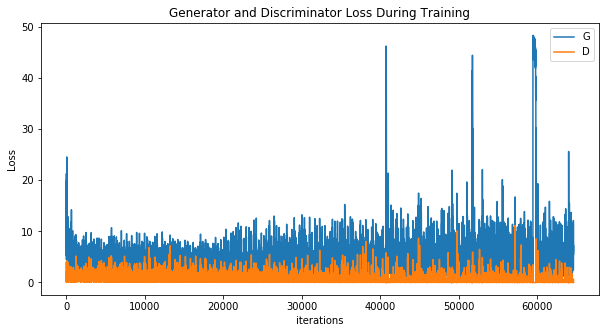

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [2]:
#%%capture
fig = plt.figure(figsize=(68,68))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat=False, blit=True)
ani.save('64fpsgrid.gif', writer='imagemagick', fps=64)
HTML(ani.to_jshtml())http://localhost:8888/notebooks/Documents/dcgan.ipynb#

NameError: name 'plt' is not defined

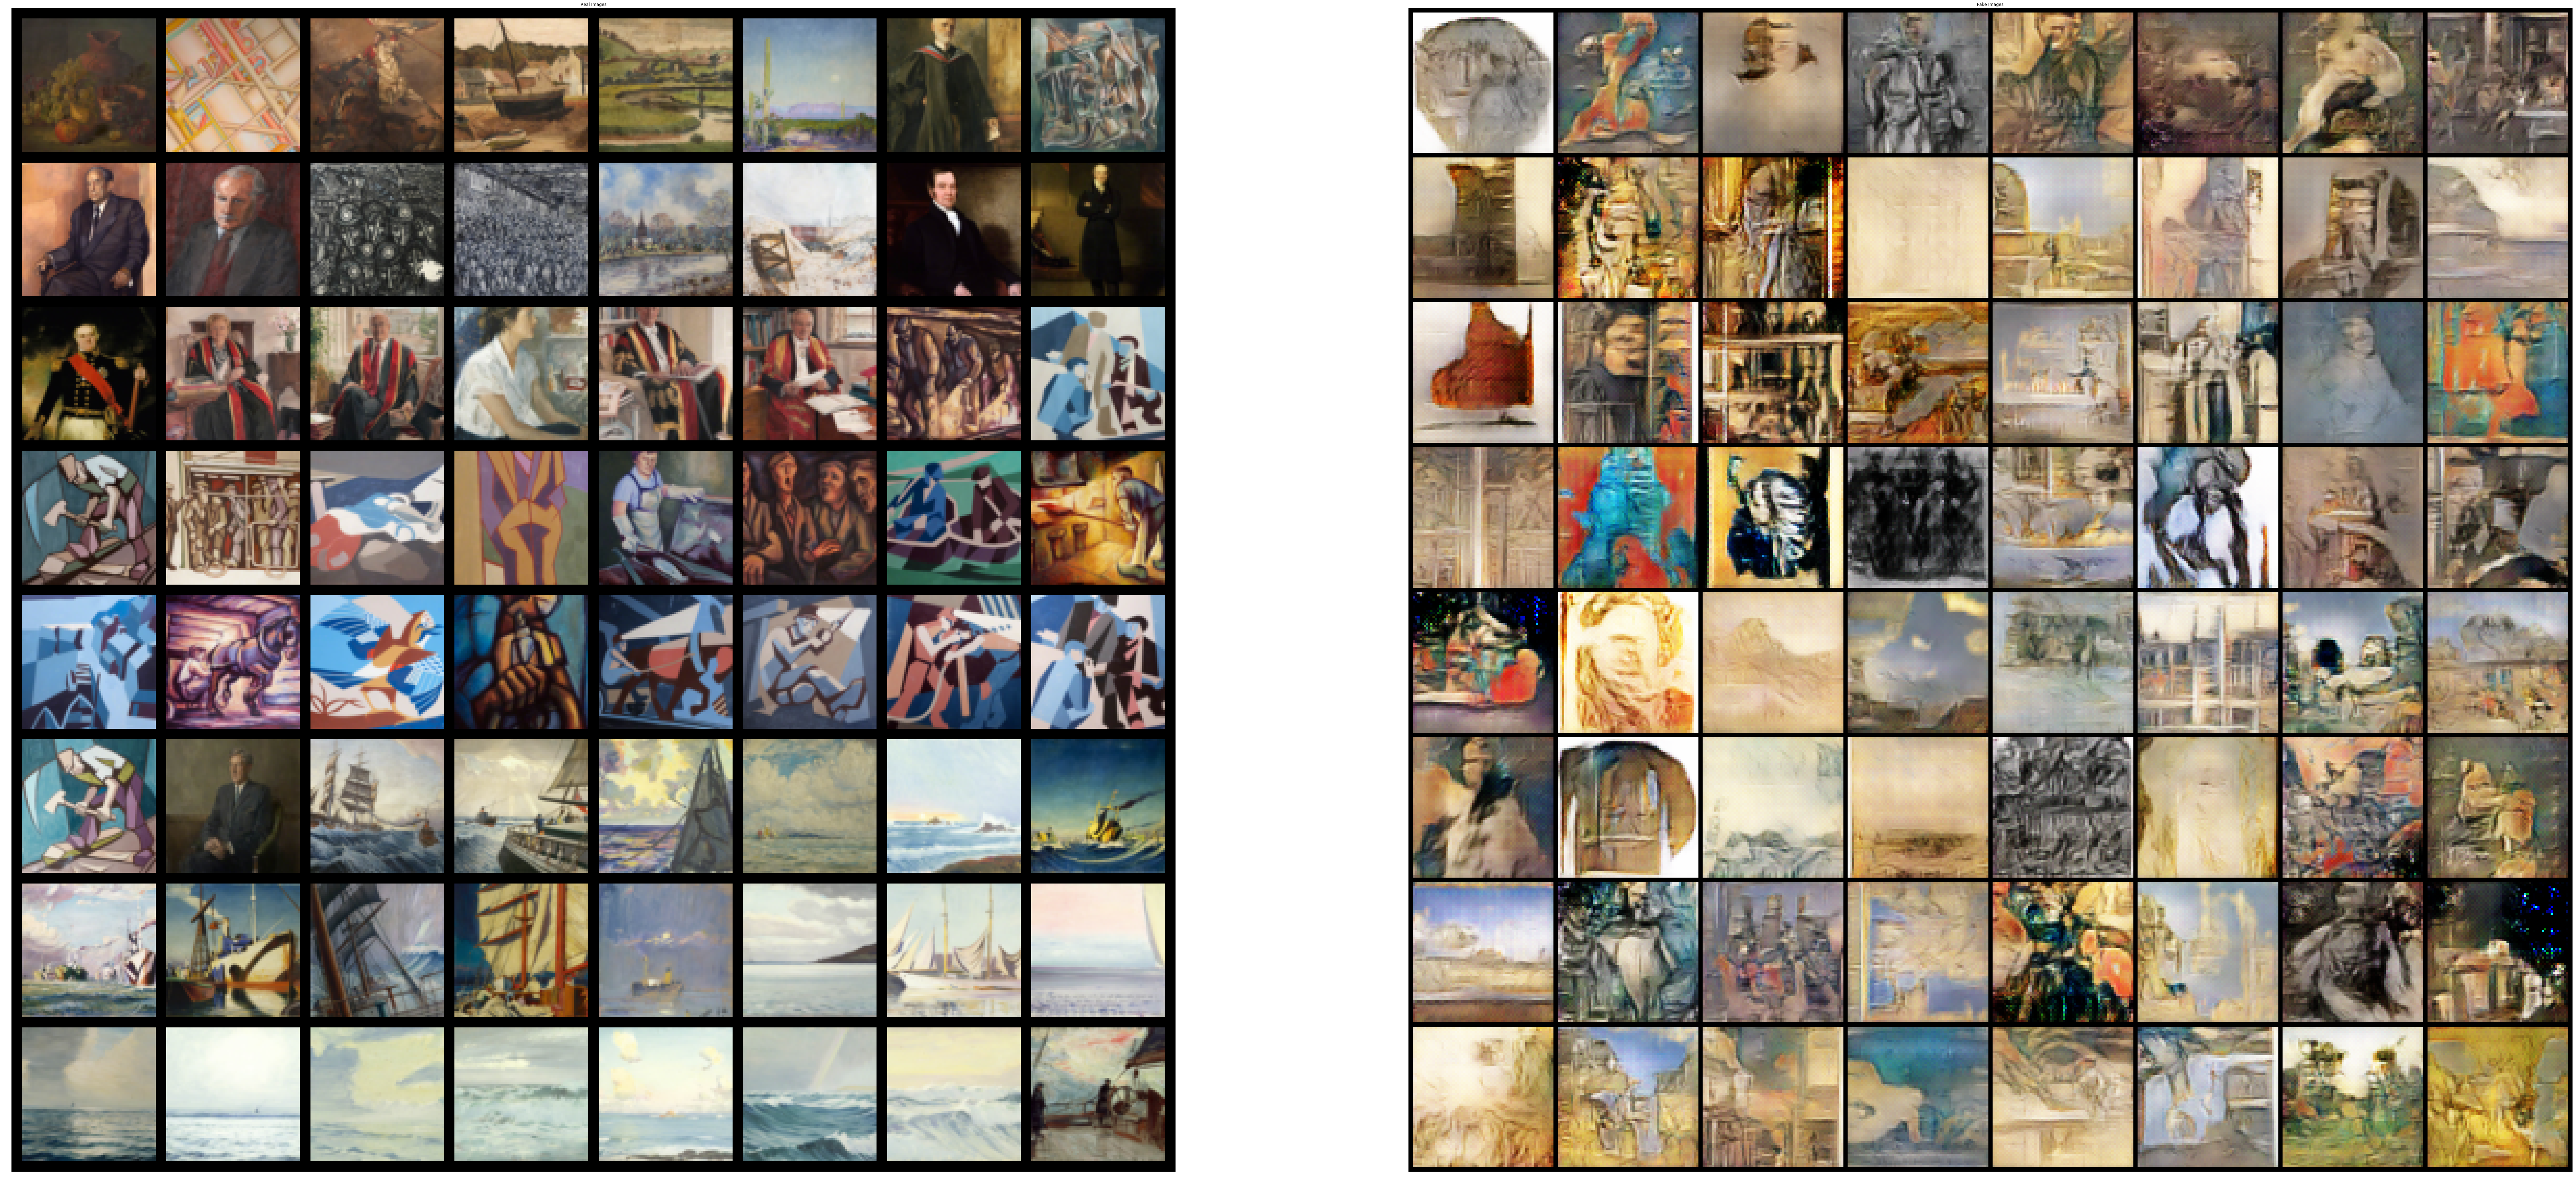

In [16]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(132,132))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

#Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

ValueError: Invalid file object: <_io.BufferedReader name=77>

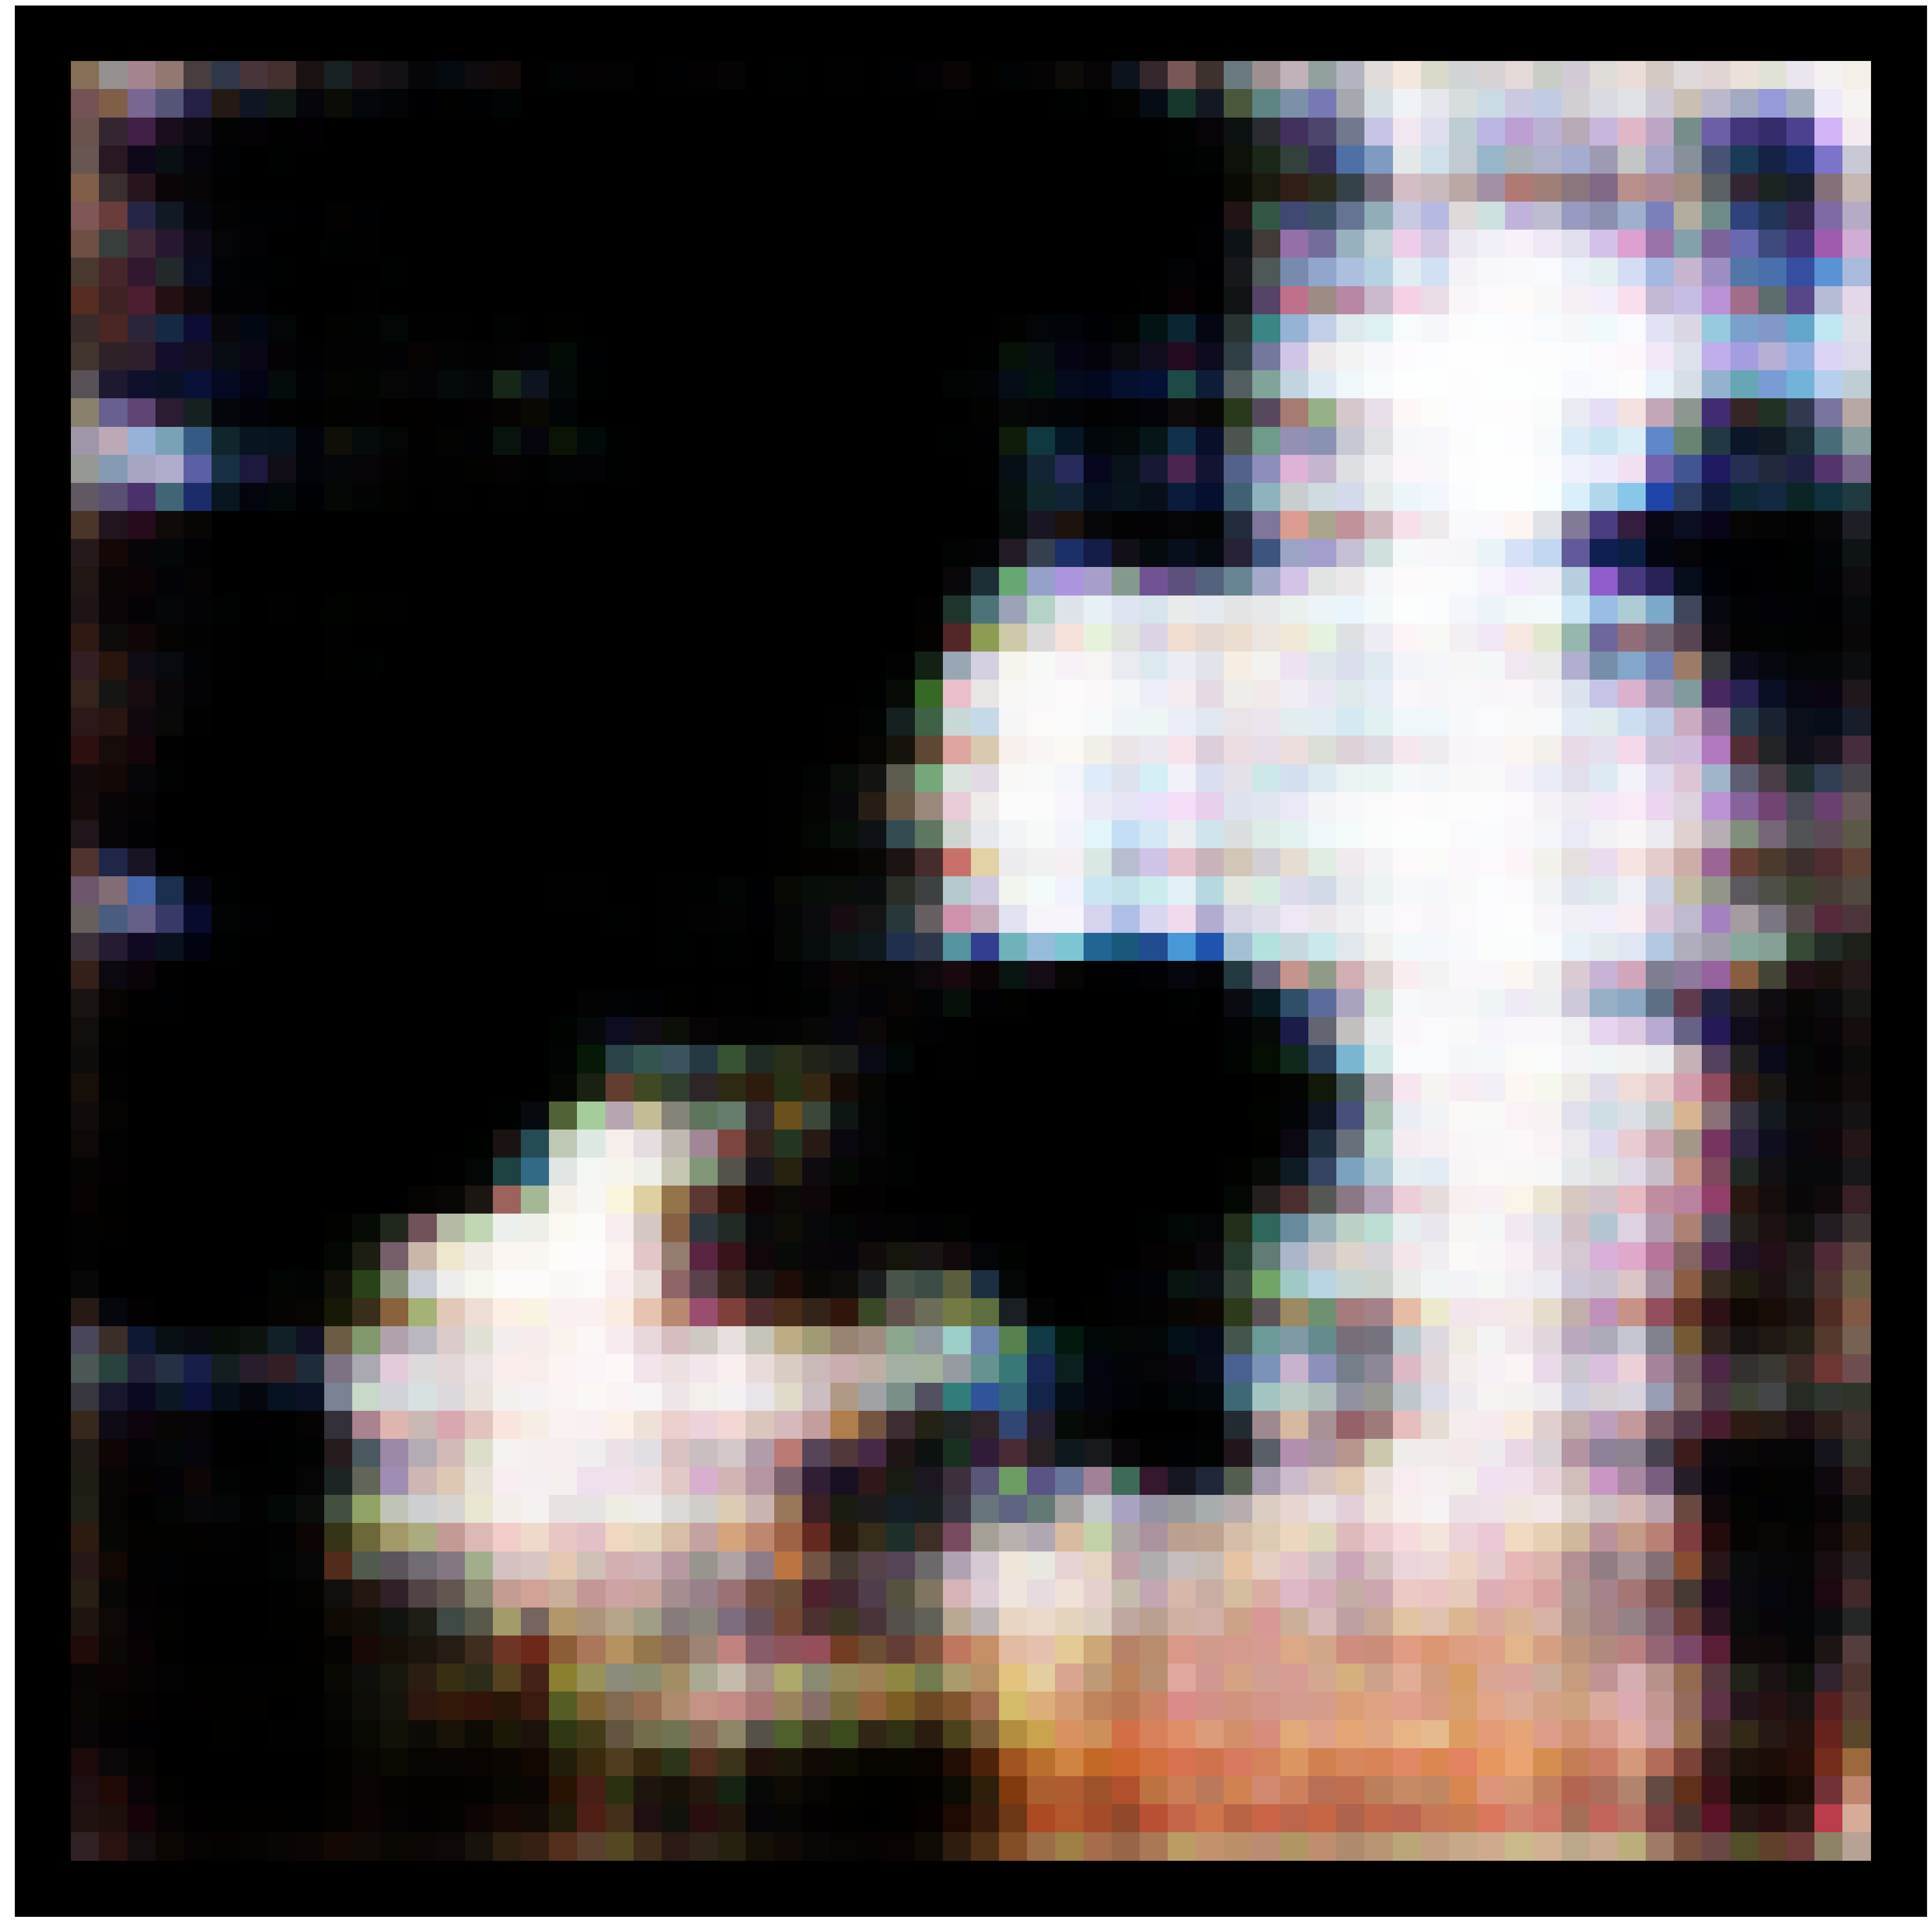

In [22]:
#%%capture
fig = plt.figure(figsize=(64,64))
plt.axis("off")
ims = [[plt.imshow(np.transpose(vutils.make_grid(img_list[i].to(device)[:68,:68,:68], padding=2, normalize=True).cpu(),(1,2,0)), animated=True)] for i in range(100)]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani.save('4fpssingle.gif', writer='imagemagick', fps=4)
HTML(ani.to_jshtml())

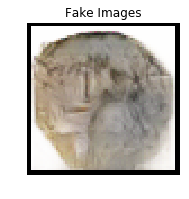

In [20]:
#plot image through time via epochs
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1].to(device)[:68,:68,:68], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()